## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


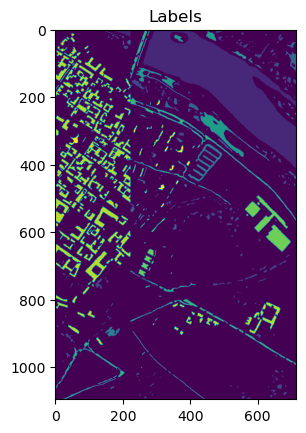

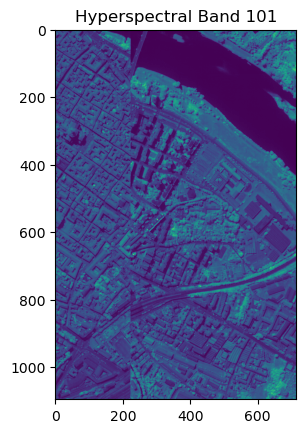

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 40 train


 -- Test set created with: 
	147747 samples
	shape (147747, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(360, 5, 5, 102)
(45, 5, 5, 102)
(147747, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1582, PSNR: 4.9390


	 Training Batch [200/1852], Loss: 0.0854, PSNR: 6.9029


	 Training Batch [400/1852], Loss: 0.0442, PSNR: 8.6675


	 Training Batch [600/1852], Loss: 0.0234, PSNR: 12.2430


	 Training Batch [800/1852], Loss: 0.0172, PSNR: 12.2103


	 Training Batch [1000/1852], Loss: 0.0137, PSNR: 15.8192


	 Training Batch [1200/1852], Loss: 0.0099, PSNR: 16.9322


	 Training Batch [1400/1852], Loss: 0.0090, PSNR: 16.3937


	 Training Batch [1600/1852], Loss: 0.0063, PSNR: 21.9965


	 Training Batch [1800/1852], Loss: 0.0067, PSNR: 17.1568


Epoch [1/50] Training Loss: 0.0307, PSNR: 13.8386
	[Val]   Batch [1/463] Loss: 0.0054, PSNR: 17.9394
	[Val]   Batch [10/463] Loss: 0.0050, PSNR: 19.0721
	[Val]   Batch [20/463] Loss: 0.0051, PSNR: 18.0762
	[Val]   Batch [30/463] Loss: 0.0061, PSNR: 18.6283
	[Val]   Batch [40/463] Loss: 0.0048, PSNR: 17.7887
	[Val]   Batch [50/463] Loss: 0.0051, PSNR: 17.9917
	[Val]   Batch [60/463] Loss: 0.0048, PSNR: 18.0223


	[Val]   Batch [70/463] Loss: 0.0068, PSNR: 18.3768
	[Val]   Batch [80/463] Loss: 0.0061, PSNR: 20.2999
	[Val]   Batch [90/463] Loss: 0.0059, PSNR: 19.3838
	[Val]   Batch [100/463] Loss: 0.0059, PSNR: 19.0879
	[Val]   Batch [110/463] Loss: 0.0069, PSNR: 18.4949
	[Val]   Batch [120/463] Loss: 0.0047, PSNR: 18.0296
	[Val]   Batch [130/463] Loss: 0.0055, PSNR: 19.4053


	[Val]   Batch [140/463] Loss: 0.0064, PSNR: 18.9743
	[Val]   Batch [150/463] Loss: 0.0073, PSNR: 18.9866
	[Val]   Batch [160/463] Loss: 0.0059, PSNR: 19.2590
	[Val]   Batch [170/463] Loss: 0.0076, PSNR: 18.1894
	[Val]   Batch [180/463] Loss: 0.0055, PSNR: 19.0051
	[Val]   Batch [190/463] Loss: 0.0060, PSNR: 19.3186
	[Val]   Batch [200/463] Loss: 0.0060, PSNR: 18.7061


	[Val]   Batch [210/463] Loss: 0.0058, PSNR: 18.3040
	[Val]   Batch [220/463] Loss: 0.0057, PSNR: 19.5394
	[Val]   Batch [230/463] Loss: 0.0068, PSNR: 19.3355
	[Val]   Batch [240/463] Loss: 0.0051, PSNR: 18.1442
	[Val]   Batch [250/463] Loss: 0.0066, PSNR: 17.3356
	[Val]   Batch [260/463] Loss: 0.0057, PSNR: 18.3605
	[Val]   Batch [270/463] Loss: 0.0044, PSNR: 17.5271
	[Val]   Batch [280/463] Loss: 0.0054, PSNR: 20.2341


	[Val]   Batch [290/463] Loss: 0.0060, PSNR: 17.2258
	[Val]   Batch [300/463] Loss: 0.0060, PSNR: 19.5109
	[Val]   Batch [310/463] Loss: 0.0055, PSNR: 19.3995
	[Val]   Batch [320/463] Loss: 0.0056, PSNR: 19.2532
	[Val]   Batch [330/463] Loss: 0.0065, PSNR: 18.6339
	[Val]   Batch [340/463] Loss: 0.0053, PSNR: 19.5966
	[Val]   Batch [350/463] Loss: 0.0070, PSNR: 19.5055
	[Val]   Batch [360/463] Loss: 0.0047, PSNR: 20.4580


	[Val]   Batch [370/463] Loss: 0.0069, PSNR: 18.5736
	[Val]   Batch [380/463] Loss: 0.0068, PSNR: 18.7216
	[Val]   Batch [390/463] Loss: 0.0062, PSNR: 18.5305
	[Val]   Batch [400/463] Loss: 0.0055, PSNR: 17.5920
	[Val]   Batch [410/463] Loss: 0.0053, PSNR: 19.9123
	[Val]   Batch [420/463] Loss: 0.0056, PSNR: 18.6971
	[Val]   Batch [430/463] Loss: 0.0054, PSNR: 18.1348


	[Val]   Batch [440/463] Loss: 0.0053, PSNR: 19.1255
	[Val]   Batch [450/463] Loss: 0.0041, PSNR: 16.5227
	[Val]   Batch [460/463] Loss: 0.0058, PSNR: 17.8629
Epoch [1/50] Validation Loss: 0.0058, PSNR: 18.6826

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0062, PSNR: 19.2591


	 Training Batch [200/1852], Loss: 0.0046, PSNR: 20.2884


	 Training Batch [400/1852], Loss: 0.0050, PSNR: 19.1417


	 Training Batch [600/1852], Loss: 0.0042, PSNR: 18.4247


	 Training Batch [800/1852], Loss: 0.0050, PSNR: 20.3283


	 Training Batch [1000/1852], Loss: 0.0042, PSNR: 18.9285


	 Training Batch [1200/1852], Loss: 0.0041, PSNR: 20.6446


	 Training Batch [1400/1852], Loss: 0.0038, PSNR: 20.9358


	 Training Batch [1600/1852], Loss: 0.0025, PSNR: 20.0636


	 Training Batch [1800/1852], Loss: 0.0028, PSNR: 21.9809


Epoch [2/50] Training Loss: 0.0043, PSNR: 20.0941
	[Val]   Batch [1/463] Loss: 0.0026, PSNR: 21.0497
	[Val]   Batch [10/463] Loss: 0.0024, PSNR: 22.2166
	[Val]   Batch [20/463] Loss: 0.0024, PSNR: 21.3131
	[Val]   Batch [30/463] Loss: 0.0030, PSNR: 21.6517
	[Val]   Batch [40/463] Loss: 0.0024, PSNR: 20.7944
	[Val]   Batch [50/463] Loss: 0.0025, PSNR: 21.0326
	[Val]   Batch [60/463] Loss: 0.0024, PSNR: 21.1255


	[Val]   Batch [70/463] Loss: 0.0035, PSNR: 21.2861
	[Val]   Batch [80/463] Loss: 0.0031, PSNR: 23.1356
	[Val]   Batch [90/463] Loss: 0.0029, PSNR: 22.4471
	[Val]   Batch [100/463] Loss: 0.0031, PSNR: 21.8859
	[Val]   Batch [110/463] Loss: 0.0035, PSNR: 21.4334
	[Val]   Batch [120/463] Loss: 0.0023, PSNR: 21.0522
	[Val]   Batch [130/463] Loss: 0.0027, PSNR: 22.5506
	[Val]   Batch [140/463] Loss: 0.0033, PSNR: 21.9090


	[Val]   Batch [150/463] Loss: 0.0036, PSNR: 22.0186
	[Val]   Batch [160/463] Loss: 0.0031, PSNR: 21.9909
	[Val]   Batch [170/463] Loss: 0.0039, PSNR: 21.0454
	[Val]   Batch [180/463] Loss: 0.0030, PSNR: 21.6735
	[Val]   Batch [190/463] Loss: 0.0029, PSNR: 22.3891
	[Val]   Batch [200/463] Loss: 0.0030, PSNR: 21.6613
	[Val]   Batch [210/463] Loss: 0.0031, PSNR: 20.9766


	[Val]   Batch [220/463] Loss: 0.0029, PSNR: 22.4147
	[Val]   Batch [230/463] Loss: 0.0033, PSNR: 22.4449
	[Val]   Batch [240/463] Loss: 0.0026, PSNR: 21.1650
	[Val]   Batch [250/463] Loss: 0.0034, PSNR: 20.2316
	[Val]   Batch [260/463] Loss: 0.0029, PSNR: 21.2610
	[Val]   Batch [270/463] Loss: 0.0021, PSNR: 20.6836


	[Val]   Batch [280/463] Loss: 0.0027, PSNR: 23.2387
	[Val]   Batch [290/463] Loss: 0.0029, PSNR: 20.3270
	[Val]   Batch [300/463] Loss: 0.0030, PSNR: 22.4383
	[Val]   Batch [310/463] Loss: 0.0030, PSNR: 22.0645
	[Val]   Batch [320/463] Loss: 0.0029, PSNR: 22.1504
	[Val]   Batch [330/463] Loss: 0.0032, PSNR: 21.7643
	[Val]   Batch [340/463] Loss: 0.0027, PSNR: 22.5239
	[Val]   Batch [350/463] Loss: 0.0038, PSNR: 22.1916


	[Val]   Batch [360/463] Loss: 0.0025, PSNR: 23.1535
	[Val]   Batch [370/463] Loss: 0.0034, PSNR: 21.6704
	[Val]   Batch [380/463] Loss: 0.0032, PSNR: 21.9643
	[Val]   Batch [390/463] Loss: 0.0030, PSNR: 21.6779
	[Val]   Batch [400/463] Loss: 0.0028, PSNR: 20.4794
	[Val]   Batch [410/463] Loss: 0.0026, PSNR: 23.0600
	[Val]   Batch [420/463] Loss: 0.0027, PSNR: 21.7949


	[Val]   Batch [430/463] Loss: 0.0028, PSNR: 20.9958
	[Val]   Batch [440/463] Loss: 0.0028, PSNR: 21.9654
	[Val]   Batch [450/463] Loss: 0.0021, PSNR: 19.4811
	[Val]   Batch [460/463] Loss: 0.0028, PSNR: 20.9606
Epoch [2/50] Validation Loss: 0.0029, PSNR: 21.6803

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0025, PSNR: 20.5007


	 Training Batch [200/1852], Loss: 0.0021, PSNR: 22.0495


	 Training Batch [400/1852], Loss: 0.0024, PSNR: 21.8932


	 Training Batch [600/1852], Loss: 0.0033, PSNR: 22.3777


	 Training Batch [800/1852], Loss: 0.0019, PSNR: 22.8166


	 Training Batch [1000/1852], Loss: 0.0022, PSNR: 24.0971


	 Training Batch [1200/1852], Loss: 0.0021, PSNR: 22.7936


	 Training Batch [1400/1852], Loss: 0.0020, PSNR: 23.0169


	 Training Batch [1600/1852], Loss: 0.0026, PSNR: 23.7105


	 Training Batch [1800/1852], Loss: 0.0022, PSNR: 23.5612


Epoch [3/50] Training Loss: 0.0024, PSNR: 22.6955
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.3431
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.5255
	[Val]   Batch [20/463] Loss: 0.0014, PSNR: 23.7046
	[Val]   Batch [30/463] Loss: 0.0017, PSNR: 24.1823
	[Val]   Batch [40/463] Loss: 0.0015, PSNR: 22.8236
	[Val]   Batch [50/463] Loss: 0.0015, PSNR: 23.2104
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.2616


	[Val]   Batch [70/463] Loss: 0.0019, PSNR: 23.8255
	[Val]   Batch [80/463] Loss: 0.0018, PSNR: 25.6319
	[Val]   Batch [90/463] Loss: 0.0017, PSNR: 24.7903
	[Val]   Batch [100/463] Loss: 0.0018, PSNR: 24.3120
	[Val]   Batch [110/463] Loss: 0.0019, PSNR: 24.0457
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.1289
	[Val]   Batch [130/463] Loss: 0.0015, PSNR: 25.1287


	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.3953
	[Val]   Batch [150/463] Loss: 0.0019, PSNR: 24.8203
	[Val]   Batch [160/463] Loss: 0.0019, PSNR: 24.0620
	[Val]   Batch [170/463] Loss: 0.0023, PSNR: 23.3752
	[Val]   Batch [180/463] Loss: 0.0018, PSNR: 23.8846
	[Val]   Batch [190/463] Loss: 0.0016, PSNR: 24.9024
	[Val]   Batch [200/463] Loss: 0.0017, PSNR: 24.2352


	[Val]   Batch [210/463] Loss: 0.0019, PSNR: 23.0613
	[Val]   Batch [220/463] Loss: 0.0018, PSNR: 24.6221
	[Val]   Batch [230/463] Loss: 0.0017, PSNR: 25.3389
	[Val]   Batch [240/463] Loss: 0.0015, PSNR: 23.4687
	[Val]   Batch [250/463] Loss: 0.0020, PSNR: 22.4542
	[Val]   Batch [260/463] Loss: 0.0018, PSNR: 23.4637
	[Val]   Batch [270/463] Loss: 0.0013, PSNR: 22.8242


	[Val]   Batch [280/463] Loss: 0.0016, PSNR: 25.5468
	[Val]   Batch [290/463] Loss: 0.0017, PSNR: 22.6707
	[Val]   Batch [300/463] Loss: 0.0019, PSNR: 24.5698
	[Val]   Batch [310/463] Loss: 0.0019, PSNR: 24.0932
	[Val]   Batch [320/463] Loss: 0.0017, PSNR: 24.4989
	[Val]   Batch [330/463] Loss: 0.0017, PSNR: 24.3790
	[Val]   Batch [340/463] Loss: 0.0016, PSNR: 24.8370


	[Val]   Batch [350/463] Loss: 0.0022, PSNR: 24.5169
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.7657
	[Val]   Batch [370/463] Loss: 0.0019, PSNR: 24.2335
	[Val]   Batch [380/463] Loss: 0.0017, PSNR: 24.8227
	[Val]   Batch [390/463] Loss: 0.0016, PSNR: 24.3655
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.5488


	[Val]   Batch [410/463] Loss: 0.0015, PSNR: 25.4136
	[Val]   Batch [420/463] Loss: 0.0016, PSNR: 24.1988
	[Val]   Batch [430/463] Loss: 0.0018, PSNR: 23.0325
	[Val]   Batch [440/463] Loss: 0.0017, PSNR: 24.1516
	[Val]   Batch [450/463] Loss: 0.0014, PSNR: 21.3311
	[Val]   Batch [460/463] Loss: 0.0017, PSNR: 23.2522
Epoch [3/50] Validation Loss: 0.0017, PSNR: 24.0411

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0023, PSNR: 23.4971


	 Training Batch [200/1852], Loss: 0.0020, PSNR: 24.1180


	 Training Batch [400/1852], Loss: 0.0016, PSNR: 24.2490


	 Training Batch [600/1852], Loss: 0.0019, PSNR: 23.8186


	 Training Batch [800/1852], Loss: 0.0015, PSNR: 22.9411


	 Training Batch [1000/1852], Loss: 0.0015, PSNR: 25.2918


	 Training Batch [1200/1852], Loss: 0.0017, PSNR: 23.6319


	 Training Batch [1400/1852], Loss: 0.0016, PSNR: 24.8977


	 Training Batch [1600/1852], Loss: 0.0014, PSNR: 27.1417


	 Training Batch [1800/1852], Loss: 0.0013, PSNR: 24.3886


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.3883
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.7774
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.0046
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.1971
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.7181
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.1671
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.6176


	[Val]   Batch [60/463] Loss: 0.0011, PSNR: 24.6109
	[Val]   Batch [70/463] Loss: 0.0014, PSNR: 25.3544
	[Val]   Batch [80/463] Loss: 0.0012, PSNR: 27.3442
	[Val]   Batch [90/463] Loss: 0.0012, PSNR: 26.3384
	[Val]   Batch [100/463] Loss: 0.0013, PSNR: 25.8529
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.6873
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.5730


	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.7031
	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.9342
	[Val]   Batch [150/463] Loss: 0.0013, PSNR: 26.5313
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.3978
	[Val]   Batch [170/463] Loss: 0.0017, PSNR: 24.7761
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.2820
	[Val]   Batch [190/463] Loss: 0.0012, PSNR: 26.4155


	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 25.8856
	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.4118
	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 26.0525
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.1594
	[Val]   Batch [240/463] Loss: 0.0011, PSNR: 24.9777
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.8342
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.7650
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.3085


	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.0277
	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.2074
	[Val]   Batch [300/463] Loss: 0.0014, PSNR: 25.9082
	[Val]   Batch [310/463] Loss: 0.0014, PSNR: 25.4460
	[Val]   Batch [320/463] Loss: 0.0012, PSNR: 26.0371
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 26.0281
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.3440


	[Val]   Batch [350/463] Loss: 0.0016, PSNR: 26.0097
	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.8107
	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.8522
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.5897
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.0767
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.8855
	[Val]   Batch [410/463] Loss: 0.0011, PSNR: 26.9394


	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.6601
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.2774
	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.6035
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.6601
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.6673
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.5474

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0012, PSNR: 25.4687


	 Training Batch [200/1852], Loss: 0.0013, PSNR: 25.3468


	 Training Batch [400/1852], Loss: 0.0016, PSNR: 23.4176


	 Training Batch [600/1852], Loss: 0.0013, PSNR: 25.6624


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 25.7927


	 Training Batch [1000/1852], Loss: 0.0012, PSNR: 22.6855


	 Training Batch [1200/1852], Loss: 0.0011, PSNR: 26.1845


	 Training Batch [1400/1852], Loss: 0.0014, PSNR: 25.6208


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 25.6140


	 Training Batch [1800/1852], Loss: 0.0011, PSNR: 25.9905


Epoch [5/50] Training Loss: 0.0012, PSNR: 25.4574
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.7761
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.0924
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.3109
	[Val]   Batch [30/463] Loss: 0.0010, PSNR: 26.7077
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.1422
	[Val]   Batch [50/463] Loss: 0.0009, PSNR: 25.7181
	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.6041


	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.3681
	[Val]   Batch [80/463] Loss: 0.0009, PSNR: 28.5693
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.4049
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.9194
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.7796
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.6130
	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.7602


	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 27.0005
	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.6432
	[Val]   Batch [160/463] Loss: 0.0012, PSNR: 26.3349
	[Val]   Batch [170/463] Loss: 0.0014, PSNR: 25.6773
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.3058
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.4530


	[Val]   Batch [200/463] Loss: 0.0009, PSNR: 27.0815
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.3795
	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 27.0524
	[Val]   Batch [230/463] Loss: 0.0009, PSNR: 28.3238
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.0428
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.8017
	[Val]   Batch [260/463] Loss: 0.0011, PSNR: 25.6404
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.5051


	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 28.1040
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.2683
	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 26.8295
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.4831
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.1829
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.1212


	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.4397
	[Val]   Batch [350/463] Loss: 0.0013, PSNR: 26.9668
	[Val]   Batch [360/463] Loss: 0.0011, PSNR: 26.6110
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.9103
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.7478
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.2018
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.8518


	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 27.9955
	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.6824
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.1959
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.5729
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.7046
	[Val]   Batch [460/463] Loss: 0.0010, PSNR: 25.6662
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.6091

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0009, PSNR: 24.7771


	 Training Batch [200/1852], Loss: 0.0011, PSNR: 26.5332


	 Training Batch [400/1852], Loss: 0.0011, PSNR: 26.7027


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 27.2630


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 23.9307


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 26.5047


	 Training Batch [1200/1852], Loss: 0.0012, PSNR: 26.4790


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 26.6255


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 26.0507


	 Training Batch [1800/1852], Loss: 0.0013, PSNR: 26.8849


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.2908
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.6028
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 27.9781
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.1689
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.5639
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 25.9125
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.5988
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.4028


	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.1972
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.6242
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.3314
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.8072
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.7197
	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 26.4714
	[Val]   Batch [130/463] Loss: 0.0007, PSNR: 28.6339


	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 27.9095
	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.6055
	[Val]   Batch [160/463] Loss: 0.0010, PSNR: 27.1202
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.4700
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.1793
	[Val]   Batch [190/463] Loss: 0.0008, PSNR: 28.3016
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.0356


	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.1928
	[Val]   Batch [220/463] Loss: 0.0008, PSNR: 27.8711
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.3390
	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 26.9353
	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.6318
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.3802


	[Val]   Batch [270/463] Loss: 0.0006, PSNR: 26.4628
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 28.9716
	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.1850
	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.5019
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.3196
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.1563
	[Val]   Batch [330/463] Loss: 0.0008, PSNR: 28.0355


	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.3214
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 27.8299
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.2265
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.8433
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.7375
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.1614
	[Val]   Batch [400/463] Loss: 0.0009, PSNR: 25.6514


	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.8502
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.5275
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 26.0057
	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.3869
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 24.5667
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.4950
Epoch [6/50] Validation Loss: 0.0008, PSNR: 27.4898

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0009, PSNR: 26.5920


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 28.0586


	 Training Batch [400/1852], Loss: 0.0011, PSNR: 24.9030


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 27.8609


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.2672


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 28.0119


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 26.9397


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.3889


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 28.3613


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.9300


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.9772
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.4335
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 28.9140
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.1212
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.4478
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.8124
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.5534
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.2399


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.0573
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.6132
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.2324
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.6943
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.6313
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.3331
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.4816


	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.7704
	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.5475
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 27.9183
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.2966
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 28.0239
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.1425
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.9449


	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 27.0663
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.6623
	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 30.2021
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.8055
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.4835
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.2254
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.4441


	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.8253
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.0661
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.2486
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.1633
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 29.1294
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 28.9284


	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.2381
	[Val]   Batch [350/463] Loss: 0.0009, PSNR: 28.6619
	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.8247
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.7694
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.7755
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.1447
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.4706
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.7139


	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.4194
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.8415
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.1657
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.4191
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 27.3413
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.3907

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 27.7145


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.5893


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 26.7568


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 26.8373


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 27.3534


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 26.7292


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 26.3553


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 27.1059


	 Training Batch [1600/1852], Loss: 0.0009, PSNR: 26.1579


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 29.1105


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.5832
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.0568
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.6670
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.8751
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 29.0649
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.4983
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.3872
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.9311


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.7452
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 31.4662
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 29.9102
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 29.4038
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 29.3607
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 28.0146
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.1192


	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.4441
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.3485
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.6568
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 27.9101
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.7623
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.8107
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.8054
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 27.8133


	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.3015
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.8406
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.5093
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.2032
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 27.9226
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.2863
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.4972
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.7553


	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 28.8176
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 28.9644
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.8968
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.6552
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 30.0071
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.3549
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.3134


	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.3721
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.5173
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.8802
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.1191
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.3892
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.1359
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.5411
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.7950


	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.1994
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.1206
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.1117

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 25.9874


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 26.5318


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 29.1021


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.3729


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 28.1609


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 30.4070


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 28.3720


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 29.1151


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 27.9684


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.1807


Epoch [9/50] Training Loss: 0.0007, PSNR: 28.0560
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.4442
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.0937
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.2898
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.5825
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.8752
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.8670


	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 28.2979
	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 29.2518
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.0325
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.4129
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.8558
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.9333
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.4437
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.4957


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 29.9924
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 31.0210
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.1841
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.5005
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.2880
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.2664
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.2652


	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.3866
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.7339
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.3667
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.0033
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.7753
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.4740
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.7353
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.9049


	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.3720
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.3106
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.4622
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.4131
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 30.2274
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.4467
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 29.9445


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.6278
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.9740
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.1702
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.4326
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.5099
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 30.7706
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.7004


	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.9951
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.1688
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.5997
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.7370
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.6076

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 29.4935


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 29.0105


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 29.0117


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 27.5709


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 26.0048


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 27.3883


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.5232


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.3431


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.8928


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 26.5653


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.4313
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.0096
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.7249
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.8011
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.1186
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.4221
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.4727
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.8727


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.8787
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.7211
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.9911
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.4694
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.5397
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.9729
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.0586


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.5287
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.7565
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.8008
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.0575
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 29.8540
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.8069
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.8868
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.0179


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.1790
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.9690
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.6057
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.3581
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.0566
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.3213
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.4360


	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.9293
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.8373
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.0327
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.0279
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.8583
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.0179
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.5318


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.9890
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.5337
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.8430
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 31.0012
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.0141
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.3385
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.2473


	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.5303
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.6344
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.1598
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.3417
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.1882

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 30.1317


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.3072


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 28.3181


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 29.1569


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 29.0032


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.8508


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 28.7142


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 27.0381


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 30.0275


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 29.1048


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.8159
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.4577
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.3221
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.3972
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.6229
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.9040
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.0942
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.4470


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.4097
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.1643
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.4935
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.9502
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.0617
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.4472
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.6457
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.0446


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.2345
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.3698
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.5829
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.3679
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.2330
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.4159
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.5399


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.7076
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.5028
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.1287
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.9272
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.7072
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.8967
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.9573


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.5552
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.2173
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.5611
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.6081
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.2873
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.5750
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.0181


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3448
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.0957
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.3435
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.5282
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.5010
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.8132
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.7137


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.0454
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.1486
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.7463
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.9449
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.7302

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 29.1856


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 28.7303


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.9516


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 30.4559


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 30.1431


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 29.9809


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.8784


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 30.4915


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 27.8658


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 29.7842


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.1533
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.8547
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.6285
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.6868
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.9691
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.2613
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.4406


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.8351
	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.8247
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.5330
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.8483
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.4006
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.4563
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.8162


	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.0006
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.3360
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.6588
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.7812
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.9602
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.7696
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.5506


	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.7324
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.9946
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.0044
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.8236
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.5488
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.2959


	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.1121
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.2323
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.3472
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.9246
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.6221
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.8951
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.9719


	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.6277
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.9449
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.4306
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.4776
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.4130
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.7117
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.8436


	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.8461
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.1161
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.0314
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.3873
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.4497
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.0696
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.2755
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.0760

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 29.5765


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 27.3625


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 29.9842


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 29.2330


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.0114


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 30.5730


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.4998


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.4038


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 29.8022


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.3029


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.4155
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.1359
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.9386
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.9500
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.2327
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.5174
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.8004
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.1242


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.1799
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.8697
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.1651
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.5861
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.7087
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.0170
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.2224


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.6465
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.9255
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.1960
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.2627
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.0417
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.7926
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.9783


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.3402
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.2324
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.1162
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.8544
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.6399
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.4958
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.5139


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.5559
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.2548
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 30.8063
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.1939
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.2996
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.8449
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.2501


	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.7654
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.7171
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.7202
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.9661
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.1315
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.1104
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.3549


	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.3125
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.6627
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.7286
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.4281
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.6423
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.3616

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 29.8875


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 30.0367


	 Training Batch [400/1852], Loss: 0.0009, PSNR: 28.5246


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 28.3133


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 30.7475


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.6860


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.1441


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 29.6659


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 29.0995


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.9288


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.6517
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.4282
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.3211
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.2981
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.6050
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.8469
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.1372
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.4883


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.5793
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.2954
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.5647
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.0021
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.1431
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.3834
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.6633


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.9976
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.4379
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.5547
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.6599
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.3494
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.1150
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.3837
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.7090


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.5686
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.5819
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.1902
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 30.0150
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.8373
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.8654
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.9260
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.6403


	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.2799
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.5423
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.6358
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.3190
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.5695
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.2266
	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.8499


	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.0925
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.4957
	[Val]   Batch [390/463] Loss: 0.0002, PSNR: 32.5200
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.4066
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.6241
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.6720
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.9565
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.0471


	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.6538
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.9510
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.7359
Early stopping triggered at epoch 14. No improvement for 3 epochs.


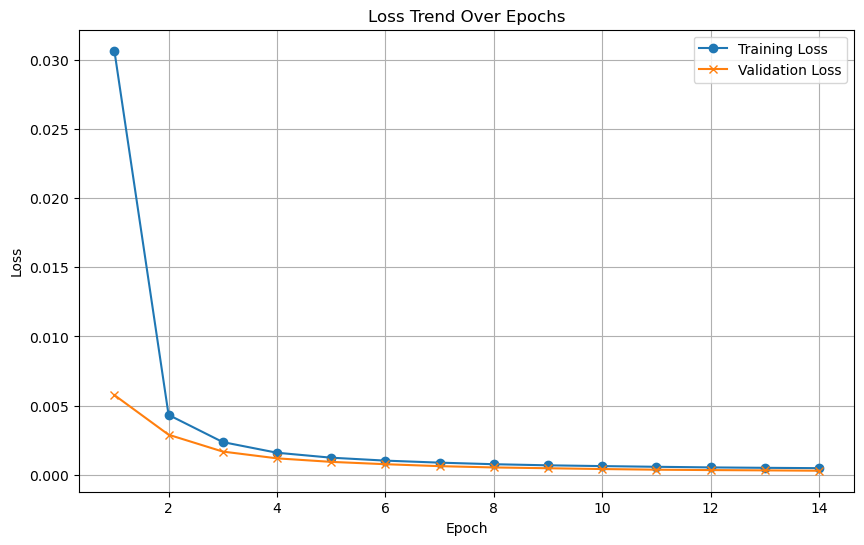

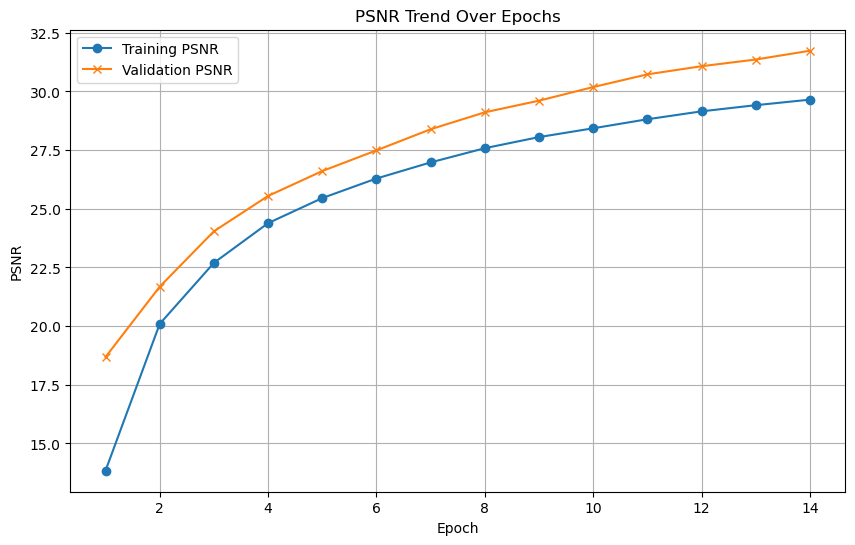

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/578 for test dataset.


    Processed batch 101/578 for test dataset.


    Processed batch 201/578 for test dataset.


    Processed batch 301/578 for test dataset.


    Processed batch 401/578 for test dataset.


    Processed batch 501/578 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1972
    Validation Batch [1/1], Loss: 2.2024
Validation Loss: 2.2024, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2024. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1257
    Validation Batch [1/1], Loss: 2.2024
Validation Loss: 2.2024, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0888
    Validation Batch [1/1], Loss: 2.2024
Validation Loss: 2.2024, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0602
    Validation Batch [1/1], Loss: 2.2024
Validation Loss: 2.2024, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training


Epoch [5/1000] completed, Average Training Loss: 2.0333
    Validation Batch [1/1], Loss: 2.2024
Validation Loss: 2.2024, Validation Accuracy: 11.11%
Validation loss improved from 2.2024 to 2.2024. Saving model...

LOG: Epoch [6/1000] - Training
Epoch [6/1000] completed, Average Training Loss: 1.9937
    Validation Batch [1/1], Loss: 2.2023
Validation Loss: 2.2023, Validation Accuracy: 11.11%
Validation loss improved from 2.2024 to 2.2023. Saving model...

LOG: Epoch [7/1000] - Training
Epoch [7/1000] completed, Average Training Loss: 1.9694
    Validation Batch [1/1], Loss: 2.2021
Validation Loss: 2.2021, Validation Accuracy: 11.11%
Validation loss improved from 2.2023 to 2.2021. Saving model...

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 1.9435
    Validation Batch [1/1], Loss: 2.2018
Validation Loss: 2.2018, Validation Accuracy: 11.11%
Validation loss improved from 2.2021 to 2.2018. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] c

    Validation Batch [1/1], Loss: 2.0324
Validation Loss: 2.0324, Validation Accuracy: 11.11%
Validation loss improved from 2.0706 to 2.0324. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.6585
    Validation Batch [1/1], Loss: 1.9836
Validation Loss: 1.9836, Validation Accuracy: 11.11%
Validation loss improved from 2.0324 to 1.9836. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.6242
    Validation Batch [1/1], Loss: 1.9379
Validation Loss: 1.9379, Validation Accuracy: 26.67%
Validation loss improved from 1.9836 to 1.9379. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 1.6278
    Validation Batch [1/1], Loss: 1.8972
Validation Loss: 1.8972, Validation Accuracy: 33.33%
Validation loss improved from 1.9379 to 1.8972. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 1.5930
    Vali

Epoch [38/1000] completed, Average Training Loss: 1.4071
    Validation Batch [1/1], Loss: 1.4067
Validation Loss: 1.4067, Validation Accuracy: 73.33%
Validation loss improved from 1.4319 to 1.4067. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.4026
    Validation Batch [1/1], Loss: 1.3938
Validation Loss: 1.3938, Validation Accuracy: 73.33%
Validation loss improved from 1.4067 to 1.3938. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.3612
    Validation Batch [1/1], Loss: 1.3772
Validation Loss: 1.3772, Validation Accuracy: 73.33%
Validation loss improved from 1.3938 to 1.3772. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.3543
    Validation Batch [1/1], Loss: 1.3583
Validation Loss: 1.3583, Validation Accuracy: 75.56%
Validation loss improved from 1.3772 to 1.3583. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [4

Epoch [54/1000] completed, Average Training Loss: 1.1529
    Validation Batch [1/1], Loss: 1.1485
Validation Loss: 1.1485, Validation Accuracy: 86.67%
Validation loss improved from 1.1787 to 1.1485. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 1.1624
    Validation Batch [1/1], Loss: 1.1551
Validation Loss: 1.1551, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.1580
    Validation Batch [1/1], Loss: 1.1498
Validation Loss: 1.1498, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.1226
    Validation Batch [1/1], Loss: 1.1135
Validation Loss: 1.1135, Validation Accuracy: 86.67%
Validation loss improved from 1.1485 to 1.1135. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Tra

Epoch [70/1000] completed, Average Training Loss: 0.9140
    Validation Batch [1/1], Loss: 0.9275
Validation Loss: 0.9275, Validation Accuracy: 86.67%
Validation loss improved from 0.9608 to 0.9275. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 0.9163
    Validation Batch [1/1], Loss: 0.9279
Validation Loss: 0.9279, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 0.8963
    Validation Batch [1/1], Loss: 0.9283
Validation Loss: 0.9283, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 0.8818
    Validation Batch [1/1], Loss: 0.9202
Validation Loss: 0.9202, Validation Accuracy: 86.67%
Validation loss improved from 0.9275 to 0.9202. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Tra

Epoch [86/1000] completed, Average Training Loss: 0.7143
    Validation Batch [1/1], Loss: 0.6914
Validation Loss: 0.6914, Validation Accuracy: 88.89%
Validation loss improved from 0.7196 to 0.6914. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 0.6955
    Validation Batch [1/1], Loss: 0.6855
Validation Loss: 0.6855, Validation Accuracy: 88.89%
Validation loss improved from 0.6914 to 0.6855. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 0.6969
    Validation Batch [1/1], Loss: 0.6937
Validation Loss: 0.6937, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 0.6647
    Validation Batch [1/1], Loss: 0.6514
Validation Loss: 0.6514, Validation Accuracy: 93.33%
Validation loss improved from 0.6855 to 0.6514. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] complet

Epoch [103/1000] completed, Average Training Loss: 0.5090
    Validation Batch [1/1], Loss: 0.4950
Validation Loss: 0.4950, Validation Accuracy: 97.78%
Validation loss improved from 0.5153 to 0.4950. Saving model...

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Average Training Loss: 0.5056
    Validation Batch [1/1], Loss: 0.4818
Validation Loss: 0.4818, Validation Accuracy: 95.56%
Validation loss improved from 0.4950 to 0.4818. Saving model...

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 0.4640
    Validation Batch [1/1], Loss: 0.4780
Validation Loss: 0.4780, Validation Accuracy: 95.56%
Validation loss improved from 0.4818 to 0.4780. Saving model...

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 0.4844
    Validation Batch [1/1], Loss: 0.4443
Validation Loss: 0.4443, Validation Accuracy: 95.56%
Validation loss improved from 0.4780 to 0.4443. Saving model...

LOG: Epoch [107/1000] - Training


    Validation Batch [1/1], Loss: 0.3418
Validation Loss: 0.3418, Validation Accuracy: 97.78%
Validation loss improved from 0.3604 to 0.3418. Saving model...

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 0.3697
    Validation Batch [1/1], Loss: 0.3937
Validation Loss: 0.3937, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 0.3462
    Validation Batch [1/1], Loss: 0.3370
Validation Loss: 0.3370, Validation Accuracy: 97.78%
Validation loss improved from 0.3418 to 0.3370. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 0.3518
    Validation Batch [1/1], Loss: 0.3438
Validation Loss: 0.3438, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 0.3412
    Validation Batch [1/1], Lo

Epoch [135/1000] completed, Average Training Loss: 0.2342
    Validation Batch [1/1], Loss: 0.2556
Validation Loss: 0.2556, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 0.2488
    Validation Batch [1/1], Loss: 0.2368
Validation Loss: 0.2368, Validation Accuracy: 97.78%
Validation loss improved from 0.2556 to 0.2368. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.2284
    Validation Batch [1/1], Loss: 0.2299
Validation Loss: 0.2299, Validation Accuracy: 97.78%
Validation loss improved from 0.2368 to 0.2299. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.2397
    Validation Batch [1/1], Loss: 0.2863
Validation Loss: 0.2863, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Av

Epoch [152/1000] completed, Average Training Loss: 0.1973
    Validation Batch [1/1], Loss: 0.1747
Validation Loss: 0.1747, Validation Accuracy: 97.78%
Validation loss improved from 0.1820 to 0.1747. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.1722
    Validation Batch [1/1], Loss: 0.2328
Validation Loss: 0.2328, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.1818
    Validation Batch [1/1], Loss: 0.1909
Validation Loss: 0.1909, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 0.1640
    Validation Batch [1/1], Loss: 0.1936
Validation Loss: 0.1936, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training 

Epoch [168/1000] completed, Average Training Loss: 0.1322
    Validation Batch [1/1], Loss: 0.1427
Validation Loss: 0.1427, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 0.1403
    Validation Batch [1/1], Loss: 0.1478
Validation Loss: 0.1478, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 0.1231
    Validation Batch [1/1], Loss: 0.1424
Validation Loss: 0.1424, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 0.1181
    Validation Batch [1/1], Loss: 0.1326
Validation Loss: 0.1326, Validation Accuracy: 97.78%
Validation loss improved from 0.1331 to 0.1326. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training 

Epoch [185/1000] completed, Average Training Loss: 0.1068
    Validation Batch [1/1], Loss: 0.2016
Validation Loss: 0.2016, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.1096
    Validation Batch [1/1], Loss: 0.1191
Validation Loss: 0.1191, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.0945
    Validation Batch [1/1], Loss: 0.1248
Validation Loss: 0.1248, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.0894
    Validation Batch [1/1], Loss: 0.2412
Validation Loss: 0.2412, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.0964
  

    Validation Batch [1/1], Loss: 0.1295
Validation Loss: 0.1295, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.0848
    Validation Batch [1/1], Loss: 0.1580
Validation Loss: 0.1580, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.0744
    Validation Batch [1/1], Loss: 0.1011
Validation Loss: 0.1011, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.0677
    Validation Batch [1/1], Loss: 0.1094
Validation Loss: 0.1094, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.0718
    Validation Batch [1/1], Loss: 0.0875
Validation Loss: 0.

Epoch [219/1000] completed, Average Training Loss: 0.0675
    Validation Batch [1/1], Loss: 0.0796
Validation Loss: 0.0796, Validation Accuracy: 97.78%
Validation loss improved from 0.0849 to 0.0796. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.0586
    Validation Batch [1/1], Loss: 0.1556
Validation Loss: 0.1556, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.0625
    Validation Batch [1/1], Loss: 0.0995
Validation Loss: 0.0995, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.0597
    Validation Batch [1/1], Loss: 0.0781
Validation Loss: 0.0781, Validation Accuracy: 97.78%
Validation loss improved from 0.0796 to 0.0781. Saving model...

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Av

Epoch [236/1000] completed, Average Training Loss: 0.0515
    Validation Batch [1/1], Loss: 0.0899
Validation Loss: 0.0899, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.0489
    Validation Batch [1/1], Loss: 0.0842
Validation Loss: 0.0842, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.0434
    Validation Batch [1/1], Loss: 0.0835
Validation Loss: 0.0835, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.0494
    Validation Batch [1/1], Loss: 0.0678
Validation Loss: 0.0678, Validation Accuracy: 97.78%
Validation loss improved from 0.0694 to 0.0678. Saving model...

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Trainin

Epoch [253/1000] completed, Average Training Loss: 0.0407
    Validation Batch [1/1], Loss: 0.0810
Validation Loss: 0.0810, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.0458
    Validation Batch [1/1], Loss: 0.0754
Validation Loss: 0.0754, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.0547
Validation Loss: 0.0547, Validation Accuracy: 97.78%
Validation loss improved from 0.0618 to 0.0547. Saving model...

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.0428
    Validation Batch [1/1], Loss: 0.0556
Validation Loss: 0.0556, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.0866
Validation Loss: 0.0866, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.0323
    Validation Batch [1/1], Loss: 0.0644
Validation Loss: 0.0644, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.0365
    Validation Batch [1/1], Loss: 0.0546
Validation Loss: 0.0546, Validation Accuracy: 97.78%
Validation loss improved from 0.0547 to 0.0546. Saving model...

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.0363
    Validation Batch [1/1], Loss: 0.0623
Validation Loss: 0.0623, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.0359
    Validation Batch [1/1], Loss: 0.0724
Va

Epoch [289/1000] completed, Average Training Loss: 0.0337
    Validation Batch [1/1], Loss: 0.0578
Validation Loss: 0.0578, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.0319
    Validation Batch [1/1], Loss: 0.1569
Validation Loss: 0.1569, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.0299
    Validation Batch [1/1], Loss: 0.0725
Validation Loss: 0.0725, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.0309
    Validation Batch [1/1], Loss: 0.0596
Validation Loss: 0.0596, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.0323

Epoch [306/1000] completed, Average Training Loss: 0.0285
    Validation Batch [1/1], Loss: 0.0726
Validation Loss: 0.0726, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.0341
    Validation Batch [1/1], Loss: 0.0600
Validation Loss: 0.0600, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.0228
    Validation Batch [1/1], Loss: 0.0479
Validation Loss: 0.0479, Validation Accuracy: 97.78%
Validation loss improved from 0.0483 to 0.0479. Saving model...

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.0284
    Validation Batch [1/1], Loss: 0.0461
Validation Loss: 0.0461, Validation Accuracy: 97.78%
Validation loss improved from 0.0479 to 0.0461. Saving model...

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, 

Epoch [323/1000] completed, Average Training Loss: 0.0815
    Validation Batch [1/1], Loss: 0.1358
Validation Loss: 0.1358, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.0351
    Validation Batch [1/1], Loss: 0.5181
Validation Loss: 0.5181, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.1254
    Validation Batch [1/1], Loss: 0.4438
Validation Loss: 0.4438, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training Loss: 0.0616
    Validation Batch [1/1], Loss: 0.5835
Validation Loss: 0.5835, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.047

Epoch [341/1000] completed, Average Training Loss: 0.0272
    Validation Batch [1/1], Loss: 0.2166
Validation Loss: 0.2166, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.0249
    Validation Batch [1/1], Loss: 0.1057
Validation Loss: 0.1057, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.0239
    Validation Batch [1/1], Loss: 0.0962
Validation Loss: 0.0962, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.0282
    Validation Batch [1/1], Loss: 0.0893
Validation Loss: 0.0893, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.025

Epoch [359/1000] completed, Average Training Loss: 0.0173
    Validation Batch [1/1], Loss: 0.0720
Validation Loss: 0.0720, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.0198
    Validation Batch [1/1], Loss: 0.0756
Validation Loss: 0.0756, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.0230
    Validation Batch [1/1], Loss: 0.0770
Validation Loss: 0.0770, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.0174
    Validation Batch [1/1], Loss: 0.0708
Validation Loss: 0.0708, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.017

Epoch [376/1000] completed, Average Training Loss: 0.0165
    Validation Batch [1/1], Loss: 0.0768
Validation Loss: 0.0768, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.0171
    Validation Batch [1/1], Loss: 0.0648
Validation Loss: 0.0648, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.0155
    Validation Batch [1/1], Loss: 0.0576
Validation Loss: 0.0576, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.0168
    Validation Batch [1/1], Loss: 0.0556
Validation Loss: 0.0556, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.018

Epoch [394/1000] completed, Average Training Loss: 0.0153
    Validation Batch [1/1], Loss: 0.0570
Validation Loss: 0.0570, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.0633
Validation Loss: 0.0633, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.0148
    Validation Batch [1/1], Loss: 0.0691
Validation Loss: 0.0691, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.0163
    Validation Batch [1/1], Loss: 0.0722
Validation Loss: 0.0722, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.014

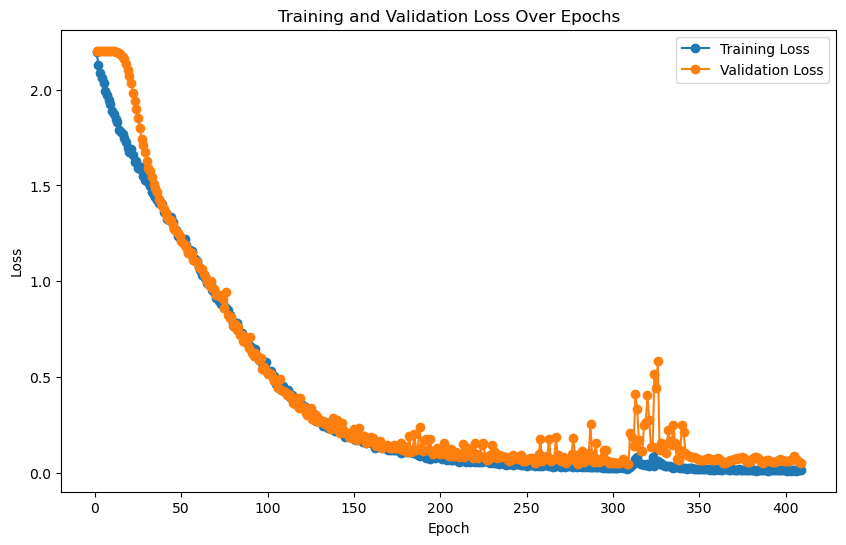

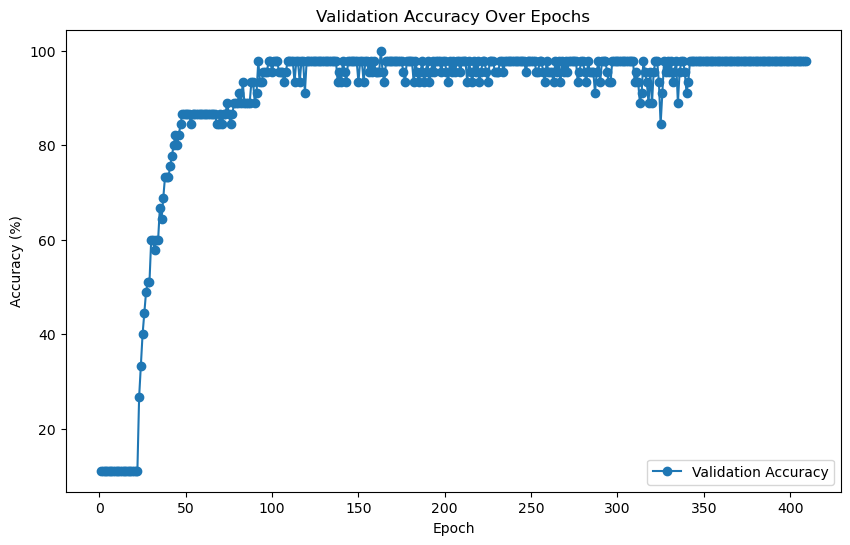


Evaluating on the test set...
    Test Batch [1/578], Loss: 0.1797



Final Test Loss: 0.0453, Test Accuracy: 98.72%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.


  Processed batch 40/578 for test dataset.


  Processed batch 50/578 for test dataset.
  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.


  Processed batch 90/578 for test dataset.


  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.


  Processed batch 140/578 for test dataset.


  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.


  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.


  Processed batch 240/578 for test dataset.


  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.


  Processed batch 290/578 for test dataset.


  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.


  Processed batch 340/578 for test dataset.


  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.


  Processed batch 390/578 for test dataset.


  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.


  Processed batch 440/578 for test dataset.


  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.


  Processed batch 490/578 for test dataset.


  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.


  Processed batch 540/578 for test dataset.


  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)

LOG: Training features shape: (360, 64), Training labels shape: (360,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (147747, 64), Test labels shape: (147747,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       0.80      0.80      0.80         5
           4       0.67      0.80      0.73         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       1.00      0.80      0.89         5
           8       1.00    

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)
Train reps shape: (360, 64)
Train labels shape: (360,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (147747, 64)
Test labels shape: (147747,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3613  |  Val Loss: 2.0108
Validation loss improved from inf to 2.0108.


[Epoch 2/1000] Train Loss: 1.9127  |  Val Loss: 1.7387
Validation loss improved from 2.0108 to 1.7387.
[Epoch 3/1000] Train Loss: 1.6530  |  Val Loss: 1.5551
Validation loss improved from 1.7387 to 1.5551.
[Epoch 4/1000] Train Loss: 1.4372  |  Val Loss: 1.3354
Validation loss improved from 1.5551 to 1.3354.
[Epoch 5/1000] Train Loss: 1.2154  |  Val Loss: 1.1377
Validation loss improved from 1.3354 to 1.1377.
[Epoch 6/1000] Train Loss: 1.0288  |  Val Loss: 0.9621
Validation loss improved from 1.1377 to 0.9621.
[Epoch 7/1000] Train Loss: 0.8683  |  Val Loss: 0.8090
Validation loss improved from 0.9621 to 0.8090.
[Epoch 8/1000] Train Loss: 0.7410  |  Val Loss: 0.7138
Validation loss improved from 0.8090 to 0.7138.
[Epoch 9/1000] Train Loss: 0.6347  |  Val Loss: 0.6108
Validation loss improved from 0.7138 to 0.6108.
[Epoch 10/1000] Train Loss: 0.5456  |  Val Loss: 0.5340
Validation loss improved from 0.6108 to 0.5340.
[Epoch 11/1000] Train Loss: 0.4775  |  Val Loss: 0.4663
Validation loss 

[Epoch 17/1000] Train Loss: 0.2494  |  Val Loss: 0.3045
Validation loss improved from 0.3153 to 0.3045.
[Epoch 18/1000] Train Loss: 0.2308  |  Val Loss: 0.3114
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 19/1000] Train Loss: 0.2145  |  Val Loss: 0.2896
Validation loss improved from 0.3045 to 0.2896.
[Epoch 20/1000] Train Loss: 0.2036  |  Val Loss: 0.2893
Validation loss improved from 0.2896 to 0.2893.
[Epoch 21/1000] Train Loss: 0.1976  |  Val Loss: 0.2764
Validation loss improved from 0.2893 to 0.2764.
[Epoch 22/1000] Train Loss: 0.1773  |  Val Loss: 0.2656
Validation loss improved from 0.2764 to 0.2656.
[Epoch 23/1000] Train Loss: 0.1732  |  Val Loss: 0.2663
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 24/1000] Train Loss: 0.1608  |  Val Loss: 0.2544
Validation loss improved from 0.2656 to 0.2544.
[Epoch 25/1000] Train Loss: 0.1613  |  Val Loss: 0.2741
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 26/1000] Train Loss: 0.1508  |  Val Los

[Epoch 34/1000] Train Loss: 0.1126  |  Val Loss: 0.2591
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 35/1000] Train Loss: 0.1049  |  Val Loss: 0.2187
Validation loss improved from 0.2311 to 0.2187.
[Epoch 36/1000] Train Loss: 0.0995  |  Val Loss: 0.2593
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 0.1007  |  Val Loss: 0.2484
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 38/1000] Train Loss: 0.0952  |  Val Loss: 0.2210
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 39/1000] Train Loss: 0.0861  |  Val Loss: 0.2263
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 40/1000] Train Loss: 0.0961  |  Val Loss: 0.2343
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 41/1000] Train Loss: 0.0923  |  Val Loss: 0.2556
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 42/1000] Train Loss: 0.1011  |  Val Loss: 0.2579
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 43/1000] 

[Epoch 51/1000] Train Loss: 0.0632  |  Val Loss: 0.2740
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 52/1000] Train Loss: 0.0616  |  Val Loss: 0.2339
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 53/1000] Train Loss: 0.0601  |  Val Loss: 0.2160
Validation loss improved from 0.2167 to 0.2160.
[Epoch 54/1000] Train Loss: 0.0555  |  Val Loss: 0.2679
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 0.0543  |  Val Loss: 0.2359
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 56/1000] Train Loss: 0.0527  |  Val Loss: 0.2318
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 57/1000] Train Loss: 0.0510  |  Val Loss: 0.2524
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 58/1000] Train Loss: 0.0498  |  Val Loss: 0.2521
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 59/1000] Train Loss: 0.0504  |  Val Loss: 0.2362
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 60/1000] 

[Epoch 67/1000] Train Loss: 0.0409  |  Val Loss: 0.2521
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 68/1000] Train Loss: 0.0384  |  Val Loss: 0.2685
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 69/1000] Train Loss: 0.0370  |  Val Loss: 0.2486
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 70/1000] Train Loss: 0.0373  |  Val Loss: 0.2626
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 71/1000] Train Loss: 0.0365  |  Val Loss: 0.2640
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 72/1000] Train Loss: 0.0355  |  Val Loss: 0.2454
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 73/1000] Train Loss: 0.0357  |  Val Loss: 0.2792
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 74/1000] Train Loss: 0.0337  |  Val Loss: 0.2727
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 75/1000] Train Loss: 0.0338  |  Val Loss: 0.2302
!! Validation loss did NOT improve !! Patience: 22/100
[

[Epoch 83/1000] Train Loss: 0.0349  |  Val Loss: 0.2599
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 84/1000] Train Loss: 0.0450  |  Val Loss: 0.2983
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 85/1000] Train Loss: 0.0336  |  Val Loss: 0.2268
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 86/1000] Train Loss: 0.0318  |  Val Loss: 0.2936
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 87/1000] Train Loss: 0.0300  |  Val Loss: 0.3100
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 88/1000] Train Loss: 0.0261  |  Val Loss: 0.2309
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 89/1000] Train Loss: 0.0267  |  Val Loss: 0.3585
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 90/1000] Train Loss: 0.0260  |  Val Loss: 0.2821
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 91/1000] Train Loss: 0.0245  |  Val Loss: 0.2322
!! Validation loss did NOT improve !! Patience: 38/100
[

[Epoch 100/1000] Train Loss: 0.0189  |  Val Loss: 0.2603
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 101/1000] Train Loss: 0.0175  |  Val Loss: 0.3157
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 102/1000] Train Loss: 0.0195  |  Val Loss: 0.2919
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 103/1000] Train Loss: 0.0185  |  Val Loss: 0.3110
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 104/1000] Train Loss: 0.0173  |  Val Loss: 0.2953
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 105/1000] Train Loss: 0.0179  |  Val Loss: 0.3017
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 106/1000] Train Loss: 0.0157  |  Val Loss: 0.2748
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 107/1000] Train Loss: 0.0157  |  Val Loss: 0.3117
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 108/1000] Train Loss: 0.0153  |  Val Loss: 0.2911
!! Validation loss did NOT improve !! Patience:

[Epoch 117/1000] Train Loss: 0.0119  |  Val Loss: 0.3156
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 118/1000] Train Loss: 0.0122  |  Val Loss: 0.3255
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 119/1000] Train Loss: 0.0117  |  Val Loss: 0.3188
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 120/1000] Train Loss: 0.0125  |  Val Loss: 0.3047
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 121/1000] Train Loss: 0.0119  |  Val Loss: 0.3479
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 122/1000] Train Loss: 0.0113  |  Val Loss: 0.2802
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 123/1000] Train Loss: 0.0117  |  Val Loss: 0.3672
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 124/1000] Train Loss: 0.0120  |  Val Loss: 0.3266
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 125/1000] Train Loss: 0.0109  |  Val Loss: 0.3276
!! Validation loss did NOT improve !! Patience:

[Epoch 132/1000] Train Loss: 0.0116  |  Val Loss: 0.3310
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 133/1000] Train Loss: 0.0093  |  Val Loss: 0.3981
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 134/1000] Train Loss: 0.0098  |  Val Loss: 0.3123
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 135/1000] Train Loss: 0.0108  |  Val Loss: 0.3227
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 136/1000] Train Loss: 0.0085  |  Val Loss: 0.4049
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 137/1000] Train Loss: 0.0089  |  Val Loss: 0.3353
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 138/1000] Train Loss: 0.0086  |  Val Loss: 0.3367
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 139/1000] Train Loss: 0.0094  |  Val Loss: 0.3637
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 140/1000] Train Loss: 0.0100  |  Val Loss: 0.2945
!! Validation loss did NOT improve !! Patience:

[Epoch 149/1000] Train Loss: 0.0066  |  Val Loss: 0.3911
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 150/1000] Train Loss: 0.0066  |  Val Loss: 0.3822
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 151/1000] Train Loss: 0.0065  |  Val Loss: 0.3510
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 152/1000] Train Loss: 0.0058  |  Val Loss: 0.3810
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 153/1000] Train Loss: 0.0059  |  Val Loss: 0.3709
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 153 !!
No improvement for 100 epochs.


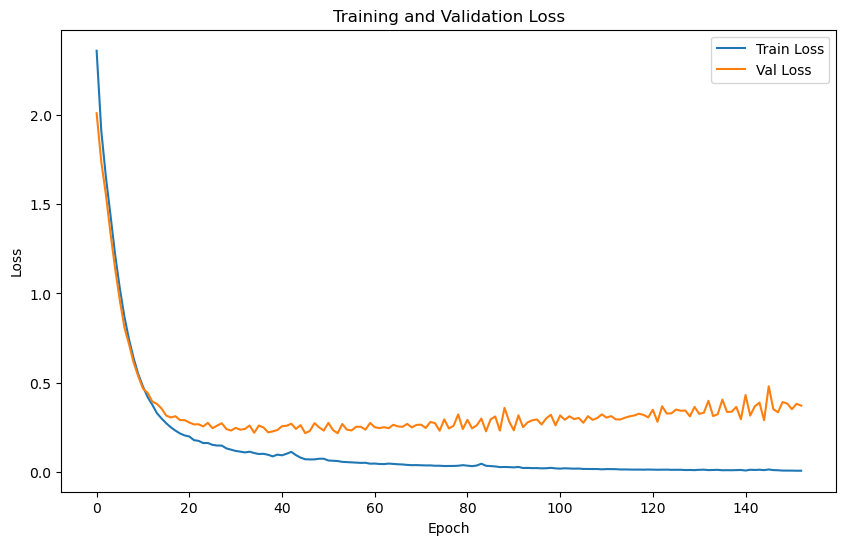

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.2037 | Test Accuracy: 95.13%


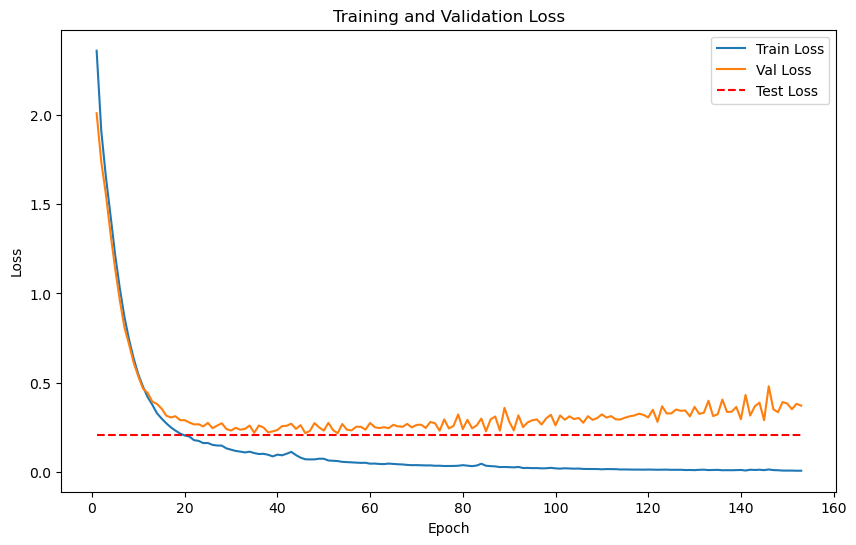

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147747, 64), 
Test labels shape: (147747,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 8.4749


    Batch [2/2], Train Loss: 8.3688
Epoch [1/2000], Avg Train Loss: 8.4219
Epoch [1/2000], Avg Val Loss: 3.9103
Validation loss improved from inf to 3.9103. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.3847
    Batch [2/2], Train Loss: 8.2418
Epoch [2/2000], Avg Train Loss: 8.3132
Epoch [2/2000], Avg Val Loss: 3.8232
Validation loss improved from 3.9103 to 3.8232. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 7.8686
    Batch [2/2], Train Loss: 7.8377
Epoch [3/2000], Avg Train Loss: 7.8532
Epoch [3/2000], Avg Val Loss: 3.7416
Validation loss improved from 3.8232 to 3.7416. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.9315
    Batch [2/2], Train Loss: 8.0711
Epoch [4/2000], Avg Train Loss: 8.0013
Epoch [4/2000], Avg Val Loss: 3.6648
Validation loss improved from 3.7416 to 3.6648. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 7.6858
    Batch [2/2], Train Loss

    Batch [2/2], Train Loss: 7.4189
Epoch [8/2000], Avg Train Loss: 7.3977
Epoch [8/2000], Avg Val Loss: 3.4004
Validation loss improved from 3.4605 to 3.4004. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/2], Train Loss: 7.3165
    Batch [2/2], Train Loss: 7.1389
Epoch [9/2000], Avg Train Loss: 7.2277
Epoch [9/2000], Avg Val Loss: 3.3443
Validation loss improved from 3.4004 to 3.3443. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 7.0168
    Batch [2/2], Train Loss: 7.0324
Epoch [10/2000], Avg Train Loss: 7.0246
Epoch [10/2000], Avg Val Loss: 3.2922
Validation loss improved from 3.3443 to 3.2922. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 6.9795
    Batch [2/2], Train Loss: 6.8144
Epoch [11/2000], Avg Train Loss: 6.8969
Epoch [11/2000], Avg Val Loss: 3.2438
Validation loss improved from 3.2922 to 3.2438. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 6.8536
    Batch [2/2], 

    Batch [2/2], Train Loss: 5.4154
Epoch [29/2000], Avg Train Loss: 5.4491
Epoch [29/2000], Avg Val Loss: 2.8126
Validation loss improved from 2.8232 to 2.8126. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 5.3628
    Batch [2/2], Train Loss: 5.3941
Epoch [30/2000], Avg Train Loss: 5.3784
Epoch [30/2000], Avg Val Loss: 2.8026
Validation loss improved from 2.8126 to 2.8026. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 5.2783
    Batch [2/2], Train Loss: 5.2647
Epoch [31/2000], Avg Train Loss: 5.2715
Epoch [31/2000], Avg Val Loss: 2.7933
Validation loss improved from 2.8026 to 2.7933. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 5.2902
    Batch [2/2], Train Loss: 5.1163
Epoch [32/2000], Avg Train Loss: 5.2032
Epoch [32/2000], Avg Val Loss: 2.7846
Validation loss improved from 2.7933 to 2.7846. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 5.2195
    Batch [2

Epoch [33/2000], Avg Val Loss: 2.7767
Validation loss improved from 2.7846 to 2.7767. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.1518
    Batch [2/2], Train Loss: 5.2050
Epoch [34/2000], Avg Train Loss: 5.1784
Epoch [34/2000], Avg Val Loss: 2.7693
Validation loss improved from 2.7767 to 2.7693. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.1869
    Batch [2/2], Train Loss: 5.0501
Epoch [35/2000], Avg Train Loss: 5.1185
Epoch [35/2000], Avg Val Loss: 2.7624
Validation loss improved from 2.7693 to 2.7624. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.2192
    Batch [2/2], Train Loss: 5.1905
Epoch [36/2000], Avg Train Loss: 5.2049
Epoch [36/2000], Avg Val Loss: 2.7558
Validation loss improved from 2.7624 to 2.7558. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 5.0582
    Batch [2/2], Train Loss: 4.9919
Epoch [37/2000], Avg Train Loss: 5.0250
Epoch [37/20

    Batch [2/2], Train Loss: 4.6865
Epoch [53/2000], Avg Train Loss: 4.7096
Epoch [53/2000], Avg Val Loss: 2.6775
Validation loss improved from 2.6814 to 2.6775. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 4.7445
    Batch [2/2], Train Loss: 4.7022
Epoch [54/2000], Avg Train Loss: 4.7233
Epoch [54/2000], Avg Val Loss: 2.6738
Validation loss improved from 2.6775 to 2.6738. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 4.6809
    Batch [2/2], Train Loss: 4.6187
Epoch [55/2000], Avg Train Loss: 4.6498
Epoch [55/2000], Avg Val Loss: 2.6701
Validation loss improved from 2.6738 to 2.6701. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 4.7131
    Batch [2/2], Train Loss: 4.6306
Epoch [56/2000], Avg Train Loss: 4.6718
Epoch [56/2000], Avg Val Loss: 2.6663
Validation loss improved from 2.6701 to 2.6663. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 4.7262
    Batch [2

    Batch [2/2], Train Loss: 4.6011
Epoch [59/2000], Avg Train Loss: 4.5803
Epoch [59/2000], Avg Val Loss: 2.6554
Validation loss improved from 2.6590 to 2.6554. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 4.5755
    Batch [2/2], Train Loss: 4.6057
Epoch [60/2000], Avg Train Loss: 4.5906
Epoch [60/2000], Avg Val Loss: 2.6519
Validation loss improved from 2.6554 to 2.6519. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 4.5496
    Batch [2/2], Train Loss: 4.5384
Epoch [61/2000], Avg Train Loss: 4.5440
Epoch [61/2000], Avg Val Loss: 2.6484
Validation loss improved from 2.6519 to 2.6484. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 4.6362
    Batch [2/2], Train Loss: 4.5148
Epoch [62/2000], Avg Train Loss: 4.5755
Epoch [62/2000], Avg Val Loss: 2.6448
Validation loss improved from 2.6484 to 2.6448. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 4.5837
    Batch [2

    Batch [1/2], Train Loss: 4.4123
    Batch [2/2], Train Loss: 4.3846
Epoch [80/2000], Avg Train Loss: 4.3985
Epoch [80/2000], Avg Val Loss: 2.5833
Validation loss improved from 2.5864 to 2.5833. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 4.3435
    Batch [2/2], Train Loss: 4.3638
Epoch [81/2000], Avg Train Loss: 4.3536
Epoch [81/2000], Avg Val Loss: 2.5801
Validation loss improved from 2.5833 to 2.5801. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 4.4413
    Batch [2/2], Train Loss: 4.3875
Epoch [82/2000], Avg Train Loss: 4.4144
Epoch [82/2000], Avg Val Loss: 2.5769
Validation loss improved from 2.5801 to 2.5769. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 4.3557
    Batch [2/2], Train Loss: 4.3381
Epoch [83/2000], Avg Train Loss: 4.3469
Epoch [83/2000], Avg Val Loss: 2.5739
Validation loss improved from 2.5769 to 2.5739. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.3341
    Batch [2/2], Train Loss: 4.3406
Epoch [85/2000], Avg Train Loss: 4.3374
Epoch [85/2000], Avg Val Loss: 2.5678
Validation loss improved from 2.5709 to 2.5678. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 4.3281
    Batch [2/2], Train Loss: 4.3755
Epoch [86/2000], Avg Train Loss: 4.3518
Epoch [86/2000], Avg Val Loss: 2.5648
Validation loss improved from 2.5678 to 2.5648. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 4.3250
    Batch [2/2], Train Loss: 4.4089
Epoch [87/2000], Avg Train Loss: 4.3669
Epoch [87/2000], Avg Val Loss: 2.5619
Validation loss improved from 2.5648 to 2.5619. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 4.3318
    Batch [2/2], Train Loss: 4.3463
Epoch [88/2000], Avg Train Loss: 4.3391
Epoch [88/2000], Avg Val Loss: 2.5589
Validation loss improved from 2.5619 to 2.5589. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.2740
Epoch [106/2000], Avg Train Loss: 4.2566
Epoch [106/2000], Avg Val Loss: 2.5119
Validation loss improved from 2.5143 to 2.5119. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 4.2492
    Batch [2/2], Train Loss: 4.1541
Epoch [107/2000], Avg Train Loss: 4.2016
Epoch [107/2000], Avg Val Loss: 2.5095
Validation loss improved from 2.5119 to 2.5095. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 4.2814
    Batch [2/2], Train Loss: 4.1948
Epoch [108/2000], Avg Train Loss: 4.2381
Epoch [108/2000], Avg Val Loss: 2.5071
Validation loss improved from 2.5095 to 2.5071. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 4.2592
    Batch [2/2], Train Loss: 4.2309
Epoch [109/2000], Avg Train Loss: 4.2450
Epoch [109/2000], Avg Val Loss: 2.5047
Validation loss improved from 2.5071 to 2.5047. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 4.1990


    Batch [2/2], Train Loss: 4.1357
Epoch [132/2000], Avg Train Loss: 4.1225
Epoch [132/2000], Avg Val Loss: 2.4559
Validation loss improved from 2.4578 to 2.4559. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 4.1204
    Batch [2/2], Train Loss: 4.1262
Epoch [133/2000], Avg Train Loss: 4.1233
Epoch [133/2000], Avg Val Loss: 2.4539
Validation loss improved from 2.4559 to 2.4539. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 4.1116
    Batch [2/2], Train Loss: 4.1046
Epoch [134/2000], Avg Train Loss: 4.1081
Epoch [134/2000], Avg Val Loss: 2.4521
Validation loss improved from 2.4539 to 2.4521. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 4.1170
    Batch [2/2], Train Loss: 4.1113
Epoch [135/2000], Avg Train Loss: 4.1142
Epoch [135/2000], Avg Val Loss: 2.4502
Validation loss improved from 2.4521 to 2.4502. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 4.0921


    Batch [2/2], Train Loss: 4.0088
Epoch [156/2000], Avg Train Loss: 4.0398
Epoch [156/2000], Avg Val Loss: 2.4164
Validation loss improved from 2.4179 to 2.4164. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 4.0577
    Batch [2/2], Train Loss: 3.9818
Epoch [157/2000], Avg Train Loss: 4.0198
Epoch [157/2000], Avg Val Loss: 2.4150
Validation loss improved from 2.4164 to 2.4150. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 4.0387
    Batch [2/2], Train Loss: 4.0783
Epoch [158/2000], Avg Train Loss: 4.0585
Epoch [158/2000], Avg Val Loss: 2.4136
Validation loss improved from 2.4150 to 2.4136. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 4.0850
    Batch [2/2], Train Loss: 4.0124
Epoch [159/2000], Avg Train Loss: 4.0487
Epoch [159/2000], Avg Val Loss: 2.4123
Validation loss improved from 2.4136 to 2.4123. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 4.0011


    Batch [1/2], Train Loss: 3.9185
    Batch [2/2], Train Loss: 3.9725
Epoch [181/2000], Avg Train Loss: 3.9455
Epoch [181/2000], Avg Val Loss: 2.3824
Validation loss improved from 2.3837 to 2.3824. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 3.9532
    Batch [2/2], Train Loss: 3.9220
Epoch [182/2000], Avg Train Loss: 3.9376
Epoch [182/2000], Avg Val Loss: 2.3811
Validation loss improved from 2.3824 to 2.3811. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 3.9762
    Batch [2/2], Train Loss: 3.9021
Epoch [183/2000], Avg Train Loss: 3.9391
Epoch [183/2000], Avg Val Loss: 2.3797
Validation loss improved from 2.3811 to 2.3797. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 3.9820
    Batch [2/2], Train Loss: 3.9621
Epoch [184/2000], Avg Train Loss: 3.9721
Epoch [184/2000], Avg Val Loss: 2.3785
Validation loss improved from 2.3797 to 2.3785. Saving model...

LOG: Epoch [185/2000] - Training


    Batch [2/2], Train Loss: 3.9314
Epoch [205/2000], Avg Train Loss: 3.9489
Epoch [205/2000], Avg Val Loss: 2.3542
Validation loss improved from 2.3553 to 2.3542. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 3.8870
    Batch [2/2], Train Loss: 3.9011
Epoch [206/2000], Avg Train Loss: 3.8941
Epoch [206/2000], Avg Val Loss: 2.3531
Validation loss improved from 2.3542 to 2.3531. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 3.9158
    Batch [2/2], Train Loss: 3.8771
Epoch [207/2000], Avg Train Loss: 3.8964
Epoch [207/2000], Avg Val Loss: 2.3520
Validation loss improved from 2.3531 to 2.3520. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 3.9361
    Batch [2/2], Train Loss: 3.8814
Epoch [208/2000], Avg Train Loss: 3.9088
Epoch [208/2000], Avg Val Loss: 2.3509
Validation loss improved from 2.3520 to 2.3509. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 3.9532


    Batch [2/2], Train Loss: 3.8591
Epoch [231/2000], Avg Train Loss: 3.8762
Epoch [231/2000], Avg Val Loss: 2.3274
Validation loss improved from 2.3283 to 2.3274. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 3.8876
    Batch [2/2], Train Loss: 3.8626
Epoch [232/2000], Avg Train Loss: 3.8751
Epoch [232/2000], Avg Val Loss: 2.3265
Validation loss improved from 2.3274 to 2.3265. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 3.8469
    Batch [2/2], Train Loss: 3.8555
Epoch [233/2000], Avg Train Loss: 3.8512
Epoch [233/2000], Avg Val Loss: 2.3256
Validation loss improved from 2.3265 to 2.3256. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 3.8638
    Batch [2/2], Train Loss: 3.8074
Epoch [234/2000], Avg Train Loss: 3.8356
Epoch [234/2000], Avg Val Loss: 2.3247
Validation loss improved from 2.3256 to 2.3247. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 3.8556


Epoch [254/2000], Avg Val Loss: 2.3061
Validation loss improved from 2.3070 to 2.3061. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 3.8126
    Batch [2/2], Train Loss: 3.8230
Epoch [255/2000], Avg Train Loss: 3.8178
Epoch [255/2000], Avg Val Loss: 2.3052
Validation loss improved from 2.3061 to 2.3052. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 3.8397
    Batch [2/2], Train Loss: 3.7949
Epoch [256/2000], Avg Train Loss: 3.8173
Epoch [256/2000], Avg Val Loss: 2.3044
Validation loss improved from 2.3052 to 2.3044. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 3.7880
    Batch [2/2], Train Loss: 3.8805
Epoch [257/2000], Avg Train Loss: 3.8342
Epoch [257/2000], Avg Val Loss: 2.3035
Validation loss improved from 2.3044 to 2.3035. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 3.8294
    Batch [2/2], Train Loss: 3.7907
Epoch [258/2000], Avg Train Loss: 3.8100


    Batch [1/2], Train Loss: 3.8091
    Batch [2/2], Train Loss: 3.8134
Epoch [278/2000], Avg Train Loss: 3.8113
Epoch [278/2000], Avg Val Loss: 2.2881
Validation loss improved from 2.2889 to 2.2881. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 3.7943
    Batch [2/2], Train Loss: 3.7539
Epoch [279/2000], Avg Train Loss: 3.7741
Epoch [279/2000], Avg Val Loss: 2.2872
Validation loss improved from 2.2881 to 2.2872. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 3.7736
    Batch [2/2], Train Loss: 3.8204
Epoch [280/2000], Avg Train Loss: 3.7970
Epoch [280/2000], Avg Val Loss: 2.2864
Validation loss improved from 2.2872 to 2.2864. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 3.8141
    Batch [2/2], Train Loss: 3.7880
Epoch [281/2000], Avg Train Loss: 3.8011
Epoch [281/2000], Avg Val Loss: 2.2856
Validation loss improved from 2.2864 to 2.2856. Saving model...

LOG: Epoch [282/2000] - Training


    Batch [2/2], Train Loss: 3.7638
Epoch [302/2000], Avg Train Loss: 3.7675
Epoch [302/2000], Avg Val Loss: 2.2710
Validation loss improved from 2.2716 to 2.2710. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 3.7557
    Batch [2/2], Train Loss: 3.7280
Epoch [303/2000], Avg Train Loss: 3.7419
Epoch [303/2000], Avg Val Loss: 2.2704
Validation loss improved from 2.2710 to 2.2704. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 3.7473
    Batch [2/2], Train Loss: 3.7495
Epoch [304/2000], Avg Train Loss: 3.7484
Epoch [304/2000], Avg Val Loss: 2.2698
Validation loss improved from 2.2704 to 2.2698. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 3.7086
    Batch [2/2], Train Loss: 3.8102
Epoch [305/2000], Avg Train Loss: 3.7594
Epoch [305/2000], Avg Val Loss: 2.2691
Validation loss improved from 2.2698 to 2.2691. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 3.7517


    Batch [1/2], Train Loss: 3.7196
    Batch [2/2], Train Loss: 3.7223
Epoch [317/2000], Avg Train Loss: 3.7210
Epoch [317/2000], Avg Val Loss: 2.2613
Validation loss improved from 2.2618 to 2.2613. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 3.7344
    Batch [2/2], Train Loss: 3.7101
Epoch [318/2000], Avg Train Loss: 3.7223
Epoch [318/2000], Avg Val Loss: 2.2608
Validation loss improved from 2.2613 to 2.2608. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 3.6875
    Batch [2/2], Train Loss: 3.7013
Epoch [319/2000], Avg Train Loss: 3.6944
Epoch [319/2000], Avg Val Loss: 2.2603
Validation loss improved from 2.2608 to 2.2603. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 3.7024
    Batch [2/2], Train Loss: 3.7125
Epoch [320/2000], Avg Train Loss: 3.7075
Epoch [320/2000], Avg Val Loss: 2.2598
Validation loss improved from 2.2603 to 2.2598. Saving model...

LOG: Epoch [321/2000] - Training


Epoch [340/2000], Avg Val Loss: 2.2484
Validation loss improved from 2.2489 to 2.2484. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 3.7362
    Batch [2/2], Train Loss: 3.6856
Epoch [341/2000], Avg Train Loss: 3.7109
Epoch [341/2000], Avg Val Loss: 2.2479
Validation loss improved from 2.2484 to 2.2479. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 3.6762
    Batch [2/2], Train Loss: 3.7221
Epoch [342/2000], Avg Train Loss: 3.6992
Epoch [342/2000], Avg Val Loss: 2.2475
Validation loss improved from 2.2479 to 2.2475. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 3.6605
    Batch [2/2], Train Loss: 3.6849
Epoch [343/2000], Avg Train Loss: 3.6727
Epoch [343/2000], Avg Val Loss: 2.2470
Validation loss improved from 2.2475 to 2.2470. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 3.6420
    Batch [2/2], Train Loss: 3.7026
Epoch [344/2000], Avg Train Loss: 3.6723


    Batch [1/2], Train Loss: 3.6463
    Batch [2/2], Train Loss: 3.6683
Epoch [366/2000], Avg Train Loss: 3.6573
Epoch [366/2000], Avg Val Loss: 2.2372
Validation loss improved from 2.2377 to 2.2372. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 3.6694
    Batch [2/2], Train Loss: 3.6774
Epoch [367/2000], Avg Train Loss: 3.6734
Epoch [367/2000], Avg Val Loss: 2.2367
Validation loss improved from 2.2372 to 2.2367. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 3.6927
    Batch [2/2], Train Loss: 3.6930
Epoch [368/2000], Avg Train Loss: 3.6929
Epoch [368/2000], Avg Val Loss: 2.2361
Validation loss improved from 2.2367 to 2.2361. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 3.7021
    Batch [2/2], Train Loss: 3.6683
Epoch [369/2000], Avg Train Loss: 3.6852
Epoch [369/2000], Avg Val Loss: 2.2356
Validation loss improved from 2.2361 to 2.2356. Saving model...

LOG: Epoch [370/2000] - Training


    Batch [2/2], Train Loss: 3.6036
Epoch [391/2000], Avg Train Loss: 3.6482
Epoch [391/2000], Avg Val Loss: 2.2240
Validation loss improved from 2.2245 to 2.2240. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 3.6308
    Batch [2/2], Train Loss: 3.6739
Epoch [392/2000], Avg Train Loss: 3.6523
Epoch [392/2000], Avg Val Loss: 2.2234
Validation loss improved from 2.2240 to 2.2234. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 3.6294
    Batch [2/2], Train Loss: 3.5937
Epoch [393/2000], Avg Train Loss: 3.6116
Epoch [393/2000], Avg Val Loss: 2.2228
Validation loss improved from 2.2234 to 2.2228. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 3.6108
    Batch [2/2], Train Loss: 3.6197
Epoch [394/2000], Avg Train Loss: 3.6152
Epoch [394/2000], Avg Val Loss: 2.2223
Validation loss improved from 2.2228 to 2.2223. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 3.6168


    Batch [2/2], Train Loss: 3.6538
Epoch [415/2000], Avg Train Loss: 3.6312
Epoch [415/2000], Avg Val Loss: 2.2142
Validation loss improved from 2.2146 to 2.2142. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 3.6033
    Batch [2/2], Train Loss: 3.5997
Epoch [416/2000], Avg Train Loss: 3.6015
Epoch [416/2000], Avg Val Loss: 2.2139
Validation loss improved from 2.2142 to 2.2139. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 3.6258
    Batch [2/2], Train Loss: 3.6525
Epoch [417/2000], Avg Train Loss: 3.6391
Epoch [417/2000], Avg Val Loss: 2.2136
Validation loss improved from 2.2139 to 2.2136. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 3.6355
    Batch [2/2], Train Loss: 3.6112
Epoch [418/2000], Avg Train Loss: 3.6233
Epoch [418/2000], Avg Val Loss: 2.2134
Validation loss improved from 2.2136 to 2.2134. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 3.6641


Epoch [440/2000], Avg Val Loss: 2.2062
Validation loss improved from 2.2067 to 2.2062. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 3.5672
    Batch [2/2], Train Loss: 3.5987
Epoch [441/2000], Avg Train Loss: 3.5829
Epoch [441/2000], Avg Val Loss: 2.2057
Validation loss improved from 2.2062 to 2.2057. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 3.5851
    Batch [2/2], Train Loss: 3.5621
Epoch [442/2000], Avg Train Loss: 3.5736
Epoch [442/2000], Avg Val Loss: 2.2053
Validation loss improved from 2.2057 to 2.2053. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 3.6131
    Batch [2/2], Train Loss: 3.5806
Epoch [443/2000], Avg Train Loss: 3.5969
Epoch [443/2000], Avg Val Loss: 2.2049
Validation loss improved from 2.2053 to 2.2049. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 3.6151
    Batch [2/2], Train Loss: 3.5754
Epoch [444/2000], Avg Train Loss: 3.5953


    Batch [1/2], Train Loss: 3.5707
    Batch [2/2], Train Loss: 3.6056
Epoch [465/2000], Avg Train Loss: 3.5881
Epoch [465/2000], Avg Val Loss: 2.1977
Validation loss improved from 2.1978 to 2.1977. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 3.5902
    Batch [2/2], Train Loss: 3.6033
Epoch [466/2000], Avg Train Loss: 3.5967
Epoch [466/2000], Avg Val Loss: 2.1975
Validation loss improved from 2.1977 to 2.1975. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 3.5521
    Batch [2/2], Train Loss: 3.5710
Epoch [467/2000], Avg Train Loss: 3.5615
Epoch [467/2000], Avg Val Loss: 2.1974
Validation loss improved from 2.1975 to 2.1974. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 3.6113
    Batch [2/2], Train Loss: 3.5881
Epoch [468/2000], Avg Train Loss: 3.5997
Epoch [468/2000], Avg Val Loss: 2.1972
Validation loss improved from 2.1974 to 2.1972. Saving model...

LOG: Epoch [469/2000] - Training


    Batch [1/2], Train Loss: 3.5737
    Batch [2/2], Train Loss: 3.5283
Epoch [489/2000], Avg Train Loss: 3.5510
Epoch [489/2000], Avg Val Loss: 2.1903
Validation loss improved from 2.1906 to 2.1903. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 3.5538
    Batch [2/2], Train Loss: 3.5327
Epoch [490/2000], Avg Train Loss: 3.5433
Epoch [490/2000], Avg Val Loss: 2.1901
Validation loss improved from 2.1903 to 2.1901. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 3.5352
    Batch [2/2], Train Loss: 3.5543
Epoch [491/2000], Avg Train Loss: 3.5447
Epoch [491/2000], Avg Val Loss: 2.1900
Validation loss improved from 2.1901 to 2.1900. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 3.5809
    Batch [2/2], Train Loss: 3.5666
Epoch [492/2000], Avg Train Loss: 3.5738
Epoch [492/2000], Avg Val Loss: 2.1898
Validation loss improved from 2.1900 to 2.1898. Saving model...

LOG: Epoch [493/2000] - Training


    Batch [2/2], Train Loss: 3.5286
Epoch [514/2000], Avg Train Loss: 3.5378
Epoch [514/2000], Avg Val Loss: 2.1823
Validation loss improved from 2.1825 to 2.1823. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 3.5458
    Batch [2/2], Train Loss: 3.5462
Epoch [515/2000], Avg Train Loss: 3.5460
Epoch [515/2000], Avg Val Loss: 2.1822
Validation loss improved from 2.1823 to 2.1822. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 3.5188
    Batch [2/2], Train Loss: 3.5434
Epoch [516/2000], Avg Train Loss: 3.5311
Epoch [516/2000], Avg Val Loss: 2.1820
Validation loss improved from 2.1822 to 2.1820. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 3.4901
    Batch [2/2], Train Loss: 3.5427
Epoch [517/2000], Avg Train Loss: 3.5164
Epoch [517/2000], Avg Val Loss: 2.1818
Validation loss improved from 2.1820 to 2.1818. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 3.5765


    Batch [2/2], Train Loss: 3.5049
Epoch [540/2000], Avg Train Loss: 3.5069
Epoch [540/2000], Avg Val Loss: 2.1777
Validation loss improved from 2.1779 to 2.1777. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 3.5400
    Batch [2/2], Train Loss: 3.5367
Epoch [541/2000], Avg Train Loss: 3.5383
Epoch [541/2000], Avg Val Loss: 2.1776
Validation loss improved from 2.1777 to 2.1776. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 3.5455
    Batch [2/2], Train Loss: 3.4898
Epoch [542/2000], Avg Train Loss: 3.5177
Epoch [542/2000], Avg Val Loss: 2.1774
Validation loss improved from 2.1776 to 2.1774. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 3.5029
    Batch [2/2], Train Loss: 3.5322
Epoch [543/2000], Avg Train Loss: 3.5176
Epoch [543/2000], Avg Val Loss: 2.1770
Validation loss improved from 2.1774 to 2.1770. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 3.5829


Epoch [566/2000], Avg Train Loss: 3.5282
Epoch [566/2000], Avg Val Loss: 2.1742
Validation loss improved from 2.1743 to 2.1742. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/2], Train Loss: 3.5111
    Batch [2/2], Train Loss: 3.5524
Epoch [567/2000], Avg Train Loss: 3.5318
Epoch [567/2000], Avg Val Loss: 2.1741
Validation loss improved from 2.1742 to 2.1741. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 3.5299
    Batch [2/2], Train Loss: 3.4916
Epoch [568/2000], Avg Train Loss: 3.5107
Epoch [568/2000], Avg Val Loss: 2.1740
Validation loss improved from 2.1741 to 2.1740. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/2], Train Loss: 3.5527
    Batch [2/2], Train Loss: 3.5267
Epoch [569/2000], Avg Train Loss: 3.5397
Epoch [569/2000], Avg Val Loss: 2.1739
Validation loss improved from 2.1740 to 2.1739. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/2], Train Loss: 3.5190
    Batch [2/2], Train Loss: 3.5218


    Batch [2/2], Train Loss: 3.5059
Epoch [588/2000], Avg Train Loss: 3.4950
Epoch [588/2000], Avg Val Loss: 2.1721
Validation loss improved from 2.1721 to 2.1721. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/2], Train Loss: 3.4641
    Batch [2/2], Train Loss: 3.4795
Epoch [589/2000], Avg Train Loss: 3.4718
Epoch [589/2000], Avg Val Loss: 2.1718
Validation loss improved from 2.1721 to 2.1718. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/2], Train Loss: 3.4447
    Batch [2/2], Train Loss: 3.5326
Epoch [590/2000], Avg Train Loss: 3.4887
Epoch [590/2000], Avg Val Loss: 2.1715
Validation loss improved from 2.1718 to 2.1715. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 3.5211
    Batch [2/2], Train Loss: 3.4846
Epoch [591/2000], Avg Train Loss: 3.5029
Epoch [591/2000], Avg Val Loss: 2.1712
Validation loss improved from 2.1715 to 2.1712. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/2], Train Loss: 3.4810


    Batch [2/2], Train Loss: 3.4497
Epoch [612/2000], Avg Train Loss: 3.4743
Epoch [612/2000], Avg Val Loss: 2.1709
Validation loss did not improve. Patience: 14/100

LOG: Epoch [613/2000] - Training
    Batch [1/2], Train Loss: 3.4783
    Batch [2/2], Train Loss: 3.4573
Epoch [613/2000], Avg Train Loss: 3.4678
Epoch [613/2000], Avg Val Loss: 2.1709
Validation loss did not improve. Patience: 15/100

LOG: Epoch [614/2000] - Training
    Batch [1/2], Train Loss: 3.4623
    Batch [2/2], Train Loss: 3.5006
Epoch [614/2000], Avg Train Loss: 3.4815
Epoch [614/2000], Avg Val Loss: 2.1709
Validation loss did not improve. Patience: 16/100

LOG: Epoch [615/2000] - Training
    Batch [1/2], Train Loss: 3.5173
    Batch [2/2], Train Loss: 3.4689
Epoch [615/2000], Avg Train Loss: 3.4931
Epoch [615/2000], Avg Val Loss: 2.1710
Validation loss did not improve. Patience: 17/100

LOG: Epoch [616/2000] - Training
    Batch [1/2], Train Loss: 3.4261
    Batch [2/2], Train Loss: 3.4842
Epoch [616/2000], Av

    Batch [2/2], Train Loss: 3.4512
Epoch [636/2000], Avg Train Loss: 3.4534
Epoch [636/2000], Avg Val Loss: 2.1675
Validation loss did not improve. Patience: 5/100

LOG: Epoch [637/2000] - Training
    Batch [1/2], Train Loss: 3.4442
    Batch [2/2], Train Loss: 3.4495
Epoch [637/2000], Avg Train Loss: 3.4469
Epoch [637/2000], Avg Val Loss: 2.1677
Validation loss did not improve. Patience: 6/100

LOG: Epoch [638/2000] - Training
    Batch [1/2], Train Loss: 3.4332
    Batch [2/2], Train Loss: 3.5071
Epoch [638/2000], Avg Train Loss: 3.4701
Epoch [638/2000], Avg Val Loss: 2.1678
Validation loss did not improve. Patience: 7/100

LOG: Epoch [639/2000] - Training
    Batch [1/2], Train Loss: 3.4388
    Batch [2/2], Train Loss: 3.4102
Epoch [639/2000], Avg Train Loss: 3.4245
Epoch [639/2000], Avg Val Loss: 2.1680
Validation loss did not improve. Patience: 8/100

LOG: Epoch [640/2000] - Training
    Batch [1/2], Train Loss: 3.4640
    Batch [2/2], Train Loss: 3.4213
Epoch [640/2000], Avg Tr

    Batch [2/2], Train Loss: 3.4824
Epoch [662/2000], Avg Train Loss: 3.4618
Epoch [662/2000], Avg Val Loss: 2.1665
Validation loss improved from 2.1670 to 2.1665. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/2], Train Loss: 3.4596
    Batch [2/2], Train Loss: 3.4655
Epoch [663/2000], Avg Train Loss: 3.4625
Epoch [663/2000], Avg Val Loss: 2.1661
Validation loss improved from 2.1665 to 2.1661. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/2], Train Loss: 3.4206
    Batch [2/2], Train Loss: 3.4245
Epoch [664/2000], Avg Train Loss: 3.4226
Epoch [664/2000], Avg Val Loss: 2.1657
Validation loss improved from 2.1661 to 2.1657. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/2], Train Loss: 3.4311
    Batch [2/2], Train Loss: 3.4527
Epoch [665/2000], Avg Train Loss: 3.4419
Epoch [665/2000], Avg Val Loss: 2.1655
Validation loss improved from 2.1657 to 2.1655. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/2], Train Loss: 3.4454


    Batch [1/2], Train Loss: 3.4456
    Batch [2/2], Train Loss: 3.4300
Epoch [689/2000], Avg Train Loss: 3.4378
Epoch [689/2000], Avg Val Loss: 2.1592
Validation loss did not improve. Patience: 3/100

LOG: Epoch [690/2000] - Training
    Batch [1/2], Train Loss: 3.3942
    Batch [2/2], Train Loss: 3.4435
Epoch [690/2000], Avg Train Loss: 3.4188
Epoch [690/2000], Avg Val Loss: 2.1594
Validation loss did not improve. Patience: 4/100

LOG: Epoch [691/2000] - Training
    Batch [1/2], Train Loss: 3.4686
    Batch [2/2], Train Loss: 3.4444
Epoch [691/2000], Avg Train Loss: 3.4565
Epoch [691/2000], Avg Val Loss: 2.1597
Validation loss did not improve. Patience: 5/100

LOG: Epoch [692/2000] - Training
    Batch [1/2], Train Loss: 3.4597
    Batch [2/2], Train Loss: 3.4058
Epoch [692/2000], Avg Train Loss: 3.4328
Epoch [692/2000], Avg Val Loss: 2.1597
Validation loss did not improve. Patience: 6/100

LOG: Epoch [693/2000] - Training
    Batch [1/2], Train Loss: 3.4510
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.4451
Epoch [712/2000], Avg Train Loss: 3.4523
Epoch [712/2000], Avg Val Loss: 2.1616
Validation loss did not improve. Patience: 26/100

LOG: Epoch [713/2000] - Training
    Batch [1/2], Train Loss: 3.4066
    Batch [2/2], Train Loss: 3.4379
Epoch [713/2000], Avg Train Loss: 3.4222
Epoch [713/2000], Avg Val Loss: 2.1617
Validation loss did not improve. Patience: 27/100

LOG: Epoch [714/2000] - Training
    Batch [1/2], Train Loss: 3.4425
    Batch [2/2], Train Loss: 3.4325
Epoch [714/2000], Avg Train Loss: 3.4375
Epoch [714/2000], Avg Val Loss: 2.1616
Validation loss did not improve. Patience: 28/100

LOG: Epoch [715/2000] - Training
    Batch [1/2], Train Loss: 3.4252
    Batch [2/2], Train Loss: 3.4678
Epoch [715/2000], Avg Train Loss: 3.4465
Epoch [715/2000], Avg Val Loss: 2.1617
Validation loss did not improve. Patience: 29/100

LOG: Epoch [716/2000] - Training
    Batch [1/2], Train Loss: 3.4495
    Batch [2/2], Train Loss: 3.4482
Epoch [716/2000], Av

    Batch [1/2], Train Loss: 3.4348
    Batch [2/2], Train Loss: 3.4093
Epoch [738/2000], Avg Train Loss: 3.4220
Epoch [738/2000], Avg Val Loss: 2.1603
Validation loss did not improve. Patience: 52/100

LOG: Epoch [739/2000] - Training
    Batch [1/2], Train Loss: 3.4406
    Batch [2/2], Train Loss: 3.4180
Epoch [739/2000], Avg Train Loss: 3.4293
Epoch [739/2000], Avg Val Loss: 2.1606
Validation loss did not improve. Patience: 53/100

LOG: Epoch [740/2000] - Training
    Batch [1/2], Train Loss: 3.3924
    Batch [2/2], Train Loss: 3.4147
Epoch [740/2000], Avg Train Loss: 3.4036
Epoch [740/2000], Avg Val Loss: 2.1607
Validation loss did not improve. Patience: 54/100

LOG: Epoch [741/2000] - Training
    Batch [1/2], Train Loss: 3.4514
    Batch [2/2], Train Loss: 3.3653
Epoch [741/2000], Avg Train Loss: 3.4084
Epoch [741/2000], Avg Val Loss: 2.1607
Validation loss did not improve. Patience: 55/100

LOG: Epoch [742/2000] - Training
    Batch [1/2], Train Loss: 3.4335
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.4069
Epoch [763/2000], Avg Train Loss: 3.4142
Epoch [763/2000], Avg Val Loss: 2.1583
Validation loss improved from 2.1584 to 2.1583. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/2], Train Loss: 3.4191
    Batch [2/2], Train Loss: 3.4037
Epoch [764/2000], Avg Train Loss: 3.4114
Epoch [764/2000], Avg Val Loss: 2.1584
Validation loss did not improve. Patience: 1/100

LOG: Epoch [765/2000] - Training
    Batch [1/2], Train Loss: 3.3951
    Batch [2/2], Train Loss: 3.3998
Epoch [765/2000], Avg Train Loss: 3.3974
Epoch [765/2000], Avg Val Loss: 2.1585
Validation loss did not improve. Patience: 2/100

LOG: Epoch [766/2000] - Training
    Batch [1/2], Train Loss: 3.4412
    Batch [2/2], Train Loss: 3.4387
Epoch [766/2000], Avg Train Loss: 3.4399
Epoch [766/2000], Avg Val Loss: 2.1586
Validation loss did not improve. Patience: 3/100

LOG: Epoch [767/2000] - Training
    Batch [1/2], Train Loss: 3.4079
    Batch [2/2], Train Loss: 3.4175
Epoch [76

    Batch [1/2], Train Loss: 3.3370
    Batch [2/2], Train Loss: 3.4139
Epoch [789/2000], Avg Train Loss: 3.3754
Epoch [789/2000], Avg Val Loss: 2.1636
Validation loss did not improve. Patience: 19/100

LOG: Epoch [790/2000] - Training
    Batch [1/2], Train Loss: 3.4199
    Batch [2/2], Train Loss: 3.4155
Epoch [790/2000], Avg Train Loss: 3.4177
Epoch [790/2000], Avg Val Loss: 2.1636
Validation loss did not improve. Patience: 20/100

LOG: Epoch [791/2000] - Training
    Batch [1/2], Train Loss: 3.4221
    Batch [2/2], Train Loss: 3.3834
Epoch [791/2000], Avg Train Loss: 3.4028
Epoch [791/2000], Avg Val Loss: 2.1638
Validation loss did not improve. Patience: 21/100

LOG: Epoch [792/2000] - Training
    Batch [1/2], Train Loss: 3.4307
    Batch [2/2], Train Loss: 3.4162
Epoch [792/2000], Avg Train Loss: 3.4234
Epoch [792/2000], Avg Val Loss: 2.1641
Validation loss did not improve. Patience: 22/100

LOG: Epoch [793/2000] - Training
    Batch [1/2], Train Loss: 3.3924
    Batch [2/2], Tra

Epoch [812/2000], Avg Val Loss: 2.1664
Validation loss did not improve. Patience: 42/100

LOG: Epoch [813/2000] - Training
    Batch [1/2], Train Loss: 3.3996
    Batch [2/2], Train Loss: 3.4288
Epoch [813/2000], Avg Train Loss: 3.4142
Epoch [813/2000], Avg Val Loss: 2.1676
Validation loss did not improve. Patience: 43/100

LOG: Epoch [814/2000] - Training
    Batch [1/2], Train Loss: 3.3489
    Batch [2/2], Train Loss: 3.3778
Epoch [814/2000], Avg Train Loss: 3.3634
Epoch [814/2000], Avg Val Loss: 2.1688
Validation loss did not improve. Patience: 44/100

LOG: Epoch [815/2000] - Training
    Batch [1/2], Train Loss: 3.4087
    Batch [2/2], Train Loss: 3.3717
Epoch [815/2000], Avg Train Loss: 3.3902
Epoch [815/2000], Avg Val Loss: 2.1697
Validation loss did not improve. Patience: 45/100

LOG: Epoch [816/2000] - Training
    Batch [1/2], Train Loss: 3.3782
    Batch [2/2], Train Loss: 3.4386
Epoch [816/2000], Avg Train Loss: 3.4084
Epoch [816/2000], Avg Val Loss: 2.1707
Validation loss d

    Batch [2/2], Train Loss: 3.3821
Epoch [838/2000], Avg Train Loss: 3.3680
Epoch [838/2000], Avg Val Loss: 2.1602
Validation loss did not improve. Patience: 68/100

LOG: Epoch [839/2000] - Training
    Batch [1/2], Train Loss: 3.3909
    Batch [2/2], Train Loss: 3.3940
Epoch [839/2000], Avg Train Loss: 3.3925
Epoch [839/2000], Avg Val Loss: 2.1600
Validation loss did not improve. Patience: 69/100

LOG: Epoch [840/2000] - Training
    Batch [1/2], Train Loss: 3.3681
    Batch [2/2], Train Loss: 3.3482
Epoch [840/2000], Avg Train Loss: 3.3581
Epoch [840/2000], Avg Val Loss: 2.1600
Validation loss did not improve. Patience: 70/100

LOG: Epoch [841/2000] - Training
    Batch [1/2], Train Loss: 3.4042
    Batch [2/2], Train Loss: 3.3664
Epoch [841/2000], Avg Train Loss: 3.3853
Epoch [841/2000], Avg Val Loss: 2.1601
Validation loss did not improve. Patience: 71/100

LOG: Epoch [842/2000] - Training
    Batch [1/2], Train Loss: 3.3968
    Batch [2/2], Train Loss: 3.4049
Epoch [842/2000], Av

    Batch [2/2], Train Loss: 3.3667
Epoch [864/2000], Avg Train Loss: 3.3469
Epoch [864/2000], Avg Val Loss: 2.1566
Validation loss did not improve. Patience: 12/100

LOG: Epoch [865/2000] - Training
    Batch [1/2], Train Loss: 3.3921
    Batch [2/2], Train Loss: 3.3836
Epoch [865/2000], Avg Train Loss: 3.3879
Epoch [865/2000], Avg Val Loss: 2.1561
Validation loss improved from 2.1565 to 2.1561. Saving model...

LOG: Epoch [866/2000] - Training
    Batch [1/2], Train Loss: 3.3683
    Batch [2/2], Train Loss: 3.3681
Epoch [866/2000], Avg Train Loss: 3.3682
Epoch [866/2000], Avg Val Loss: 2.1558
Validation loss improved from 2.1561 to 2.1558. Saving model...

LOG: Epoch [867/2000] - Training
    Batch [1/2], Train Loss: 3.3229
    Batch [2/2], Train Loss: 3.3714
Epoch [867/2000], Avg Train Loss: 3.3471
Epoch [867/2000], Avg Val Loss: 2.1556
Validation loss improved from 2.1558 to 2.1556. Saving model...

LOG: Epoch [868/2000] - Training
    Batch [1/2], Train Loss: 3.3380
    Batch [2/2

    Batch [2/2], Train Loss: 3.3943
Epoch [889/2000], Avg Train Loss: 3.3862
Epoch [889/2000], Avg Val Loss: 2.1585
Validation loss did not improve. Patience: 15/100

LOG: Epoch [890/2000] - Training
    Batch [1/2], Train Loss: 3.3656
    Batch [2/2], Train Loss: 3.3971
Epoch [890/2000], Avg Train Loss: 3.3813
Epoch [890/2000], Avg Val Loss: 2.1580
Validation loss did not improve. Patience: 16/100

LOG: Epoch [891/2000] - Training
    Batch [1/2], Train Loss: 3.3713
    Batch [2/2], Train Loss: 3.2923
Epoch [891/2000], Avg Train Loss: 3.3318
Epoch [891/2000], Avg Val Loss: 2.1575
Validation loss did not improve. Patience: 17/100

LOG: Epoch [892/2000] - Training
    Batch [1/2], Train Loss: 3.3427
    Batch [2/2], Train Loss: 3.3688
Epoch [892/2000], Avg Train Loss: 3.3557
Epoch [892/2000], Avg Val Loss: 2.1572
Validation loss did not improve. Patience: 18/100

LOG: Epoch [893/2000] - Training
    Batch [1/2], Train Loss: 3.3606
    Batch [2/2], Train Loss: 3.3671
Epoch [893/2000], Av

    Batch [2/2], Train Loss: 3.3671
Epoch [912/2000], Avg Train Loss: 3.3635
Epoch [912/2000], Avg Val Loss: 2.1542
Validation loss did not improve. Patience: 38/100

LOG: Epoch [913/2000] - Training
    Batch [1/2], Train Loss: 3.3512
    Batch [2/2], Train Loss: 3.3741
Epoch [913/2000], Avg Train Loss: 3.3626
Epoch [913/2000], Avg Val Loss: 2.1542
Validation loss did not improve. Patience: 39/100

LOG: Epoch [914/2000] - Training
    Batch [1/2], Train Loss: 3.3449
    Batch [2/2], Train Loss: 3.3405
Epoch [914/2000], Avg Train Loss: 3.3427
Epoch [914/2000], Avg Val Loss: 2.1542
Validation loss did not improve. Patience: 40/100

LOG: Epoch [915/2000] - Training
    Batch [1/2], Train Loss: 3.3858
    Batch [2/2], Train Loss: 3.3069
Epoch [915/2000], Avg Train Loss: 3.3463
Epoch [915/2000], Avg Val Loss: 2.1542
Validation loss did not improve. Patience: 41/100

LOG: Epoch [916/2000] - Training
    Batch [1/2], Train Loss: 3.3304
    Batch [2/2], Train Loss: 3.3684
Epoch [916/2000], Av

Epoch [936/2000], Avg Val Loss: 2.1479
Validation loss did not improve. Patience: 2/100

LOG: Epoch [937/2000] - Training
    Batch [1/2], Train Loss: 3.3363
    Batch [2/2], Train Loss: 3.2972
Epoch [937/2000], Avg Train Loss: 3.3167
Epoch [937/2000], Avg Val Loss: 2.1481
Validation loss did not improve. Patience: 3/100

LOG: Epoch [938/2000] - Training
    Batch [1/2], Train Loss: 3.3576
    Batch [2/2], Train Loss: 3.3257
Epoch [938/2000], Avg Train Loss: 3.3416
Epoch [938/2000], Avg Val Loss: 2.1483
Validation loss did not improve. Patience: 4/100

LOG: Epoch [939/2000] - Training
    Batch [1/2], Train Loss: 3.4048
    Batch [2/2], Train Loss: 3.3333
Epoch [939/2000], Avg Train Loss: 3.3691
Epoch [939/2000], Avg Val Loss: 2.1484
Validation loss did not improve. Patience: 5/100

LOG: Epoch [940/2000] - Training
    Batch [1/2], Train Loss: 3.3625
    Batch [2/2], Train Loss: 3.3526
Epoch [940/2000], Avg Train Loss: 3.3576
Epoch [940/2000], Avg Val Loss: 2.1484
Validation loss did n

    Batch [1/2], Train Loss: 3.3618
    Batch [2/2], Train Loss: 3.3487
Epoch [960/2000], Avg Train Loss: 3.3553
Epoch [960/2000], Avg Val Loss: 2.1512
Validation loss did not improve. Patience: 14/100

LOG: Epoch [961/2000] - Training
    Batch [1/2], Train Loss: 3.3097
    Batch [2/2], Train Loss: 3.3536
Epoch [961/2000], Avg Train Loss: 3.3316
Epoch [961/2000], Avg Val Loss: 2.1509
Validation loss did not improve. Patience: 15/100

LOG: Epoch [962/2000] - Training
    Batch [1/2], Train Loss: 3.3642
    Batch [2/2], Train Loss: 3.3425
Epoch [962/2000], Avg Train Loss: 3.3533
Epoch [962/2000], Avg Val Loss: 2.1505
Validation loss did not improve. Patience: 16/100

LOG: Epoch [963/2000] - Training
    Batch [1/2], Train Loss: 3.3520
    Batch [2/2], Train Loss: 3.3043
Epoch [963/2000], Avg Train Loss: 3.3282
Epoch [963/2000], Avg Val Loss: 2.1502
Validation loss did not improve. Patience: 17/100

LOG: Epoch [964/2000] - Training
    Batch [1/2], Train Loss: 3.3515
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.3452
    Batch [2/2], Train Loss: 3.3196
Epoch [986/2000], Avg Train Loss: 3.3324
Epoch [986/2000], Avg Val Loss: 2.1478
Validation loss did not improve. Patience: 40/100

LOG: Epoch [987/2000] - Training
    Batch [1/2], Train Loss: 3.3138
    Batch [2/2], Train Loss: 3.3241
Epoch [987/2000], Avg Train Loss: 3.3190
Epoch [987/2000], Avg Val Loss: 2.1480
Validation loss did not improve. Patience: 41/100

LOG: Epoch [988/2000] - Training
    Batch [1/2], Train Loss: 3.3686
    Batch [2/2], Train Loss: 3.3655
Epoch [988/2000], Avg Train Loss: 3.3670
Epoch [988/2000], Avg Val Loss: 2.1477
Validation loss did not improve. Patience: 42/100

LOG: Epoch [989/2000] - Training
    Batch [1/2], Train Loss: 3.3529
    Batch [2/2], Train Loss: 3.3522
Epoch [989/2000], Avg Train Loss: 3.3526
Epoch [989/2000], Avg Val Loss: 2.1472
Validation loss improved from 2.1474 to 2.1472. Saving model...

LOG: Epoch [990/2000] - Training
    Batch [1/2], Train Loss: 3.3001
    Ba

    Batch [1/2], Train Loss: 3.3342
    Batch [2/2], Train Loss: 3.3224
Epoch [1010/2000], Avg Train Loss: 3.3283
Epoch [1010/2000], Avg Val Loss: 2.1565
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1011/2000] - Training
    Batch [1/2], Train Loss: 3.3065
    Batch [2/2], Train Loss: 3.3321
Epoch [1011/2000], Avg Train Loss: 3.3193
Epoch [1011/2000], Avg Val Loss: 2.1568
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1012/2000] - Training
    Batch [1/2], Train Loss: 3.3370
    Batch [2/2], Train Loss: 3.3158
Epoch [1012/2000], Avg Train Loss: 3.3264
Epoch [1012/2000], Avg Val Loss: 2.1570
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1013/2000] - Training
    Batch [1/2], Train Loss: 3.3001
    Batch [2/2], Train Loss: 3.3049
Epoch [1013/2000], Avg Train Loss: 3.3025
Epoch [1013/2000], Avg Val Loss: 2.1571
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1014/2000] - Training
    Batch [1/2], Train Loss: 3.3210
    Batc

    Batch [1/2], Train Loss: 3.3147
    Batch [2/2], Train Loss: 3.2987
Epoch [1035/2000], Avg Train Loss: 3.3067
Epoch [1035/2000], Avg Val Loss: 2.1574
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1036/2000] - Training
    Batch [1/2], Train Loss: 3.3397
    Batch [2/2], Train Loss: 3.3253
Epoch [1036/2000], Avg Train Loss: 3.3325
Epoch [1036/2000], Avg Val Loss: 2.1575
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1037/2000] - Training
    Batch [1/2], Train Loss: 3.3347
    Batch [2/2], Train Loss: 3.3174
Epoch [1037/2000], Avg Train Loss: 3.3260
Epoch [1037/2000], Avg Val Loss: 2.1577
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1038/2000] - Training
    Batch [1/2], Train Loss: 3.3487
    Batch [2/2], Train Loss: 3.3497
Epoch [1038/2000], Avg Train Loss: 3.3492
Epoch [1038/2000], Avg Val Loss: 2.1575
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1039/2000] - Training
    Batch [1/2], Train Loss: 3.3299
    Batc

    Batch [2/2], Train Loss: 3.3103
Epoch [1057/2000], Avg Train Loss: 3.3008
Epoch [1057/2000], Avg Val Loss: 2.1575
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1058/2000] - Training
    Batch [1/2], Train Loss: 3.3562
    Batch [2/2], Train Loss: 3.2850
Epoch [1058/2000], Avg Train Loss: 3.3206
Epoch [1058/2000], Avg Val Loss: 2.1573
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1059/2000] - Training
    Batch [1/2], Train Loss: 3.2984
    Batch [2/2], Train Loss: 3.3424
Epoch [1059/2000], Avg Train Loss: 3.3204
Epoch [1059/2000], Avg Val Loss: 2.1572
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1060/2000] - Training
    Batch [1/2], Train Loss: 3.3177
    Batch [2/2], Train Loss: 3.3242
Epoch [1060/2000], Avg Train Loss: 3.3210
Epoch [1060/2000], Avg Val Loss: 2.1568
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1061/2000] - Training
    Batch [1/2], Train Loss: 3.3190
    Batch [2/2], Train Loss: 3.3341
Epoch [1

    Batch [1/2], Train Loss: 3.2944
    Batch [2/2], Train Loss: 3.3079
Epoch [1081/2000], Avg Train Loss: 3.3011
Epoch [1081/2000], Avg Val Loss: 2.1601
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1082/2000] - Training
    Batch [1/2], Train Loss: 3.2904
    Batch [2/2], Train Loss: 3.3331
Epoch [1082/2000], Avg Train Loss: 3.3118
Epoch [1082/2000], Avg Val Loss: 2.1598
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1083/2000] - Training
    Batch [1/2], Train Loss: 3.3593
    Batch [2/2], Train Loss: 3.3201
Epoch [1083/2000], Avg Train Loss: 3.3397
Epoch [1083/2000], Avg Val Loss: 2.1596
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1084/2000] - Training
    Batch [1/2], Train Loss: 3.3140
    Batch [2/2], Train Loss: 3.3404
Epoch [1084/2000], Avg Train Loss: 3.3272
Epoch [1084/2000], Avg Val Loss: 2.1593
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1085/2000] - Training
    Batch [1/2], Train Loss: 3.3077
    Batc

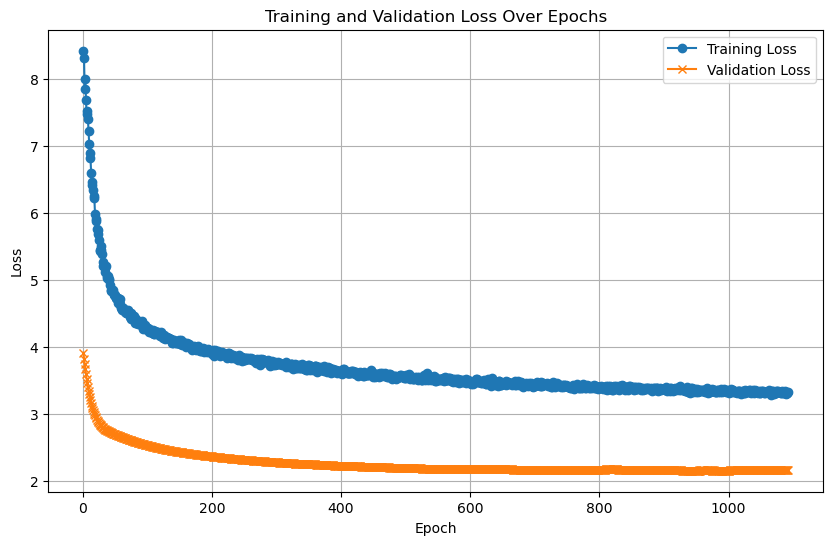

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/578], Loss: 5.6266
Test Batch [20/578], Loss: 5.4462
Test Batch [30/578], Loss: 5.5018
Test Batch [40/578], Loss: 5.3847
Test Batch [50/578], Loss: 5.3873
Test Batch [60/578], Loss: 5.4508
Test Batch [70/578], Loss: 5.4653
Test Batch [80/578], Loss: 5.6303


Test Batch [90/578], Loss: 5.9380
Test Batch [100/578], Loss: 5.6354
Test Batch [110/578], Loss: 5.7543
Test Batch [120/578], Loss: 5.4962
Test Batch [130/578], Loss: 5.5508
Test Batch [140/578], Loss: 5.4245
Test Batch [150/578], Loss: 5.4928
Test Batch [160/578], Loss: 5.5338
Test Batch [170/578], Loss: 5.4866
Test Batch [180/578], Loss: 5.7028
Test Batch [190/578], Loss: 5.5551
Test Batch [200/578], Loss: 5.4676
Test Batch [210/578], Loss: 5.3901
Test Batch [220/578], Loss: 5.3364
Test Batch [230/578], Loss: 5.3678


Test Batch [240/578], Loss: 5.4127
Test Batch [250/578], Loss: 5.3784
Test Batch [260/578], Loss: 5.5216
Test Batch [270/578], Loss: 5.6106
Test Batch [280/578], Loss: 5.7870
Test Batch [290/578], Loss: 5.3954
Test Batch [300/578], Loss: 5.3788
Test Batch [310/578], Loss: 5.3507
Test Batch [320/578], Loss: 5.1680
Test Batch [330/578], Loss: 5.3712
Test Batch [340/578], Loss: 5.4042
Test Batch [350/578], Loss: 5.2372
Test Batch [360/578], Loss: 5.2889
Test Batch [370/578], Loss: 5.7541
Test Batch [380/578], Loss: 5.6027
Test Batch [390/578], Loss: 4.9838


Test Batch [400/578], Loss: 5.2126
Test Batch [410/578], Loss: 5.4193
Test Batch [420/578], Loss: 4.8798
Test Batch [430/578], Loss: 4.8392
Test Batch [440/578], Loss: 4.9051
Test Batch [450/578], Loss: 5.0016
Test Batch [460/578], Loss: 5.3055
Test Batch [470/578], Loss: 4.9027
Test Batch [480/578], Loss: 5.5954
Test Batch [490/578], Loss: 5.4482
Test Batch [500/578], Loss: 5.4408
Test Batch [510/578], Loss: 5.3159
Test Batch [520/578], Loss: 5.6416
Test Batch [530/578], Loss: 6.7003
Test Batch [540/578], Loss: 5.6788


Test Batch [550/578], Loss: 5.5216
Test Batch [560/578], Loss: 5.5601
Test Batch [570/578], Loss: 5.4911

Test Loss: 5.4674


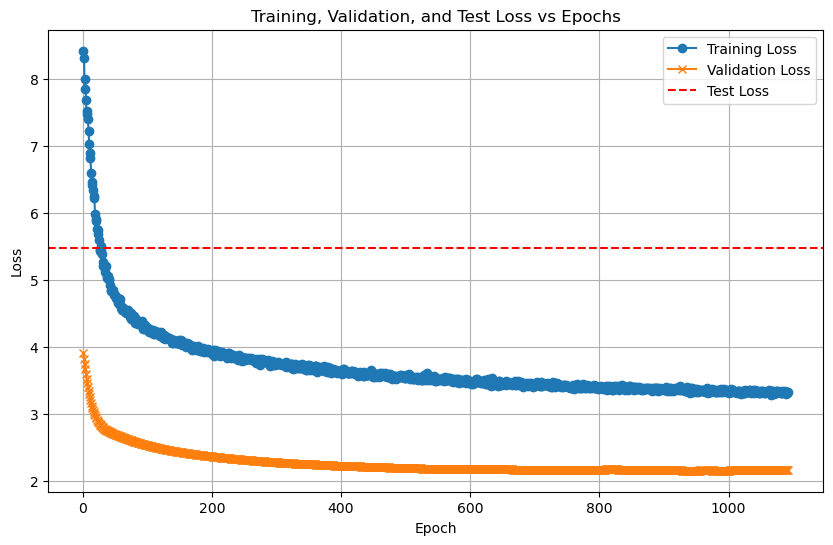

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.


  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.
  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.


  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.


  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.


  Processed batch 130/578 for test dataset.
  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.


  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.


  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.
  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.


  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.


  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.


  Processed batch 330/578 for test dataset.
  Processed batch 340/578 for test dataset.


  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.
  Processed batch 390/578 for test dataset.


  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.


  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.
  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.


  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.


  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.


  Processed batch 530/578 for test dataset.
  Processed batch 540/578 for test dataset.


  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.44%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.80      0.80      0.80         5
           3       0.67      0.80      0.73         5
           4       0.67      0.80      0.73         5
           5       1.00      0.80      0.89         5
           6       0.80      0.80      0.80         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5

    accuracy                           0.84        45
   macro avg       0.86      0.84      0.85        45
weighted avg       0.86      0.84      0.85        45


LOG: Evaluating on the test set...
Test Accuracy: 95.51%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65926
           1       0.94      0.94      0.94      7553
           2       0.84      0.84      0.84      3045
           3       0.62      0.88      0.73      2640
           4       0.72      0.89      0.79      6539
           5       0.85      0.97      0.90      9203
           6       0.96      0.83      0.89      7242
           7       1.00      0.94      0.97     42781
           8       0.99      0.99      0.99      2818

    accuracy                           0.96    147747
   macro avg       0.88      0.92      0.89    147747
weighted avg       0.96      0.96      0.96    147747

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4171  |  Val Loss: 2.3616
Validation loss improved from inf to 2.3616.
[Epoch 2/1000] Train Loss: 2.3033  |  Val Loss: 2.2622
Validation loss improved from 2.3616 to 2.2622.
[Epoch 3/1000] Train Loss: 2.1997  |  Val Loss: 2.1694
Validation loss improved from 2.2622 to 2.1694.
[Epoch 4/1000] Train Loss: 2.1010  |  Val Loss: 2.0854
Validation loss improved from 2.1694 to 2.0854.
[Epoch 5/1000] Train Loss: 2.0164  |  Val Loss: 2.0107
Validation loss improved from 2.0854 to 2.0107.
[Epoch 6/1000] Train Loss: 1.9391  |  Val Loss: 1.9445
Validation loss improved from 2.0107 to 1.9445.
[Epoch 7/1000] Train Loss: 1.8711  |  Val Loss: 1.8827
Validation loss improved from 1.9445 to 1.8827.
[Epoch 8/1000] Train Loss: 1.8062  |  Val Loss: 1.8237
Validation loss improved from 1.8827 to 1.8237.
[Epoch 9/1000] Train Loss: 1.7419  |  Val Loss: 1.7631
Validation loss improved from 1.8237 to 1.7631.
[Epoch 10/1000] Train Loss: 1.6755  |  Val Loss: 1.7051
Validation loss impr

[Epoch 14/1000] Train Loss: 1.4553  |  Val Loss: 1.5126
Validation loss improved from 1.5553 to 1.5126.
[Epoch 15/1000] Train Loss: 1.4061  |  Val Loss: 1.4712
Validation loss improved from 1.5126 to 1.4712.
[Epoch 16/1000] Train Loss: 1.3568  |  Val Loss: 1.4300
Validation loss improved from 1.4712 to 1.4300.
[Epoch 17/1000] Train Loss: 1.3087  |  Val Loss: 1.3899
Validation loss improved from 1.4300 to 1.3899.
[Epoch 18/1000] Train Loss: 1.2626  |  Val Loss: 1.3506
Validation loss improved from 1.3899 to 1.3506.


[Epoch 19/1000] Train Loss: 1.2180  |  Val Loss: 1.3144
Validation loss improved from 1.3506 to 1.3144.
[Epoch 20/1000] Train Loss: 1.1763  |  Val Loss: 1.2793
Validation loss improved from 1.3144 to 1.2793.
[Epoch 21/1000] Train Loss: 1.1368  |  Val Loss: 1.2452
Validation loss improved from 1.2793 to 1.2452.
[Epoch 22/1000] Train Loss: 1.0980  |  Val Loss: 1.2115
Validation loss improved from 1.2452 to 1.2115.
[Epoch 23/1000] Train Loss: 1.0606  |  Val Loss: 1.1786
Validation loss improved from 1.2115 to 1.1786.
[Epoch 24/1000] Train Loss: 1.0243  |  Val Loss: 1.1461
Validation loss improved from 1.1786 to 1.1461.
[Epoch 25/1000] Train Loss: 0.9886  |  Val Loss: 1.1143
Validation loss improved from 1.1461 to 1.1143.
[Epoch 26/1000] Train Loss: 0.9532  |  Val Loss: 1.0840
Validation loss improved from 1.1143 to 1.0840.
[Epoch 27/1000] Train Loss: 0.9193  |  Val Loss: 1.0543
Validation loss improved from 1.0840 to 1.0543.
[Epoch 28/1000] Train Loss: 0.8848  |  Val Loss: 1.0237
Validati

[Epoch 31/1000] Train Loss: 0.7880  |  Val Loss: 0.9367
Validation loss improved from 0.9644 to 0.9367.
[Epoch 32/1000] Train Loss: 0.7564  |  Val Loss: 0.9086
Validation loss improved from 0.9367 to 0.9086.
[Epoch 33/1000] Train Loss: 0.7264  |  Val Loss: 0.8805
Validation loss improved from 0.9086 to 0.8805.
[Epoch 34/1000] Train Loss: 0.6958  |  Val Loss: 0.8533
Validation loss improved from 0.8805 to 0.8533.
[Epoch 35/1000] Train Loss: 0.6670  |  Val Loss: 0.8267
Validation loss improved from 0.8533 to 0.8267.


[Epoch 36/1000] Train Loss: 0.6389  |  Val Loss: 0.8015
Validation loss improved from 0.8267 to 0.8015.
[Epoch 37/1000] Train Loss: 0.6128  |  Val Loss: 0.7773
Validation loss improved from 0.8015 to 0.7773.
[Epoch 38/1000] Train Loss: 0.5878  |  Val Loss: 0.7530
Validation loss improved from 0.7773 to 0.7530.
[Epoch 39/1000] Train Loss: 0.5642  |  Val Loss: 0.7310
Validation loss improved from 0.7530 to 0.7310.
[Epoch 40/1000] Train Loss: 0.5419  |  Val Loss: 0.7104
Validation loss improved from 0.7310 to 0.7104.
[Epoch 41/1000] Train Loss: 0.5206  |  Val Loss: 0.6911
Validation loss improved from 0.7104 to 0.6911.
[Epoch 42/1000] Train Loss: 0.5010  |  Val Loss: 0.6718
Validation loss improved from 0.6911 to 0.6718.
[Epoch 43/1000] Train Loss: 0.4822  |  Val Loss: 0.6533
Validation loss improved from 0.6718 to 0.6533.
[Epoch 44/1000] Train Loss: 0.4641  |  Val Loss: 0.6354
Validation loss improved from 0.6533 to 0.6354.
[Epoch 45/1000] Train Loss: 0.4480  |  Val Loss: 0.6171
Validati

[Epoch 47/1000] Train Loss: 0.4164  |  Val Loss: 0.5861
Validation loss improved from 0.6010 to 0.5861.
[Epoch 48/1000] Train Loss: 0.4025  |  Val Loss: 0.5716
Validation loss improved from 0.5861 to 0.5716.
[Epoch 49/1000] Train Loss: 0.3890  |  Val Loss: 0.5578
Validation loss improved from 0.5716 to 0.5578.
[Epoch 50/1000] Train Loss: 0.3762  |  Val Loss: 0.5439
Validation loss improved from 0.5578 to 0.5439.
[Epoch 51/1000] Train Loss: 0.3646  |  Val Loss: 0.5313
Validation loss improved from 0.5439 to 0.5313.
[Epoch 52/1000] Train Loss: 0.3528  |  Val Loss: 0.5192
Validation loss improved from 0.5313 to 0.5192.


[Epoch 53/1000] Train Loss: 0.3413  |  Val Loss: 0.5072
Validation loss improved from 0.5192 to 0.5072.
[Epoch 54/1000] Train Loss: 0.3309  |  Val Loss: 0.4967
Validation loss improved from 0.5072 to 0.4967.
[Epoch 55/1000] Train Loss: 0.3210  |  Val Loss: 0.4852
Validation loss improved from 0.4967 to 0.4852.
[Epoch 56/1000] Train Loss: 0.3111  |  Val Loss: 0.4730
Validation loss improved from 0.4852 to 0.4730.
[Epoch 57/1000] Train Loss: 0.3019  |  Val Loss: 0.4636
Validation loss improved from 0.4730 to 0.4636.
[Epoch 58/1000] Train Loss: 0.2927  |  Val Loss: 0.4562
Validation loss improved from 0.4636 to 0.4562.
[Epoch 59/1000] Train Loss: 0.2846  |  Val Loss: 0.4482
Validation loss improved from 0.4562 to 0.4482.
[Epoch 60/1000] Train Loss: 0.2769  |  Val Loss: 0.4405
Validation loss improved from 0.4482 to 0.4405.
[Epoch 61/1000] Train Loss: 0.2698  |  Val Loss: 0.4320
Validation loss improved from 0.4405 to 0.4320.


[Epoch 62/1000] Train Loss: 0.2625  |  Val Loss: 0.4266
Validation loss improved from 0.4320 to 0.4266.
[Epoch 63/1000] Train Loss: 0.2558  |  Val Loss: 0.4201
Validation loss improved from 0.4266 to 0.4201.
[Epoch 64/1000] Train Loss: 0.2496  |  Val Loss: 0.4123
Validation loss improved from 0.4201 to 0.4123.
[Epoch 65/1000] Train Loss: 0.2426  |  Val Loss: 0.4054
Validation loss improved from 0.4123 to 0.4054.
[Epoch 66/1000] Train Loss: 0.2364  |  Val Loss: 0.3999
Validation loss improved from 0.4054 to 0.3999.
[Epoch 67/1000] Train Loss: 0.2302  |  Val Loss: 0.3939
Validation loss improved from 0.3999 to 0.3939.


[Epoch 68/1000] Train Loss: 0.2246  |  Val Loss: 0.3880
Validation loss improved from 0.3939 to 0.3880.
[Epoch 69/1000] Train Loss: 0.2193  |  Val Loss: 0.3823
Validation loss improved from 0.3880 to 0.3823.
[Epoch 70/1000] Train Loss: 0.2144  |  Val Loss: 0.3778
Validation loss improved from 0.3823 to 0.3778.
[Epoch 71/1000] Train Loss: 0.2094  |  Val Loss: 0.3736
Validation loss improved from 0.3778 to 0.3736.
[Epoch 72/1000] Train Loss: 0.2051  |  Val Loss: 0.3693
Validation loss improved from 0.3736 to 0.3693.
[Epoch 73/1000] Train Loss: 0.2008  |  Val Loss: 0.3654
Validation loss improved from 0.3693 to 0.3654.
[Epoch 74/1000] Train Loss: 0.1965  |  Val Loss: 0.3615
Validation loss improved from 0.3654 to 0.3615.
[Epoch 75/1000] Train Loss: 0.1923  |  Val Loss: 0.3583
Validation loss improved from 0.3615 to 0.3583.
[Epoch 76/1000] Train Loss: 0.1885  |  Val Loss: 0.3543
Validation loss improved from 0.3583 to 0.3543.
[Epoch 77/1000] Train Loss: 0.1848  |  Val Loss: 0.3514
Validati

[Epoch 79/1000] Train Loss: 0.1779  |  Val Loss: 0.3436
Validation loss improved from 0.3474 to 0.3436.
[Epoch 80/1000] Train Loss: 0.1746  |  Val Loss: 0.3405
Validation loss improved from 0.3436 to 0.3405.
[Epoch 81/1000] Train Loss: 0.1714  |  Val Loss: 0.3377
Validation loss improved from 0.3405 to 0.3377.
[Epoch 82/1000] Train Loss: 0.1684  |  Val Loss: 0.3344
Validation loss improved from 0.3377 to 0.3344.
[Epoch 83/1000] Train Loss: 0.1656  |  Val Loss: 0.3312
Validation loss improved from 0.3344 to 0.3312.
[Epoch 84/1000] Train Loss: 0.1629  |  Val Loss: 0.3293
Validation loss improved from 0.3312 to 0.3293.
[Epoch 85/1000] Train Loss: 0.1604  |  Val Loss: 0.3264
Validation loss improved from 0.3293 to 0.3264.


[Epoch 86/1000] Train Loss: 0.1581  |  Val Loss: 0.3222
Validation loss improved from 0.3264 to 0.3222.
[Epoch 87/1000] Train Loss: 0.1553  |  Val Loss: 0.3201
Validation loss improved from 0.3222 to 0.3201.
[Epoch 88/1000] Train Loss: 0.1533  |  Val Loss: 0.3187
Validation loss improved from 0.3201 to 0.3187.
[Epoch 89/1000] Train Loss: 0.1514  |  Val Loss: 0.3152
Validation loss improved from 0.3187 to 0.3152.
[Epoch 90/1000] Train Loss: 0.1485  |  Val Loss: 0.3138
Validation loss improved from 0.3152 to 0.3138.
[Epoch 91/1000] Train Loss: 0.1465  |  Val Loss: 0.3127
Validation loss improved from 0.3138 to 0.3127.
[Epoch 92/1000] Train Loss: 0.1447  |  Val Loss: 0.3118
Validation loss improved from 0.3127 to 0.3118.
[Epoch 93/1000] Train Loss: 0.1430  |  Val Loss: 0.3083
Validation loss improved from 0.3118 to 0.3083.
[Epoch 94/1000] Train Loss: 0.1407  |  Val Loss: 0.3064
Validation loss improved from 0.3083 to 0.3064.


[Epoch 95/1000] Train Loss: 0.1390  |  Val Loss: 0.3053
Validation loss improved from 0.3064 to 0.3053.
[Epoch 96/1000] Train Loss: 0.1370  |  Val Loss: 0.3036
Validation loss improved from 0.3053 to 0.3036.
[Epoch 97/1000] Train Loss: 0.1365  |  Val Loss: 0.3028
Validation loss improved from 0.3036 to 0.3028.
[Epoch 98/1000] Train Loss: 0.1342  |  Val Loss: 0.3000
Validation loss improved from 0.3028 to 0.3000.
[Epoch 99/1000] Train Loss: 0.1322  |  Val Loss: 0.2994
Validation loss improved from 0.3000 to 0.2994.
[Epoch 100/1000] Train Loss: 0.1311  |  Val Loss: 0.2991
Validation loss improved from 0.2994 to 0.2991.
[Epoch 101/1000] Train Loss: 0.1292  |  Val Loss: 0.2981
Validation loss improved from 0.2991 to 0.2981.
[Epoch 102/1000] Train Loss: 0.1286  |  Val Loss: 0.2972
Validation loss improved from 0.2981 to 0.2972.


[Epoch 103/1000] Train Loss: 0.1264  |  Val Loss: 0.2948
Validation loss improved from 0.2972 to 0.2948.
[Epoch 104/1000] Train Loss: 0.1257  |  Val Loss: 0.2918
Validation loss improved from 0.2948 to 0.2918.
[Epoch 105/1000] Train Loss: 0.1245  |  Val Loss: 0.2915
Validation loss improved from 0.2918 to 0.2915.
[Epoch 106/1000] Train Loss: 0.1226  |  Val Loss: 0.2891
Validation loss improved from 0.2915 to 0.2891.
[Epoch 107/1000] Train Loss: 0.1212  |  Val Loss: 0.2886
Validation loss improved from 0.2891 to 0.2886.
[Epoch 108/1000] Train Loss: 0.1207  |  Val Loss: 0.2897
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 109/1000] Train Loss: 0.1189  |  Val Loss: 0.2887
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 110/1000] Train Loss: 0.1178  |  Val Loss: 0.2887
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 111/1000] Train Loss: 0.1165  |  Val Loss: 0.2877
Validation loss improved from 0.2886 to 0.2877.


[Epoch 112/1000] Train Loss: 0.1161  |  Val Loss: 0.2875
Validation loss improved from 0.2877 to 0.2875.
[Epoch 113/1000] Train Loss: 0.1145  |  Val Loss: 0.2860
Validation loss improved from 0.2875 to 0.2860.
[Epoch 114/1000] Train Loss: 0.1135  |  Val Loss: 0.2862
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 115/1000] Train Loss: 0.1126  |  Val Loss: 0.2848
Validation loss improved from 0.2860 to 0.2848.
[Epoch 116/1000] Train Loss: 0.1115  |  Val Loss: 0.2843
Validation loss improved from 0.2848 to 0.2843.
[Epoch 117/1000] Train Loss: 0.1111  |  Val Loss: 0.2844
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 118/1000] Train Loss: 0.1102  |  Val Loss: 0.2829
Validation loss improved from 0.2843 to 0.2829.


[Epoch 119/1000] Train Loss: 0.1090  |  Val Loss: 0.2816
Validation loss improved from 0.2829 to 0.2816.
[Epoch 120/1000] Train Loss: 0.1076  |  Val Loss: 0.2810
Validation loss improved from 0.2816 to 0.2810.
[Epoch 121/1000] Train Loss: 0.1075  |  Val Loss: 0.2826
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 122/1000] Train Loss: 0.1061  |  Val Loss: 0.2805
Validation loss improved from 0.2810 to 0.2805.
[Epoch 123/1000] Train Loss: 0.1056  |  Val Loss: 0.2790
Validation loss improved from 0.2805 to 0.2790.
[Epoch 124/1000] Train Loss: 0.1042  |  Val Loss: 0.2792
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 125/1000] Train Loss: 0.1038  |  Val Loss: 0.2774
Validation loss improved from 0.2790 to 0.2774.
[Epoch 126/1000] Train Loss: 0.1034  |  Val Loss: 0.2788
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 127/1000] Train Loss: 0.1023  |  Val Loss: 0.2777
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 128/1000] Train Loss: 0.

[Epoch 130/1000] Train Loss: 0.1002  |  Val Loss: 0.2759
Validation loss improved from 0.2765 to 0.2759.
[Epoch 131/1000] Train Loss: 0.0995  |  Val Loss: 0.2765
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 132/1000] Train Loss: 0.0988  |  Val Loss: 0.2768
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 133/1000] Train Loss: 0.0987  |  Val Loss: 0.2765
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 134/1000] Train Loss: 0.0979  |  Val Loss: 0.2764
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 135/1000] Train Loss: 0.0971  |  Val Loss: 0.2765
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 136/1000] Train Loss: 0.0969  |  Val Loss: 0.2758
Validation loss improved from 0.2759 to 0.2758.
[Epoch 137/1000] Train Loss: 0.0959  |  Val Loss: 0.2750
Validation loss improved from 0.2758 to 0.2750.
[Epoch 138/1000] Train Loss: 0.0958  |  Val Loss: 0.2750
Validation loss improved from 0.2750 to 0.2750.
[Epoch 139/1000] Train Loss: 0.0948  |  Val Loss: 0.2745
Validation loss improved from 0.2750 to 0.2745.
[Epoch 140/1000] Train Loss: 0.0946  |  Val Loss: 0.2742
Validation loss improved from 0.2745 to 0.2742.
[Epoch 141/1000] Train Loss: 0.0938  |  Val Loss: 0.2720
Validation loss improved from 0.2742 to 0.2720.
[Epoch 142/1000] Train Loss: 0.0948  |  Val Loss: 0.2697
Validation loss improved from 0.2720 to 0.2697.
[Epoch 143/1000] Train Loss: 0.0931  |  Val Loss: 0.2713
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 144/1000] Train Loss: 0.0930  |  Val Loss: 0.2698
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 145/1000] Train Loss: 0.0919  |  Val

[Epoch 146/1000] Train Loss: 0.0916  |  Val Loss: 0.2740
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 147/1000] Train Loss: 0.0909  |  Val Loss: 0.2728
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 148/1000] Train Loss: 0.0904  |  Val Loss: 0.2733
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 149/1000] Train Loss: 0.0901  |  Val Loss: 0.2740
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 150/1000] Train Loss: 0.0896  |  Val Loss: 0.2722
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 151/1000] Train Loss: 0.0896  |  Val Loss: 0.2702
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 152/1000] Train Loss: 0.0892  |  Val Loss: 0.2704
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 153/1000] Train Loss: 0.0886  |  Val Loss: 0.2694
Validation loss improved from 0.2697 to 0.2694.
[Epoch 154/1000] Train Loss: 0.0880  |  Val Loss: 0.2693
Validation loss improved from 0.2694 to 0.2693.
[Epoch 155/1000] Train Loss: 0.0878  |  Val Loss: 0.2714
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 156/1000] Train Loss: 0.0871  |  Val Loss: 0.2709
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 157/1000] Train Loss: 0.0877  |  Val Loss: 0.2715
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 158/1000] Train Loss: 0.0867  |  Val Loss: 0.2718
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 159/1000] Train Loss: 0.0860  |  Val Loss: 0.2702
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 160/1000] Train Loss: 0.0859  |  Val Loss: 0.2705
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 161/1

[Epoch 164/1000] Train Loss: 0.0845  |  Val Loss: 0.2704
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 165/1000] Train Loss: 0.0838  |  Val Loss: 0.2714
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 166/1000] Train Loss: 0.0836  |  Val Loss: 0.2717
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 167/1000] Train Loss: 0.0832  |  Val Loss: 0.2729
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 168/1000] Train Loss: 0.0830  |  Val Loss: 0.2740
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 169/1000] Train Loss: 0.0828  |  Val Loss: 0.2732
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 170/1000] Train Loss: 0.0823  |  Val Loss: 0.2732
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 171/1000] Train Loss: 0.0821  |  Val Loss: 0.2720
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 172/1000] Train Loss: 0.0817  |  Val Loss: 0.2716
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 173/1000] Train Loss: 0.0814  |  Val Loss: 0.2695
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 174/1000] Train Loss: 0.0812  |  Val Loss: 0.2694
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 175/1000] Train Loss: 0.0812  |  Val Loss: 0.2719
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 176/1000] Train Loss: 0.0806  |  Val Loss: 0.2741
!! Validation loss did NOT improve !! Patience:

[Epoch 180/1000] Train Loss: 0.0793  |  Val Loss: 0.2740
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 181/1000] Train Loss: 0.0794  |  Val Loss: 0.2737
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 182/1000] Train Loss: 0.0794  |  Val Loss: 0.2745
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 183/1000] Train Loss: 0.0791  |  Val Loss: 0.2733
!! Validation loss did NOT improve !! Patience: 29/100


[Epoch 184/1000] Train Loss: 0.0784  |  Val Loss: 0.2722
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 185/1000] Train Loss: 0.0785  |  Val Loss: 0.2695
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 186/1000] Train Loss: 0.0782  |  Val Loss: 0.2686
Validation loss improved from 0.2693 to 0.2686.
[Epoch 187/1000] Train Loss: 0.0779  |  Val Loss: 0.2715
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 188/1000] Train Loss: 0.0774  |  Val Loss: 0.2720
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 189/1000] Train Loss: 0.0773  |  Val Loss: 0.2728
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 190/1000] Train Loss: 0.0771  |  Val Loss: 0.2713
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 191/1000] Train Loss: 0.0772  |  Val Loss: 0.2736
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 192/1000] Train Loss: 0.0769  |  Val Loss: 0.2744
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 197/1000] Train Loss: 0.0761  |  Val Loss: 0.2713
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 198/1000] Train Loss: 0.0757  |  Val Loss: 0.2719
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 199/1000] Train Loss: 0.0752  |  Val Loss: 0.2741
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 200/1000] Train Loss: 0.0758  |  Val Loss: 0.2785
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 201/1000] Train Loss: 0.0752  |  Val Loss: 0.2784
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 202/1000] Train Loss: 0.0747  |  Val Loss: 0.2749
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 203/1000] Train Loss: 0.0744  |  Val Loss: 0.2733
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 204/1000] Train Loss: 0.0743  |  Val Loss: 0.2728
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 205/1000] Train Loss: 0.0740  |  Val Loss: 0.2740
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 206/1000] Train Loss: 0.0739  |  Val Loss: 0.2742
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 207/1000] Train Loss: 0.0739  |  Val Loss: 0.2711
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 208/1000] Train Loss: 0.0736  |  Val Loss: 0.2686
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 209/1000] Train Loss: 0.0734  |  Val Loss: 0.2683
Validation loss improved from 0.2686 to 0.2683.
[Epoch 210/1000] Train Loss: 0.0730  |  Val Loss: 0.2699
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 215/1000] Train Loss: 0.0724  |  Val Loss: 0.2783
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 216/1000] Train Loss: 0.0720  |  Val Loss: 0.2761
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 217/1000] Train Loss: 0.0717  |  Val Loss: 0.2745
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 218/1000] Train Loss: 0.0718  |  Val Loss: 0.2726
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 219/1000] Train Loss: 0.0714  |  Val Loss: 0.2712
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 220/1000] Train Loss: 0.0716  |  Val Loss: 0.2713
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 221/1000] Train Loss: 0.0712  |  Val Loss: 0.2744
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 222/1000] Train Loss: 0.0715  |  Val Loss: 0.2756
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 223/1000] Train Loss: 0.0716  |  Val Loss: 0.2755
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 224/1000] Train Loss: 0.0711  |  Val Loss: 0.2771
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 225/1000] Train Loss: 0.0705  |  Val Loss: 0.2755
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 226/1000] Train Loss: 0.0706  |  Val Loss: 0.2781
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 227/1000] Train Loss: 0.0705  |  Val Loss: 0.2797
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 228/1000] Train Loss: 0.0706  |  Val Loss: 0.2781
!! Validation loss did NOT improve !! Patience:

[Epoch 231/1000] Train Loss: 0.0701  |  Val Loss: 0.2760
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 232/1000] Train Loss: 0.0691  |  Val Loss: 0.2749
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 233/1000] Train Loss: 0.0699  |  Val Loss: 0.2751
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 234/1000] Train Loss: 0.0696  |  Val Loss: 0.2743
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 235/1000] Train Loss: 0.0700  |  Val Loss: 0.2758
!! Validation loss did NOT improve !! Patience: 26/100


[Epoch 236/1000] Train Loss: 0.0690  |  Val Loss: 0.2760
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 237/1000] Train Loss: 0.0692  |  Val Loss: 0.2770
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 238/1000] Train Loss: 0.0686  |  Val Loss: 0.2724
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 239/1000] Train Loss: 0.0689  |  Val Loss: 0.2699
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 240/1000] Train Loss: 0.0693  |  Val Loss: 0.2733
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 241/1000] Train Loss: 0.0682  |  Val Loss: 0.2733
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 242/1000] Train Loss: 0.0681  |  Val Loss: 0.2754
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 243/1000] Train Loss: 0.0681  |  Val Loss: 0.2764
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 244/1000] Train Loss: 0.0680  |  Val Loss: 0.2776
!! Validation loss did NOT improve !! Patience:

[Epoch 246/1000] Train Loss: 0.0676  |  Val Loss: 0.2807
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 247/1000] Train Loss: 0.0678  |  Val Loss: 0.2786
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 248/1000] Train Loss: 0.0677  |  Val Loss: 0.2774
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 249/1000] Train Loss: 0.0674  |  Val Loss: 0.2788
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 250/1000] Train Loss: 0.0672  |  Val Loss: 0.2788
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 251/1000] Train Loss: 0.0673  |  Val Loss: 0.2780
!! Validation loss did NOT improve !! Patience: 42/100


[Epoch 252/1000] Train Loss: 0.0668  |  Val Loss: 0.2775
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 253/1000] Train Loss: 0.0670  |  Val Loss: 0.2775
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 254/1000] Train Loss: 0.0664  |  Val Loss: 0.2785
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 255/1000] Train Loss: 0.0672  |  Val Loss: 0.2797
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 256/1000] Train Loss: 0.0670  |  Val Loss: 0.2798
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 257/1000] Train Loss: 0.0662  |  Val Loss: 0.2761
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 258/1000] Train Loss: 0.0665  |  Val Loss: 0.2735
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 259/1000] Train Loss: 0.0662  |  Val Loss: 0.2741
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 260/1000] Train Loss: 0.0659  |  Val Loss: 0.2781
!! Validation loss did NOT improve !! Patience:

[Epoch 264/1000] Train Loss: 0.0654  |  Val Loss: 0.2756
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 265/1000] Train Loss: 0.0660  |  Val Loss: 0.2763
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 266/1000] Train Loss: 0.0660  |  Val Loss: 0.2784
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 267/1000] Train Loss: 0.0654  |  Val Loss: 0.2779
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 268/1000] Train Loss: 0.0651  |  Val Loss: 0.2789
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 269/1000] Train Loss: 0.0656  |  Val Loss: 0.2824
!! Validation loss did NOT improve !! Patience: 60/100


[Epoch 270/1000] Train Loss: 0.0649  |  Val Loss: 0.2791
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 271/1000] Train Loss: 0.0651  |  Val Loss: 0.2763
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 272/1000] Train Loss: 0.0648  |  Val Loss: 0.2775
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 273/1000] Train Loss: 0.0647  |  Val Loss: 0.2801
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 274/1000] Train Loss: 0.0646  |  Val Loss: 0.2811
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 275/1000] Train Loss: 0.0646  |  Val Loss: 0.2793
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 276/1000] Train Loss: 0.0653  |  Val Loss: 0.2795
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 277/1000] Train Loss: 0.0650  |  Val Loss: 0.2796
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 278/1000] Train Loss: 0.0640  |  Val Loss: 0.2772
!! Validation loss did NOT improve !! Patience:

[Epoch 280/1000] Train Loss: 0.0637  |  Val Loss: 0.2768
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 281/1000] Train Loss: 0.0640  |  Val Loss: 0.2751
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 282/1000] Train Loss: 0.0639  |  Val Loss: 0.2764
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 283/1000] Train Loss: 0.0637  |  Val Loss: 0.2747
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 284/1000] Train Loss: 0.0642  |  Val Loss: 0.2783
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 285/1000] Train Loss: 0.0635  |  Val Loss: 0.2775
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 286/1000] Train Loss: 0.0636  |  Val Loss: 0.2808
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 287/1000] Train Loss: 0.0631  |  Val Loss: 0.2802
!! Validation loss did NOT improve !! Patience: 78/100


[Epoch 288/1000] Train Loss: 0.0642  |  Val Loss: 0.2808
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 289/1000] Train Loss: 0.0635  |  Val Loss: 0.2849
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 290/1000] Train Loss: 0.0639  |  Val Loss: 0.2840
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 291/1000] Train Loss: 0.0637  |  Val Loss: 0.2891
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 292/1000] Train Loss: 0.0632  |  Val Loss: 0.2866
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 293/1000] Train Loss: 0.0627  |  Val Loss: 0.2843
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 294/1000] Train Loss: 0.0630  |  Val Loss: 0.2795
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 295/1000] Train Loss: 0.0623  |  Val Loss: 0.2789
!! Validation loss did NOT improve !! Patience: 86/100


[Epoch 296/1000] Train Loss: 0.0630  |  Val Loss: 0.2767
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 297/1000] Train Loss: 0.0626  |  Val Loss: 0.2794
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 298/1000] Train Loss: 0.0621  |  Val Loss: 0.2803
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 299/1000] Train Loss: 0.0620  |  Val Loss: 0.2805
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 300/1000] Train Loss: 0.0621  |  Val Loss: 0.2790
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 301/1000] Train Loss: 0.0625  |  Val Loss: 0.2832
!! Validation loss did NOT improve !! Patience: 92/100


[Epoch 302/1000] Train Loss: 0.0620  |  Val Loss: 0.2827
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 303/1000] Train Loss: 0.0617  |  Val Loss: 0.2804
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 304/1000] Train Loss: 0.0616  |  Val Loss: 0.2803
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 305/1000] Train Loss: 0.0616  |  Val Loss: 0.2828
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 306/1000] Train Loss: 0.0615  |  Val Loss: 0.2804
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 307/1000] Train Loss: 0.0617  |  Val Loss: 0.2802
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 308/1000] Train Loss: 0.0612  |  Val Loss: 0.2809
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 309/1000] Train Loss: 0.0614  |  Val Loss: 0.2810
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 309 !!
No improvement for 100 epochs.


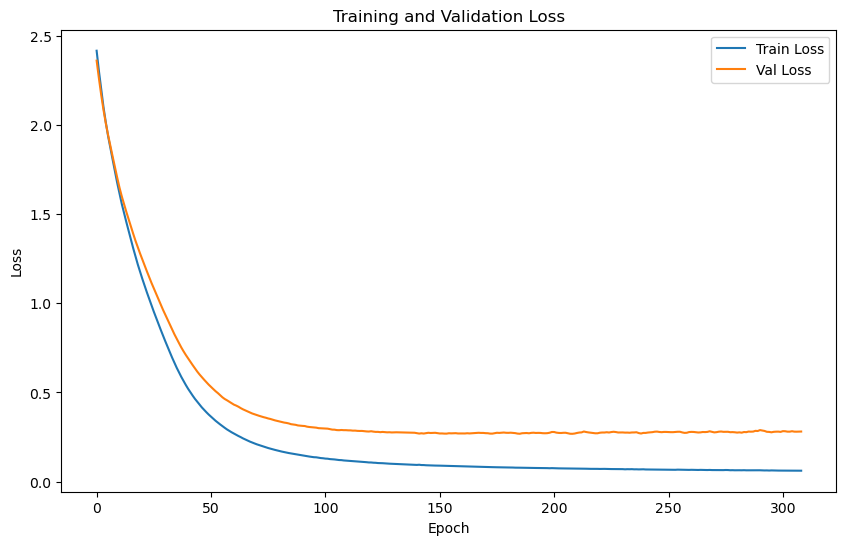

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.1605 | Test Accuracy: 95.40%


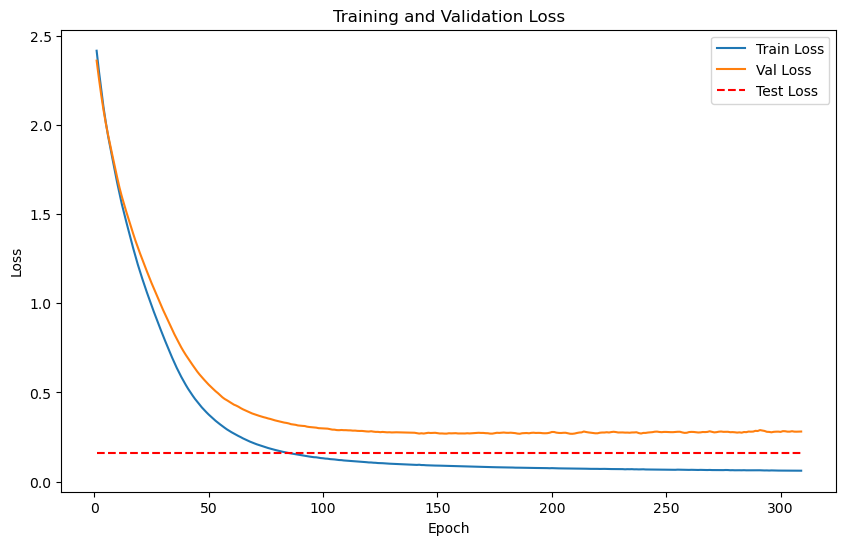

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147747, 64), 
Test labels shape: (147747,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4431
    Batch [2/2], Train Loss: 0.4414
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3759
Epoch [1/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.3759

Validation loss improved from inf to 0.3759. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4429


    Batch [2/2], Train Loss: 0.4429
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3738
Epoch [2/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3738

Validation loss improved from 0.3759 to 0.3738. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 0.4441
    Batch [2/2], Train Loss: 0.4405
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.3721
Epoch [3/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.3721

Validation loss improved from 0.3738 to 0.3721. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 0.4386
    Batch [2/2], Train Loss: 0.4403
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3698
Epoch [4/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3698

Validation loss improved from 0.3721 to 0.3698. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4319
    Batch [2/2], Train Loss: 0.4311
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3682
Epoch [5/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.3682

Validation loss improved from 0.3698 to 0.3682. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.4372


    Batch [2/2], Train Loss: 0.4277
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3669
Epoch [6/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3669

Validation loss improved from 0.3682 to 0.3669. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.4346
    Batch [2/2], Train Loss: 0.4286
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.3656
Epoch [7/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.3656

Validation loss improved from 0.3669 to 0.3656. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/2], Train Loss: 0.4233
    Batch [2/2], Train Loss: 0.4238
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3642
Epoch [8/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.3642

Validation loss improved from 0.3656 to 0.3642. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/2], Train Loss: 0.4305


    Batch [2/2], Train Loss: 0.4206
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3626
Epoch [9/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.3626

Validation loss improved from 0.3642 to 0.3626. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 0.4208
    Batch [2/2], Train Loss: 0.4215
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [10/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3613

Validation loss improved from 0.3626 to 0.3613. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/2], Train Loss: 0.4217
    Batch [2/2], Train Loss: 0.4206
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [11/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.3601

Validation loss improved from 0.3613 to 0.3601. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 0.4238


    Batch [2/2], Train Loss: 0.4246
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3590
Epoch [12/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.3590

Validation loss improved from 0.3601 to 0.3590. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 0.4202


    Batch [2/2], Train Loss: 0.4230
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [13/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.3579

Validation loss improved from 0.3590 to 0.3579. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 0.4233


    Batch [2/2], Train Loss: 0.4117
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3570
Epoch [14/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3570

Validation loss improved from 0.3579 to 0.3570. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.4170
    Batch [2/2], Train Loss: 0.4131
LOG: Epoch [15/2000] - Validation


    Batch [1/1], Val Loss: 0.3560
Epoch [15/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3560

Validation loss improved from 0.3570 to 0.3560. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.4180
    Batch [2/2], Train Loss: 0.4163
LOG: Epoch [16/2000] - Validation


    Batch [1/1], Val Loss: 0.3552
Epoch [16/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.3552

Validation loss improved from 0.3560 to 0.3552. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 0.4073
    Batch [2/2], Train Loss: 0.4158
LOG: Epoch [17/2000] - Validation


    Batch [1/1], Val Loss: 0.3543
Epoch [17/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3543

Validation loss improved from 0.3552 to 0.3543. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.4144
    Batch [2/2], Train Loss: 0.4093
LOG: Epoch [18/2000] - Validation


    Batch [1/1], Val Loss: 0.3534
Epoch [18/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.3534

Validation loss improved from 0.3543 to 0.3534. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.4125
    Batch [2/2], Train Loss: 0.4064
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3524
Epoch [19/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.3524

Validation loss improved from 0.3534 to 0.3524. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4024
    Batch [2/2], Train Loss: 0.4098
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [20/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.3515

Validation loss improved from 0.3524 to 0.3515. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.4069
    Batch [2/2], Train Loss: 0.4041
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [21/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3505

Validation loss improved from 0.3515 to 0.3505. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.4025


    Batch [2/2], Train Loss: 0.4040
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [22/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3496

Validation loss improved from 0.3505 to 0.3496. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 0.4018


    Batch [2/2], Train Loss: 0.3993
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3486
Epoch [23/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.3486

Validation loss improved from 0.3496 to 0.3486. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.4005
    Batch [2/2], Train Loss: 0.3951
LOG: Epoch [24/2000] - Validation


    Batch [1/1], Val Loss: 0.3478
Epoch [24/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3478

Validation loss improved from 0.3486 to 0.3478. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 0.3994
    Batch [2/2], Train Loss: 0.3896
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3468
Epoch [25/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3468

Validation loss improved from 0.3478 to 0.3468. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.3914
    Batch [2/2], Train Loss: 0.3898
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3458
Epoch [26/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3458

Validation loss improved from 0.3468 to 0.3458. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.3958


    Batch [2/2], Train Loss: 0.3958
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3449
Epoch [27/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3449

Validation loss improved from 0.3458 to 0.3449. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 0.3873


    Batch [2/2], Train Loss: 0.3884
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [28/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3440

Validation loss improved from 0.3449 to 0.3440. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.3878
    Batch [2/2], Train Loss: 0.3887
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3431
Epoch [29/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3431

Validation loss improved from 0.3440 to 0.3431. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/2], Train Loss: 0.3839
    Batch [2/2], Train Loss: 0.3867
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3420
Epoch [30/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.3420

Validation loss improved from 0.3431 to 0.3420. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.3852


    Batch [2/2], Train Loss: 0.3901
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [31/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3410

Validation loss improved from 0.3420 to 0.3410. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.3898
    Batch [2/2], Train Loss: 0.3871
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.3400
Epoch [32/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3400

Validation loss improved from 0.3410 to 0.3400. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 0.3891
    Batch [2/2], Train Loss: 0.3913
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [33/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3390

Validation loss improved from 0.3400 to 0.3390. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.3912
    Batch [2/2], Train Loss: 0.3849
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [34/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.3379

Validation loss improved from 0.3390 to 0.3379. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 0.3751


    Batch [2/2], Train Loss: 0.3839
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [35/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.3370

Validation loss improved from 0.3379 to 0.3370. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.3880
    Batch [2/2], Train Loss: 0.3737
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [36/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.3360

Validation loss improved from 0.3370 to 0.3360. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.3873
    Batch [2/2], Train Loss: 0.3756
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3350
Epoch [37/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.3350

Validation loss improved from 0.3360 to 0.3350. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.3828


    Batch [2/2], Train Loss: 0.3857
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3342
Epoch [38/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.3342

Validation loss improved from 0.3350 to 0.3342. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 0.3845
    Batch [2/2], Train Loss: 0.3752
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [39/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.3333

Validation loss improved from 0.3342 to 0.3333. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.3717
    Batch [2/2], Train Loss: 0.3814
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [40/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.3324

Validation loss improved from 0.3333 to 0.3324. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 0.3782


    Batch [2/2], Train Loss: 0.3807
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3315
Epoch [41/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.3315

Validation loss improved from 0.3324 to 0.3315. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 0.3661
    Batch [2/2], Train Loss: 0.3642
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3307
Epoch [42/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3307

Validation loss improved from 0.3315 to 0.3307. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.3737
    Batch [2/2], Train Loss: 0.3753
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [43/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.3297

Validation loss improved from 0.3307 to 0.3297. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 0.3660


    Batch [2/2], Train Loss: 0.3688
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [44/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.3289

Validation loss improved from 0.3297 to 0.3289. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.3702
    Batch [2/2], Train Loss: 0.3679
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [45/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.3281

Validation loss improved from 0.3289 to 0.3281. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.3651
    Batch [2/2], Train Loss: 0.3601
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [46/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.3273

Validation loss improved from 0.3281 to 0.3273. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.3560


    Batch [2/2], Train Loss: 0.3664
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [47/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.3264

Validation loss improved from 0.3273 to 0.3264. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 0.3626
    Batch [2/2], Train Loss: 0.3585
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [48/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.3258

Validation loss improved from 0.3264 to 0.3258. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/2], Train Loss: 0.3657
    Batch [2/2], Train Loss: 0.3628
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3250
Epoch [49/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.3250

Validation loss improved from 0.3258 to 0.3250. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 0.3697


    Batch [2/2], Train Loss: 0.3628
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3244
Epoch [50/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3244

Validation loss improved from 0.3250 to 0.3244. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 0.3626
    Batch [2/2], Train Loss: 0.3634
LOG: Epoch [51/2000] - Validation


    Batch [1/1], Val Loss: 0.3236
Epoch [51/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3236

Validation loss improved from 0.3244 to 0.3236. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.3567
    Batch [2/2], Train Loss: 0.3635
LOG: Epoch [52/2000] - Validation


    Batch [1/1], Val Loss: 0.3228
Epoch [52/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.3228

Validation loss improved from 0.3236 to 0.3228. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.3568
    Batch [2/2], Train Loss: 0.3580
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3222
Epoch [53/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.3222

Validation loss improved from 0.3228 to 0.3222. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.3534
    Batch [2/2], Train Loss: 0.3477
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3214
Epoch [54/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.3214

Validation loss improved from 0.3222 to 0.3214. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.3548


    Batch [2/2], Train Loss: 0.3582
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3207
Epoch [55/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.3207

Validation loss improved from 0.3214 to 0.3207. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.3475
    Batch [2/2], Train Loss: 0.3484
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.3201
Epoch [56/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.3201

Validation loss improved from 0.3207 to 0.3201. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.3641
    Batch [2/2], Train Loss: 0.3465
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3195
Epoch [57/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.3195

Validation loss improved from 0.3201 to 0.3195. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.3437
    Batch [2/2], Train Loss: 0.3574
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3189
Epoch [58/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.3189

Validation loss improved from 0.3195 to 0.3189. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.3602


    Batch [2/2], Train Loss: 0.3529
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3181
Epoch [59/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.3181

Validation loss improved from 0.3189 to 0.3181. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 0.3551


    Batch [2/2], Train Loss: 0.3508
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [60/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.3173

Validation loss improved from 0.3181 to 0.3173. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 0.3519
    Batch [2/2], Train Loss: 0.3416
LOG: Epoch [61/2000] - Validation


    Batch [1/1], Val Loss: 0.3166
Epoch [61/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3166

Validation loss improved from 0.3173 to 0.3166. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 0.3542
    Batch [2/2], Train Loss: 0.3438
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [62/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3160

Validation loss improved from 0.3166 to 0.3160. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/2], Train Loss: 0.3486
    Batch [2/2], Train Loss: 0.3582
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3152
Epoch [63/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.3152

Validation loss improved from 0.3160 to 0.3152. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 0.3410


    Batch [2/2], Train Loss: 0.3468
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [64/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.3145

Validation loss improved from 0.3152 to 0.3145. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.3399


    Batch [2/2], Train Loss: 0.3382
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3137
Epoch [65/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.3137

Validation loss improved from 0.3145 to 0.3137. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.3495
    Batch [2/2], Train Loss: 0.3418
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3130
Epoch [66/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3130

Validation loss improved from 0.3137 to 0.3130. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.3391
    Batch [2/2], Train Loss: 0.3362
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3123
Epoch [67/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.3123

Validation loss improved from 0.3130 to 0.3123. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 0.3394


    Batch [2/2], Train Loss: 0.3419
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3118
Epoch [68/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3118

Validation loss improved from 0.3123 to 0.3118. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.3279


    Batch [2/2], Train Loss: 0.3397
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [69/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.3113

Validation loss improved from 0.3118 to 0.3113. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 0.3305
    Batch [2/2], Train Loss: 0.3371
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3106
Epoch [70/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.3106

Validation loss improved from 0.3113 to 0.3106. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.3400
    Batch [2/2], Train Loss: 0.3391
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3101
Epoch [71/2000], Avg Train Loss: 0.3395, Avg Val Loss: 0.3101

Validation loss improved from 0.3106 to 0.3101. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 0.3481


    Batch [2/2], Train Loss: 0.3332
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [72/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3096

Validation loss improved from 0.3101 to 0.3096. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.3271
    Batch [2/2], Train Loss: 0.3369
LOG: Epoch [73/2000] - Validation


    Batch [1/1], Val Loss: 0.3090
Epoch [73/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.3090

Validation loss improved from 0.3096 to 0.3090. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 0.3426
    Batch [2/2], Train Loss: 0.3357
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3083
Epoch [74/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.3083

Validation loss improved from 0.3090 to 0.3083. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/2], Train Loss: 0.3297
    Batch [2/2], Train Loss: 0.3399
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3077
Epoch [75/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.3077

Validation loss improved from 0.3083 to 0.3077. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 0.3316


    Batch [2/2], Train Loss: 0.3321
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [76/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.3072

Validation loss improved from 0.3077 to 0.3072. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.3160
    Batch [2/2], Train Loss: 0.3307
LOG: Epoch [77/2000] - Validation


    Batch [1/1], Val Loss: 0.3067
Epoch [77/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.3067

Validation loss improved from 0.3072 to 0.3067. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 0.3366
    Batch [2/2], Train Loss: 0.3132
LOG: Epoch [78/2000] - Validation


    Batch [1/1], Val Loss: 0.3064
Epoch [78/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.3064

Validation loss improved from 0.3067 to 0.3064. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.3241
    Batch [2/2], Train Loss: 0.3182
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [79/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.3059

Validation loss improved from 0.3064 to 0.3059. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3292
    Batch [2/2], Train Loss: 0.3216
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [80/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.3053

Validation loss improved from 0.3059 to 0.3053. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.3311


    Batch [2/2], Train Loss: 0.3218
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [81/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.3047

Validation loss improved from 0.3053 to 0.3047. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 0.3176
    Batch [2/2], Train Loss: 0.3230
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [82/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.3041

Validation loss improved from 0.3047 to 0.3041. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.3157
    Batch [2/2], Train Loss: 0.3298
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [83/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.3035

Validation loss improved from 0.3041 to 0.3035. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 0.3253


    Batch [2/2], Train Loss: 0.3272
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3027
Epoch [84/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.3027

Validation loss improved from 0.3035 to 0.3027. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3222
    Batch [2/2], Train Loss: 0.3062
LOG: Epoch [85/2000] - Validation


    Batch [1/1], Val Loss: 0.3022
Epoch [85/2000], Avg Train Loss: 0.3142, Avg Val Loss: 0.3022

Validation loss improved from 0.3027 to 0.3022. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 0.3229
    Batch [2/2], Train Loss: 0.3184
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3018
Epoch [86/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.3018

Validation loss improved from 0.3022 to 0.3018. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.3322
    Batch [2/2], Train Loss: 0.3186
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [87/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.3011

Validation loss improved from 0.3018 to 0.3011. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 0.3171


    Batch [2/2], Train Loss: 0.3091
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [88/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.3006

Validation loss improved from 0.3011 to 0.3006. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 0.3104
    Batch [2/2], Train Loss: 0.3072
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3001
Epoch [89/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.3001

Validation loss improved from 0.3006 to 0.3001. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/2], Train Loss: 0.3093
    Batch [2/2], Train Loss: 0.3055
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.2994
Epoch [90/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.2994

Validation loss improved from 0.3001 to 0.2994. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.3184


    Batch [2/2], Train Loss: 0.3131
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.2989
Epoch [91/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.2989

Validation loss improved from 0.2994 to 0.2989. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.3165
    Batch [2/2], Train Loss: 0.3196
LOG: Epoch [92/2000] - Validation


    Batch [1/1], Val Loss: 0.2985
Epoch [92/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2985

Validation loss improved from 0.2989 to 0.2985. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.3274
    Batch [2/2], Train Loss: 0.3092
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.2981
Epoch [93/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.2981

Validation loss improved from 0.2985 to 0.2981. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.3090
    Batch [2/2], Train Loss: 0.3171
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.2976
Epoch [94/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.2976

Validation loss improved from 0.2981 to 0.2976. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 0.3146


    Batch [2/2], Train Loss: 0.3002
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.2970
Epoch [95/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.2970

Validation loss improved from 0.2976 to 0.2970. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.3118


    Batch [2/2], Train Loss: 0.3191
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [96/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.2965

Validation loss improved from 0.2970 to 0.2965. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.3175
    Batch [2/2], Train Loss: 0.3126
LOG: Epoch [97/2000] - Validation


    Batch [1/1], Val Loss: 0.2959
Epoch [97/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.2959

Validation loss improved from 0.2965 to 0.2959. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.3044
    Batch [2/2], Train Loss: 0.3016
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.2953
Epoch [98/2000], Avg Train Loss: 0.3030, Avg Val Loss: 0.2953

Validation loss improved from 0.2959 to 0.2953. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3182
    Batch [2/2], Train Loss: 0.3050
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.2948
Epoch [99/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.2948

Validation loss improved from 0.2953 to 0.2948. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.3134


    Batch [2/2], Train Loss: 0.3163
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.2943
Epoch [100/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.2943

Validation loss improved from 0.2948 to 0.2943. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.3099
    Batch [2/2], Train Loss: 0.3096
LOG: Epoch [101/2000] - Validation


    Batch [1/1], Val Loss: 0.2939
Epoch [101/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.2939

Validation loss improved from 0.2943 to 0.2939. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 0.3052
    Batch [2/2], Train Loss: 0.3094
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.2935
Epoch [102/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.2935

Validation loss improved from 0.2939 to 0.2935. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.3050
    Batch [2/2], Train Loss: 0.3054
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [103/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.2931

Validation loss improved from 0.2935 to 0.2931. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 0.3031


    Batch [2/2], Train Loss: 0.3074
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.2926
Epoch [104/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.2926

Validation loss improved from 0.2931 to 0.2926. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 0.3016
    Batch [2/2], Train Loss: 0.2979
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.2921
Epoch [105/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.2921

Validation loss improved from 0.2926 to 0.2921. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.3019
    Batch [2/2], Train Loss: 0.3056
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [106/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.2915

Validation loss improved from 0.2921 to 0.2915. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 0.2997


    Batch [2/2], Train Loss: 0.3124
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.2912
Epoch [107/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.2912

Validation loss improved from 0.2915 to 0.2912. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 0.3105
    Batch [2/2], Train Loss: 0.2879
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [108/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.2907

Validation loss improved from 0.2912 to 0.2907. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.3076
    Batch [2/2], Train Loss: 0.3132
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.2902
Epoch [109/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.2902

Validation loss improved from 0.2907 to 0.2902. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 0.3019


    Batch [2/2], Train Loss: 0.3005
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.2898
Epoch [110/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.2898

Validation loss improved from 0.2902 to 0.2898. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 0.2936
    Batch [2/2], Train Loss: 0.3002
LOG: Epoch [111/2000] - Validation


    Batch [1/1], Val Loss: 0.2895
Epoch [111/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.2895

Validation loss improved from 0.2898 to 0.2895. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.2936
    Batch [2/2], Train Loss: 0.2892
LOG: Epoch [112/2000] - Validation


    Batch [1/1], Val Loss: 0.2891
Epoch [112/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.2891

Validation loss improved from 0.2895 to 0.2891. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 0.3042
    Batch [2/2], Train Loss: 0.2946
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [113/2000], Avg Train Loss: 0.2994, Avg Val Loss: 0.2888

Validation loss improved from 0.2891 to 0.2888. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/2], Train Loss: 0.2934
    Batch [2/2], Train Loss: 0.2915
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [114/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.2882

Validation loss improved from 0.2888 to 0.2882. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 0.3040


    Batch [2/2], Train Loss: 0.2905
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.2877
Epoch [115/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.2877

Validation loss improved from 0.2882 to 0.2877. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 0.2843
    Batch [2/2], Train Loss: 0.2834
LOG: Epoch [116/2000] - Validation


    Batch [1/1], Val Loss: 0.2873
Epoch [116/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2873

Validation loss improved from 0.2877 to 0.2873. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 0.2941
    Batch [2/2], Train Loss: 0.2929
LOG: Epoch [117/2000] - Validation


    Batch [1/1], Val Loss: 0.2868
Epoch [117/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.2868

Validation loss improved from 0.2873 to 0.2868. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.2970
    Batch [2/2], Train Loss: 0.2832
LOG: Epoch [118/2000] - Validation


    Batch [1/1], Val Loss: 0.2861
Epoch [118/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.2861

Validation loss improved from 0.2868 to 0.2861. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 0.2882
    Batch [2/2], Train Loss: 0.2833
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.2858
Epoch [119/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.2858

Validation loss improved from 0.2861 to 0.2858. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.2942
    Batch [2/2], Train Loss: 0.2842
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.2857
Epoch [120/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.2857

Validation loss improved from 0.2858 to 0.2857. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.2797


    Batch [2/2], Train Loss: 0.2896
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.2852
Epoch [121/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.2852

Validation loss improved from 0.2857 to 0.2852. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 0.2982
    Batch [2/2], Train Loss: 0.2875
LOG: Epoch [122/2000] - Validation


    Batch [1/1], Val Loss: 0.2845
Epoch [122/2000], Avg Train Loss: 0.2928, Avg Val Loss: 0.2845

Validation loss improved from 0.2852 to 0.2845. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 0.2862
    Batch [2/2], Train Loss: 0.2824
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.2840
Epoch [123/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.2840

Validation loss improved from 0.2845 to 0.2840. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/2], Train Loss: 0.2899
    Batch [2/2], Train Loss: 0.2953
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.2834
Epoch [124/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.2834

Validation loss improved from 0.2840 to 0.2834. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.2825


    Batch [2/2], Train Loss: 0.2989
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.2832
Epoch [125/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.2832

Validation loss improved from 0.2834 to 0.2832. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 0.2752


    Batch [2/2], Train Loss: 0.2774
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.2830
Epoch [126/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2830

Validation loss improved from 0.2832 to 0.2830. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.2824
    Batch [2/2], Train Loss: 0.2906
LOG: Epoch [127/2000] - Validation


    Batch [1/1], Val Loss: 0.2826
Epoch [127/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2826

Validation loss improved from 0.2830 to 0.2826. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 0.2848
    Batch [2/2], Train Loss: 0.2766
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [128/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2824

Validation loss improved from 0.2826 to 0.2824. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.2929
    Batch [2/2], Train Loss: 0.2725
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.2822
Epoch [129/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2822

Validation loss improved from 0.2824 to 0.2822. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/2], Train Loss: 0.2872


    Batch [2/2], Train Loss: 0.2806
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.2818
Epoch [130/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2818

Validation loss improved from 0.2822 to 0.2818. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.2848


    Batch [2/2], Train Loss: 0.2921
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.2814
Epoch [131/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.2814

Validation loss improved from 0.2818 to 0.2814. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 0.2805
    Batch [2/2], Train Loss: 0.2776
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.2809
Epoch [132/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2809

Validation loss improved from 0.2814 to 0.2809. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.2813
    Batch [2/2], Train Loss: 0.2879
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.2807
Epoch [133/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.2807

Validation loss improved from 0.2809 to 0.2807. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 0.2703


    Batch [2/2], Train Loss: 0.2857
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.2805
Epoch [134/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2805

Validation loss improved from 0.2807 to 0.2805. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 0.2914
    Batch [2/2], Train Loss: 0.2751
LOG: Epoch [135/2000] - Validation


    Batch [1/1], Val Loss: 0.2802
Epoch [135/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2802

Validation loss improved from 0.2805 to 0.2802. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 0.2779
    Batch [2/2], Train Loss: 0.2851
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.2800
Epoch [136/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2800

Validation loss improved from 0.2802 to 0.2800. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.2748
    Batch [2/2], Train Loss: 0.2812
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.2797
Epoch [137/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2797

Validation loss improved from 0.2800 to 0.2797. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 0.2785


    Batch [2/2], Train Loss: 0.2743
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.2794
Epoch [138/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2794

Validation loss improved from 0.2797 to 0.2794. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 0.2751
    Batch [2/2], Train Loss: 0.2776
LOG: Epoch [139/2000] - Validation


    Batch [1/1], Val Loss: 0.2791
Epoch [139/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2791

Validation loss improved from 0.2794 to 0.2791. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.2920
    Batch [2/2], Train Loss: 0.2767
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.2790
Epoch [140/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2790

Validation loss improved from 0.2791 to 0.2790. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.2716
    Batch [2/2], Train Loss: 0.2557
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.2786
Epoch [141/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2786

Validation loss improved from 0.2790 to 0.2786. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 0.2779


    Batch [2/2], Train Loss: 0.2679
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.2781
Epoch [142/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.2781

Validation loss improved from 0.2786 to 0.2781. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.2781


    Batch [2/2], Train Loss: 0.2801
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.2777
Epoch [143/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2777

Validation loss improved from 0.2781 to 0.2777. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 0.2730


    Batch [2/2], Train Loss: 0.2626
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.2773
Epoch [144/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2773

Validation loss improved from 0.2777 to 0.2773. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 0.2888
    Batch [2/2], Train Loss: 0.2766
LOG: Epoch [145/2000] - Validation


    Batch [1/1], Val Loss: 0.2770
Epoch [145/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2770

Validation loss improved from 0.2773 to 0.2770. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.2747
    Batch [2/2], Train Loss: 0.2857
LOG: Epoch [146/2000] - Validation


    Batch [1/1], Val Loss: 0.2768
Epoch [146/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2768

Validation loss improved from 0.2770 to 0.2768. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.2703
    Batch [2/2], Train Loss: 0.2756
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.2766
Epoch [147/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2766

Validation loss improved from 0.2768 to 0.2766. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.2674
    Batch [2/2], Train Loss: 0.2644
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.2761
Epoch [148/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2761

Validation loss improved from 0.2766 to 0.2761. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 0.2747


    Batch [2/2], Train Loss: 0.2681
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.2756
Epoch [149/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.2756

Validation loss improved from 0.2761 to 0.2756. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.2615
    Batch [2/2], Train Loss: 0.2742
LOG: Epoch [150/2000] - Validation


    Batch [1/1], Val Loss: 0.2755
Epoch [150/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2755

Validation loss improved from 0.2756 to 0.2755. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 0.2648
    Batch [2/2], Train Loss: 0.2757
LOG: Epoch [151/2000] - Validation


    Batch [1/1], Val Loss: 0.2752
Epoch [151/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2752

Validation loss improved from 0.2755 to 0.2752. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.2563
    Batch [2/2], Train Loss: 0.2757
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.2750
Epoch [152/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2750

Validation loss improved from 0.2752 to 0.2750. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.2669
    Batch [2/2], Train Loss: 0.2590
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.2747
Epoch [153/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.2747

Validation loss improved from 0.2750 to 0.2747. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 0.2762


    Batch [2/2], Train Loss: 0.2583
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.2743
Epoch [154/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2743

Validation loss improved from 0.2747 to 0.2743. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.2662
    Batch [2/2], Train Loss: 0.2552
LOG: Epoch [155/2000] - Validation


    Batch [1/1], Val Loss: 0.2740
Epoch [155/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.2740

Validation loss improved from 0.2743 to 0.2740. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 0.2604
    Batch [2/2], Train Loss: 0.2721
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.2738
Epoch [156/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2738

Validation loss improved from 0.2740 to 0.2738. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.2643
    Batch [2/2], Train Loss: 0.2547
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.2736
Epoch [157/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2736

Validation loss improved from 0.2738 to 0.2736. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.2584


    Batch [2/2], Train Loss: 0.2607
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.2733
Epoch [158/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2733

Validation loss improved from 0.2736 to 0.2733. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.2556
    Batch [2/2], Train Loss: 0.2621
LOG: Epoch [159/2000] - Validation


    Batch [1/1], Val Loss: 0.2733
Epoch [159/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.2733

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 0.2603
    Batch [2/2], Train Loss: 0.2603
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [160/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2732

Validation loss improved from 0.2733 to 0.2732. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/2], Train Loss: 0.2549
    Batch [2/2], Train Loss: 0.2696
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [161/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.2729

Validation loss improved from 0.2732 to 0.2729. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.2518


    Batch [2/2], Train Loss: 0.2702
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [162/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2723

Validation loss improved from 0.2729 to 0.2723. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.2573


    Batch [2/2], Train Loss: 0.2598
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.2719
Epoch [163/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.2719

Validation loss improved from 0.2723 to 0.2719. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 0.2464
    Batch [2/2], Train Loss: 0.2678
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.2717
Epoch [164/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.2717

Validation loss improved from 0.2719 to 0.2717. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/2], Train Loss: 0.2651
    Batch [2/2], Train Loss: 0.2584
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.2714
Epoch [165/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2714

Validation loss improved from 0.2717 to 0.2714. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.2637
    Batch [2/2], Train Loss: 0.2508
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.2708
Epoch [166/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.2708

Validation loss improved from 0.2714 to 0.2708. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 0.2610


    Batch [2/2], Train Loss: 0.2641
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.2707
Epoch [167/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2707

Validation loss improved from 0.2708 to 0.2707. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 0.2633
    Batch [2/2], Train Loss: 0.2751
LOG: Epoch [168/2000] - Validation


    Batch [1/1], Val Loss: 0.2704
Epoch [168/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2704

Validation loss improved from 0.2707 to 0.2704. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.2619
    Batch [2/2], Train Loss: 0.2701
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.2702
Epoch [169/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2702

Validation loss improved from 0.2704 to 0.2702. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.2525
    Batch [2/2], Train Loss: 0.2703
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.2697
Epoch [170/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.2697

Validation loss improved from 0.2702 to 0.2697. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 0.2654


    Batch [2/2], Train Loss: 0.2559
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.2692
Epoch [171/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.2692

Validation loss improved from 0.2697 to 0.2692. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 0.2614


    Batch [2/2], Train Loss: 0.2611
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.2689
Epoch [172/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.2689

Validation loss improved from 0.2692 to 0.2689. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/2], Train Loss: 0.2627
    Batch [2/2], Train Loss: 0.2443
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.2685
Epoch [173/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.2685

Validation loss improved from 0.2689 to 0.2685. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/2], Train Loss: 0.2495
    Batch [2/2], Train Loss: 0.2453
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.2683
Epoch [174/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.2683

Validation loss improved from 0.2685 to 0.2683. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.2631


    Batch [2/2], Train Loss: 0.2494
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.2679
Epoch [175/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.2679

Validation loss improved from 0.2683 to 0.2679. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.2583
    Batch [2/2], Train Loss: 0.2639
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.2675
Epoch [176/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.2675

Validation loss improved from 0.2679 to 0.2675. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.2469
    Batch [2/2], Train Loss: 0.2632
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.2674
Epoch [177/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.2674

Validation loss improved from 0.2675 to 0.2674. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 0.2617


    Batch [2/2], Train Loss: 0.2474
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.2673
Epoch [178/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.2673

Validation loss improved from 0.2674 to 0.2673. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 0.2581
    Batch [2/2], Train Loss: 0.2576
LOG: Epoch [179/2000] - Validation


    Batch [1/1], Val Loss: 0.2675
Epoch [179/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.2675

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.2454
    Batch [2/2], Train Loss: 0.2506
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.2673
Epoch [180/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.2673

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [181/2000] - Training


    Batch [1/2], Train Loss: 0.2513
    Batch [2/2], Train Loss: 0.2466
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.2674
Epoch [181/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.2554


    Batch [2/2], Train Loss: 0.2555
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.2675
Epoch [182/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.2675

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 0.2512
    Batch [2/2], Train Loss: 0.2344
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.2672
Epoch [183/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.2672

Validation loss improved from 0.2673 to 0.2672. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 0.2593
    Batch [2/2], Train Loss: 0.2540
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.2670
Epoch [184/2000], Avg Train Loss: 0.2567, Avg Val Loss: 0.2670

Validation loss improved from 0.2672 to 0.2670. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.2470


    Batch [2/2], Train Loss: 0.2605
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.2669
Epoch [185/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.2669

Validation loss improved from 0.2670 to 0.2669. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.2290
    Batch [2/2], Train Loss: 0.2470
LOG: Epoch [186/2000] - Validation


    Batch [1/1], Val Loss: 0.2668
Epoch [186/2000], Avg Train Loss: 0.2380, Avg Val Loss: 0.2668

Validation loss improved from 0.2669 to 0.2668. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 0.2486
    Batch [2/2], Train Loss: 0.2428
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [187/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.2665

Validation loss improved from 0.2668 to 0.2665. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 0.2441
    Batch [2/2], Train Loss: 0.2304
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.2657
Epoch [188/2000], Avg Train Loss: 0.2372, Avg Val Loss: 0.2657

Validation loss improved from 0.2665 to 0.2657. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.2494


    Batch [2/2], Train Loss: 0.2415
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.2653
Epoch [189/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.2653

Validation loss improved from 0.2657 to 0.2653. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 0.2260
    Batch [2/2], Train Loss: 0.2596
LOG: Epoch [190/2000] - Validation


    Batch [1/1], Val Loss: 0.2651
Epoch [190/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.2651

Validation loss improved from 0.2653 to 0.2651. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 0.2563
    Batch [2/2], Train Loss: 0.2446
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2647
Epoch [191/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.2647

Validation loss improved from 0.2651 to 0.2647. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/2], Train Loss: 0.2389
    Batch [2/2], Train Loss: 0.2535
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.2648
Epoch [192/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.2648

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 0.2551


    Batch [2/2], Train Loss: 0.2530
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.2646
Epoch [193/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.2646

Validation loss improved from 0.2647 to 0.2646. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.2480
    Batch [2/2], Train Loss: 0.2453
LOG: Epoch [194/2000] - Validation


    Batch [1/1], Val Loss: 0.2644
Epoch [194/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.2644

Validation loss improved from 0.2646 to 0.2644. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 0.2510
    Batch [2/2], Train Loss: 0.2352
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.2641
Epoch [195/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.2641

Validation loss improved from 0.2644 to 0.2641. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.2477
    Batch [2/2], Train Loss: 0.2411
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [196/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.2639

Validation loss improved from 0.2641 to 0.2639. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 0.2516


    Batch [2/2], Train Loss: 0.2433
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [197/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.2638

Validation loss improved from 0.2639 to 0.2638. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 0.2425
    Batch [2/2], Train Loss: 0.2584
LOG: Epoch [198/2000] - Validation


    Batch [1/1], Val Loss: 0.2637
Epoch [198/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.2637

Validation loss improved from 0.2638 to 0.2637. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 0.2444
    Batch [2/2], Train Loss: 0.2355
LOG: Epoch [199/2000] - Validation


    Batch [1/1], Val Loss: 0.2634
Epoch [199/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.2634

Validation loss improved from 0.2637 to 0.2634. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.2377
    Batch [2/2], Train Loss: 0.2383
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.2634
Epoch [200/2000], Avg Train Loss: 0.2380, Avg Val Loss: 0.2634

Validation loss improved from 0.2634 to 0.2634. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.2378
    Batch [2/2], Train Loss: 0.2155
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.2631
Epoch [201/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.2631

Validation loss improved from 0.2634 to 0.2631. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 0.2255


    Batch [2/2], Train Loss: 0.2409
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.2628
Epoch [202/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.2628

Validation loss improved from 0.2631 to 0.2628. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 0.2425
    Batch [2/2], Train Loss: 0.2487
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.2627
Epoch [203/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2627

Validation loss improved from 0.2628 to 0.2627. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.2419
    Batch [2/2], Train Loss: 0.2429
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.2625
Epoch [204/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.2625

Validation loss improved from 0.2627 to 0.2625. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.2376


    Batch [2/2], Train Loss: 0.2323
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.2624
Epoch [205/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.2624

Validation loss improved from 0.2625 to 0.2624. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.2373
    Batch [2/2], Train Loss: 0.2305
LOG: Epoch [206/2000] - Validation


    Batch [1/1], Val Loss: 0.2620
Epoch [206/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.2620

Validation loss improved from 0.2624 to 0.2620. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 0.2405
    Batch [2/2], Train Loss: 0.2332
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.2618
Epoch [207/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.2618

Validation loss improved from 0.2620 to 0.2618. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.2383
    Batch [2/2], Train Loss: 0.2340
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.2618
Epoch [208/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.2251


    Batch [2/2], Train Loss: 0.2301
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.2617
Epoch [209/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.2617

Validation loss improved from 0.2618 to 0.2617. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 0.2399
    Batch [2/2], Train Loss: 0.2252
LOG: Epoch [210/2000] - Validation


    Batch [1/1], Val Loss: 0.2615
Epoch [210/2000], Avg Train Loss: 0.2325, Avg Val Loss: 0.2615

Validation loss improved from 0.2617 to 0.2615. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.2330
    Batch [2/2], Train Loss: 0.2375
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.2616
Epoch [211/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.2616

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.2377
    Batch [2/2], Train Loss: 0.2298
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.2612
Epoch [212/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.2612

Validation loss improved from 0.2615 to 0.2612. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.2423


    Batch [2/2], Train Loss: 0.2404
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.2609
Epoch [213/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.2609

Validation loss improved from 0.2612 to 0.2609. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 0.2281


    Batch [2/2], Train Loss: 0.2319
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.2606
Epoch [214/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.2606

Validation loss improved from 0.2609 to 0.2606. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.2159
    Batch [2/2], Train Loss: 0.2328
LOG: Epoch [215/2000] - Validation


    Batch [1/1], Val Loss: 0.2602
Epoch [215/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.2602

Validation loss improved from 0.2606 to 0.2602. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.2268
    Batch [2/2], Train Loss: 0.2202
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.2598
Epoch [216/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.2598

Validation loss improved from 0.2602 to 0.2598. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.2393
    Batch [2/2], Train Loss: 0.2301
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.2593
Epoch [217/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.2593

Validation loss improved from 0.2598 to 0.2593. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 0.2282


    Batch [2/2], Train Loss: 0.2356
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.2590
Epoch [218/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.2590

Validation loss improved from 0.2593 to 0.2590. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.2414
    Batch [2/2], Train Loss: 0.2237
LOG: Epoch [219/2000] - Validation


    Batch [1/1], Val Loss: 0.2588
Epoch [219/2000], Avg Train Loss: 0.2325, Avg Val Loss: 0.2588

Validation loss improved from 0.2590 to 0.2588. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.2334
    Batch [2/2], Train Loss: 0.2370
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.2587
Epoch [220/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.2587

Validation loss improved from 0.2588 to 0.2587. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.2419
    Batch [2/2], Train Loss: 0.2311
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [221/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.2584

Validation loss improved from 0.2587 to 0.2584. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.2423


    Batch [2/2], Train Loss: 0.2368
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.2582
Epoch [222/2000], Avg Train Loss: 0.2395, Avg Val Loss: 0.2582

Validation loss improved from 0.2584 to 0.2582. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.2313
    Batch [2/2], Train Loss: 0.2238
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.2582
Epoch [223/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.2582

Validation loss improved from 0.2582 to 0.2582. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.2341
    Batch [2/2], Train Loss: 0.2240
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.2582
Epoch [224/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.2289
    Batch [2/2], Train Loss: 0.2213
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.2580
Epoch [225/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.2580

Validation loss improved from 0.2582 to 0.2580. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.2255


    Batch [2/2], Train Loss: 0.2321
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.2577
Epoch [226/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.2577

Validation loss improved from 0.2580 to 0.2577. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 0.2414
    Batch [2/2], Train Loss: 0.2356
LOG: Epoch [227/2000] - Validation


    Batch [1/1], Val Loss: 0.2576
Epoch [227/2000], Avg Train Loss: 0.2385, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 0.2312
    Batch [2/2], Train Loss: 0.2199
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.2573
Epoch [228/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.2573

Validation loss improved from 0.2576 to 0.2573. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.2268
    Batch [2/2], Train Loss: 0.2346
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.2568
Epoch [229/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.2568

Validation loss improved from 0.2573 to 0.2568. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.2177


    Batch [2/2], Train Loss: 0.2333
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [230/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.2569

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.2249


    Batch [2/2], Train Loss: 0.2278
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [231/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.2566

Validation loss improved from 0.2568 to 0.2566. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 0.2242


    Batch [2/2], Train Loss: 0.2299
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [232/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 0.2419
    Batch [2/2], Train Loss: 0.2362
LOG: Epoch [233/2000] - Validation


    Batch [1/1], Val Loss: 0.2567
Epoch [233/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 0.2190
    Batch [2/2], Train Loss: 0.2194
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [234/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.2566

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.2242
    Batch [2/2], Train Loss: 0.2301
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [235/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 0.2267


    Batch [2/2], Train Loss: 0.2265
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.2568
Epoch [236/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.2568

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.2146


    Batch [2/2], Train Loss: 0.2335
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [237/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 0.2157
    Batch [2/2], Train Loss: 0.2249
LOG: Epoch [238/2000] - Validation


    Batch [1/1], Val Loss: 0.2568
Epoch [238/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.2568

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 0.2121
    Batch [2/2], Train Loss: 0.2367
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [239/2000], Avg Train Loss: 0.2244, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.2274
    Batch [2/2], Train Loss: 0.2260
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [240/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.2565

Validation loss improved from 0.2566 to 0.2565. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.2236


    Batch [2/2], Train Loss: 0.2212
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [241/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 0.2194
    Batch [2/2], Train Loss: 0.2015
LOG: Epoch [242/2000] - Validation


    Batch [1/1], Val Loss: 0.2564
Epoch [242/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.2564

Validation loss improved from 0.2565 to 0.2564. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 0.2144
    Batch [2/2], Train Loss: 0.2088
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [243/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.2188
    Batch [2/2], Train Loss: 0.2269
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.2564
Epoch [244/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 0.2140


    Batch [2/2], Train Loss: 0.2211
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.2561
Epoch [245/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.2561

Validation loss improved from 0.2564 to 0.2561. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.2065


    Batch [2/2], Train Loss: 0.2444
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.2560
Epoch [246/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.2560

Validation loss improved from 0.2561 to 0.2560. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 0.2317
    Batch [2/2], Train Loss: 0.2268
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.2558
Epoch [247/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.2558

Validation loss improved from 0.2560 to 0.2558. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 0.2259
    Batch [2/2], Train Loss: 0.2181
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.2557
Epoch [248/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.2557

Validation loss improved from 0.2558 to 0.2557. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.2196
    Batch [2/2], Train Loss: 0.2229
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.2554
Epoch [249/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2554

Validation loss improved from 0.2557 to 0.2554. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 0.2334


    Batch [2/2], Train Loss: 0.2322
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.2553
Epoch [250/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.2553

Validation loss improved from 0.2554 to 0.2553. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.2207
    Batch [2/2], Train Loss: 0.2414
LOG: Epoch [251/2000] - Validation


    Batch [1/1], Val Loss: 0.2549
Epoch [251/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.2549

Validation loss improved from 0.2553 to 0.2549. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 0.2033
    Batch [2/2], Train Loss: 0.2175
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [252/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.2545

Validation loss improved from 0.2549 to 0.2545. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.2208
    Batch [2/2], Train Loss: 0.2139
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.2542
Epoch [253/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.2542

Validation loss improved from 0.2545 to 0.2542. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 0.2207


    Batch [2/2], Train Loss: 0.2139
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.2539
Epoch [254/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.2539

Validation loss improved from 0.2542 to 0.2539. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.2189


    Batch [2/2], Train Loss: 0.2222
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.2539
Epoch [255/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 0.2128
    Batch [2/2], Train Loss: 0.2059
LOG: Epoch [256/2000] - Validation


    Batch [1/1], Val Loss: 0.2536
Epoch [256/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.2536

Validation loss improved from 0.2539 to 0.2536. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.2140
    Batch [2/2], Train Loss: 0.2283
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.2532
Epoch [257/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.2532

Validation loss improved from 0.2536 to 0.2532. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.2177
    Batch [2/2], Train Loss: 0.2398
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.2531
Epoch [258/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.2531

Validation loss improved from 0.2532 to 0.2531. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.1993


    Batch [2/2], Train Loss: 0.2118
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.2531
Epoch [259/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 0.2094
    Batch [2/2], Train Loss: 0.2273
LOG: Epoch [260/2000] - Validation


    Batch [1/1], Val Loss: 0.2530
Epoch [260/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.2530

Validation loss improved from 0.2531 to 0.2530. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.2211
    Batch [2/2], Train Loss: 0.2261
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.2529
Epoch [261/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2529

Validation loss improved from 0.2530 to 0.2529. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.2193
    Batch [2/2], Train Loss: 0.2113
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.2528
Epoch [262/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.2528

Validation loss improved from 0.2529 to 0.2528. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 0.2147


    Batch [2/2], Train Loss: 0.2304
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.2527
Epoch [263/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 0.2016


    Batch [2/2], Train Loss: 0.2238
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [264/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.2525

Validation loss improved from 0.2527 to 0.2525. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.2010
    Batch [2/2], Train Loss: 0.2064
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.2523
Epoch [265/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.2523

Validation loss improved from 0.2525 to 0.2523. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.2133
    Batch [2/2], Train Loss: 0.2110
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.2522
Epoch [266/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.2522

Validation loss improved from 0.2523 to 0.2522. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.2063
    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.2520
Epoch [267/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.2520

Validation loss improved from 0.2522 to 0.2520. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.2245


    Batch [2/2], Train Loss: 0.2069
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.2517
Epoch [268/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.2517

Validation loss improved from 0.2520 to 0.2517. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.2018
    Batch [2/2], Train Loss: 0.2144
LOG: Epoch [269/2000] - Validation


    Batch [1/1], Val Loss: 0.2515
Epoch [269/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.2515

Validation loss improved from 0.2517 to 0.2515. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 0.2065
    Batch [2/2], Train Loss: 0.2032
LOG: Epoch [270/2000] - Validation


    Batch [1/1], Val Loss: 0.2514
Epoch [270/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.2514

Validation loss improved from 0.2515 to 0.2514. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 0.2040
    Batch [2/2], Train Loss: 0.2211
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.2511
Epoch [271/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.2511

Validation loss improved from 0.2514 to 0.2511. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.2059
    Batch [2/2], Train Loss: 0.2263
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.2509
Epoch [272/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.2509

Validation loss improved from 0.2511 to 0.2509. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.2039


    Batch [2/2], Train Loss: 0.2001
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [273/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.2508

Validation loss improved from 0.2509 to 0.2508. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 0.2091
    Batch [2/2], Train Loss: 0.2279
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.2506
Epoch [274/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.2506

Validation loss improved from 0.2508 to 0.2506. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.2209
    Batch [2/2], Train Loss: 0.1948
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2505
Epoch [275/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.2505

Validation loss improved from 0.2506 to 0.2505. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/2], Train Loss: 0.1979
    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [276/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.2503

Validation loss improved from 0.2505 to 0.2503. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.2035


    Batch [2/2], Train Loss: 0.2063
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [277/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.2500

Validation loss improved from 0.2503 to 0.2500. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 0.2012
    Batch [2/2], Train Loss: 0.2077
LOG: Epoch [278/2000] - Validation


    Batch [1/1], Val Loss: 0.2497
Epoch [278/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.2497

Validation loss improved from 0.2500 to 0.2497. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 0.2179
    Batch [2/2], Train Loss: 0.1802
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.2497
Epoch [279/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.2497

Validation loss improved from 0.2497 to 0.2497. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.2052
    Batch [2/2], Train Loss: 0.2093
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [280/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 0.2083


    Batch [2/2], Train Loss: 0.2150
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.2495
Epoch [281/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.2495

Validation loss improved from 0.2497 to 0.2495. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 0.1961
    Batch [2/2], Train Loss: 0.1974
LOG: Epoch [282/2000] - Validation


    Batch [1/1], Val Loss: 0.2492
Epoch [282/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.2492

Validation loss improved from 0.2495 to 0.2492. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 0.2113
    Batch [2/2], Train Loss: 0.2045
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [283/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.2491

Validation loss improved from 0.2492 to 0.2491. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/2], Train Loss: 0.2135
    Batch [2/2], Train Loss: 0.1951
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [284/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.2491

Validation loss improved from 0.2491 to 0.2491. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 0.1935


    Batch [2/2], Train Loss: 0.2081
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.2490
Epoch [285/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.2490

Validation loss improved from 0.2491 to 0.2490. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 0.2317
    Batch [2/2], Train Loss: 0.1988
LOG: Epoch [286/2000] - Validation


    Batch [1/1], Val Loss: 0.2488
Epoch [286/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.2488

Validation loss improved from 0.2490 to 0.2488. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.2065
    Batch [2/2], Train Loss: 0.2005
LOG: Epoch [287/2000] - Validation


    Batch [1/1], Val Loss: 0.2486
Epoch [287/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.2486

Validation loss improved from 0.2488 to 0.2486. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.2068
    Batch [2/2], Train Loss: 0.2173
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.2484
Epoch [288/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.2484

Validation loss improved from 0.2486 to 0.2484. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.1954
    Batch [2/2], Train Loss: 0.1941
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.2482
Epoch [289/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.2482

Validation loss improved from 0.2484 to 0.2482. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 0.2007


    Batch [2/2], Train Loss: 0.2073
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.2481
Epoch [290/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.2481

Validation loss improved from 0.2482 to 0.2481. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 0.2083
    Batch [2/2], Train Loss: 0.2217
LOG: Epoch [291/2000] - Validation


    Batch [1/1], Val Loss: 0.2480
Epoch [291/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.2480

Validation loss improved from 0.2481 to 0.2480. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.2067
    Batch [2/2], Train Loss: 0.2208
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.2481
Epoch [292/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.2481

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 0.2138
    Batch [2/2], Train Loss: 0.2081
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.2481
Epoch [293/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.2481

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.2099


    Batch [2/2], Train Loss: 0.1950
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.2482
Epoch [294/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.2482

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 0.1907
    Batch [2/2], Train Loss: 0.2103
LOG: Epoch [295/2000] - Validation


    Batch [1/1], Val Loss: 0.2481
Epoch [295/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.2481

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.1919
    Batch [2/2], Train Loss: 0.1959
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.2481
Epoch [296/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.2481

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.2115
    Batch [2/2], Train Loss: 0.1857
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.2479
Epoch [297/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.2479

Validation loss improved from 0.2480 to 0.2479. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 0.2194


    Batch [2/2], Train Loss: 0.1968
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.2480
Epoch [298/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.2480

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.2014
    Batch [2/2], Train Loss: 0.1969
LOG: Epoch [299/2000] - Validation


    Batch [1/1], Val Loss: 0.2478
Epoch [299/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.2478

Validation loss improved from 0.2479 to 0.2478. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 0.2039
    Batch [2/2], Train Loss: 0.2026
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.2477
Epoch [300/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.2477

Validation loss improved from 0.2478 to 0.2477. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.2193
    Batch [2/2], Train Loss: 0.2008
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.2478
Epoch [301/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.2478

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 0.1959


    Batch [2/2], Train Loss: 0.1974
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.2477
Epoch [302/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.2477

Validation loss improved from 0.2477 to 0.2477. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 0.2026
    Batch [2/2], Train Loss: 0.2078
LOG: Epoch [303/2000] - Validation


    Batch [1/1], Val Loss: 0.2476
Epoch [303/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.2476

Validation loss improved from 0.2477 to 0.2476. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 0.1862
    Batch [2/2], Train Loss: 0.2029
LOG: Epoch [304/2000] - Validation


    Batch [1/1], Val Loss: 0.2473
Epoch [304/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.2473

Validation loss improved from 0.2476 to 0.2473. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.2078
    Batch [2/2], Train Loss: 0.2062
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.2471
Epoch [305/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.2471

Validation loss improved from 0.2473 to 0.2471. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 0.1943
    Batch [2/2], Train Loss: 0.1982
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [306/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.1939
    Batch [2/2], Train Loss: 0.2154
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.2477
Epoch [307/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.2477

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [308/2000] - Training
    Batch [1/2], Train Loss: 0.2020


    Batch [2/2], Train Loss: 0.1981
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [308/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.1917
    Batch [2/2], Train Loss: 0.2080
LOG: Epoch [309/2000] - Validation


    Batch [1/1], Val Loss: 0.2472
Epoch [309/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 0.2012
    Batch [2/2], Train Loss: 0.1770
LOG: Epoch [310/2000] - Validation


    Batch [1/1], Val Loss: 0.2472
Epoch [310/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.1995
    Batch [2/2], Train Loss: 0.1906
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.2469
Epoch [311/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.2469

Validation loss improved from 0.2471 to 0.2469. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.1994
    Batch [2/2], Train Loss: 0.2013
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [312/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.2468

Validation loss improved from 0.2469 to 0.2468. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.2004


    Batch [2/2], Train Loss: 0.1944
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [313/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.2466

Validation loss improved from 0.2468 to 0.2466. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.1934
    Batch [2/2], Train Loss: 0.2151
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.2465
Epoch [314/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.2465

Validation loss improved from 0.2466 to 0.2465. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 0.1820
    Batch [2/2], Train Loss: 0.2072
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.2461
Epoch [315/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.2461

Validation loss improved from 0.2465 to 0.2461. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.2027
    Batch [2/2], Train Loss: 0.1932
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [316/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.2460

Validation loss improved from 0.2461 to 0.2460. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.2003


    Batch [2/2], Train Loss: 0.1985
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [317/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.2456

Validation loss improved from 0.2460 to 0.2456. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.1912


    Batch [2/2], Train Loss: 0.1923
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [318/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.2455

Validation loss improved from 0.2456 to 0.2455. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 0.1954
    Batch [2/2], Train Loss: 0.1890
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [319/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 0.1851
    Batch [2/2], Train Loss: 0.1862
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [320/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.2454

Validation loss improved from 0.2455 to 0.2454. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.1916


    Batch [2/2], Train Loss: 0.1966
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [321/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 0.1906
    Batch [2/2], Train Loss: 0.2012
LOG: Epoch [322/2000] - Validation


    Batch [1/1], Val Loss: 0.2450
Epoch [322/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.2450

Validation loss improved from 0.2454 to 0.2450. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 0.1908
    Batch [2/2], Train Loss: 0.2052
LOG: Epoch [323/2000] - Validation


    Batch [1/1], Val Loss: 0.2448
Epoch [323/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.2448

Validation loss improved from 0.2450 to 0.2448. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 0.1948
    Batch [2/2], Train Loss: 0.1850
LOG: Epoch [324/2000] - Validation


    Batch [1/1], Val Loss: 0.2448
Epoch [324/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.1986
    Batch [2/2], Train Loss: 0.1894
LOG: Epoch [325/2000] - Validation


    Batch [1/1], Val Loss: 0.2449
Epoch [325/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 0.1858
    Batch [2/2], Train Loss: 0.1850
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [326/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training


    Batch [1/2], Train Loss: 0.1952
    Batch [2/2], Train Loss: 0.2073
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [327/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 0.1831


    Batch [2/2], Train Loss: 0.1905
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [328/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 0.1934
    Batch [2/2], Train Loss: 0.1977
LOG: Epoch [329/2000] - Validation


    Batch [1/1], Val Loss: 0.2446
Epoch [329/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.2446

Validation loss improved from 0.2448 to 0.2446. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.1976
    Batch [2/2], Train Loss: 0.1957
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [330/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.2445

Validation loss improved from 0.2446 to 0.2445. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.1982
    Batch [2/2], Train Loss: 0.1910
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [331/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 0.1918


    Batch [2/2], Train Loss: 0.1782
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.2441
Epoch [332/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.2441

Validation loss improved from 0.2445 to 0.2441. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 0.2073
    Batch [2/2], Train Loss: 0.1891
LOG: Epoch [333/2000] - Validation


    Batch [1/1], Val Loss: 0.2441
Epoch [333/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.2441

Validation loss improved from 0.2441 to 0.2441. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.1828
    Batch [2/2], Train Loss: 0.1951
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.2440
Epoch [334/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.2440

Validation loss improved from 0.2441 to 0.2440. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.1718
    Batch [2/2], Train Loss: 0.2006
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.2437
Epoch [335/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.2437

Validation loss improved from 0.2440 to 0.2437. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.1817


    Batch [2/2], Train Loss: 0.1874
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.2435
Epoch [336/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.2435

Validation loss improved from 0.2437 to 0.2435. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/2], Train Loss: 0.1991
    Batch [2/2], Train Loss: 0.1885
LOG: Epoch [337/2000] - Validation


    Batch [1/1], Val Loss: 0.2433
Epoch [337/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.2433

Validation loss improved from 0.2435 to 0.2433. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.1916
    Batch [2/2], Train Loss: 0.1798
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.2431
Epoch [338/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.2431

Validation loss improved from 0.2433 to 0.2431. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.1992
    Batch [2/2], Train Loss: 0.1770
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.2432
Epoch [339/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.2432

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 0.1872


    Batch [2/2], Train Loss: 0.1844
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.2430
Epoch [340/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.2430

Validation loss improved from 0.2431 to 0.2430. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 0.1895
    Batch [2/2], Train Loss: 0.1894
LOG: Epoch [341/2000] - Validation


    Batch [1/1], Val Loss: 0.2428
Epoch [341/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2428

Validation loss improved from 0.2430 to 0.2428. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.1839
    Batch [2/2], Train Loss: 0.1837
LOG: Epoch [342/2000] - Validation


    Batch [1/1], Val Loss: 0.2427
Epoch [342/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.2427

Validation loss improved from 0.2428 to 0.2427. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 0.1771
    Batch [2/2], Train Loss: 0.1837
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.2427
Epoch [343/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.2427

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [344/2000] - Training


    Batch [1/2], Train Loss: 0.1958
    Batch [2/2], Train Loss: 0.1985
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.2428
Epoch [344/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.2428

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.1934


    Batch [2/2], Train Loss: 0.1891
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.2429
Epoch [345/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.2429

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 0.1882
    Batch [2/2], Train Loss: 0.1965
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.2429
Epoch [346/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2429

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.1869
    Batch [2/2], Train Loss: 0.1802
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.2428
Epoch [347/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.2428

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [348/2000] - Training


    Batch [1/2], Train Loss: 0.1835
    Batch [2/2], Train Loss: 0.1910
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.2428
Epoch [348/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.2428

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 0.1683


    Batch [2/2], Train Loss: 0.1897
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.2427
Epoch [349/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.2427

Validation loss improved from 0.2427 to 0.2427. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 0.1861
    Batch [2/2], Train Loss: 0.1811
LOG: Epoch [350/2000] - Validation


    Batch [1/1], Val Loss: 0.2426
Epoch [350/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.2426

Validation loss improved from 0.2427 to 0.2426. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 0.1895
    Batch [2/2], Train Loss: 0.1808
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.2426
Epoch [351/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.2426

Validation loss improved from 0.2426 to 0.2426. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.1795
    Batch [2/2], Train Loss: 0.1783
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.2424
Epoch [352/2000], Avg Train Loss: 0.1789, Avg Val Loss: 0.2424

Validation loss improved from 0.2426 to 0.2424. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.1912


    Batch [2/2], Train Loss: 0.1926
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.2423
Epoch [353/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.2423

Validation loss improved from 0.2424 to 0.2423. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 0.1845


    Batch [2/2], Train Loss: 0.1793
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.2420
Epoch [354/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.2420

Validation loss improved from 0.2423 to 0.2420. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 0.1849
    Batch [2/2], Train Loss: 0.1850
LOG: Epoch [355/2000] - Validation


    Batch [1/1], Val Loss: 0.2418
Epoch [355/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.2418

Validation loss improved from 0.2420 to 0.2418. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.1892
    Batch [2/2], Train Loss: 0.1882
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.2415
Epoch [356/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.2415

Validation loss improved from 0.2418 to 0.2415. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.1926
    Batch [2/2], Train Loss: 0.1919
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.2411
Epoch [357/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.2411

Validation loss improved from 0.2415 to 0.2411. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 0.1807


    Batch [2/2], Train Loss: 0.1799
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.2409
Epoch [358/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.2409

Validation loss improved from 0.2411 to 0.2409. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/2], Train Loss: 0.1849
    Batch [2/2], Train Loss: 0.1801
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.2410
Epoch [359/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.2410

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [360/2000] - Training


    Batch [1/2], Train Loss: 0.1834
    Batch [2/2], Train Loss: 0.1800
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.2409
Epoch [360/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.2409

Validation loss improved from 0.2409 to 0.2409. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 0.1739


    Batch [2/2], Train Loss: 0.1886
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.2408
Epoch [361/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.2408

Validation loss improved from 0.2409 to 0.2408. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 0.1865
    Batch [2/2], Train Loss: 0.1793
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.2406
Epoch [362/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.2406

Validation loss improved from 0.2408 to 0.2406. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.1885
    Batch [2/2], Train Loss: 0.1691
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.2407
Epoch [363/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.2407

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 0.1791


    Batch [2/2], Train Loss: 0.1800
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.2405
Epoch [364/2000], Avg Train Loss: 0.1796, Avg Val Loss: 0.2405

Validation loss improved from 0.2406 to 0.2405. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.1834
    Batch [2/2], Train Loss: 0.1743
LOG: Epoch [365/2000] - Validation


    Batch [1/1], Val Loss: 0.2404
Epoch [365/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.2404

Validation loss improved from 0.2405 to 0.2404. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.1916
    Batch [2/2], Train Loss: 0.1872
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [366/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.2402

Validation loss improved from 0.2404 to 0.2402. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.1915
    Batch [2/2], Train Loss: 0.1728
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.2403
Epoch [367/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.2403

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.1772
    Batch [2/2], Train Loss: 0.1781
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.2404
Epoch [368/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.2404

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.1713


    Batch [2/2], Train Loss: 0.1613
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.2404
Epoch [369/2000], Avg Train Loss: 0.1663, Avg Val Loss: 0.2404

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 0.1821
    Batch [2/2], Train Loss: 0.1845
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [370/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.2402

Validation loss improved from 0.2402 to 0.2402. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.1714
    Batch [2/2], Train Loss: 0.1857
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.2401
Epoch [371/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.2401

Validation loss improved from 0.2402 to 0.2401. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 0.1851


    Batch [2/2], Train Loss: 0.1853
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.2398
Epoch [372/2000], Avg Train Loss: 0.1852, Avg Val Loss: 0.2398

Validation loss improved from 0.2401 to 0.2398. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 0.1810
    Batch [2/2], Train Loss: 0.1780
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [373/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.2396

Validation loss improved from 0.2398 to 0.2396. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/2], Train Loss: 0.1870
    Batch [2/2], Train Loss: 0.1834
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [374/2000], Avg Train Loss: 0.1852, Avg Val Loss: 0.2395

Validation loss improved from 0.2396 to 0.2395. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.1748
    Batch [2/2], Train Loss: 0.1725
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [375/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.2394

Validation loss improved from 0.2395 to 0.2394. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.1840


    Batch [2/2], Train Loss: 0.1790
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [376/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.2390

Validation loss improved from 0.2394 to 0.2390. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.1899
    Batch [2/2], Train Loss: 0.1760
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [377/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.2389

Validation loss improved from 0.2390 to 0.2389. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.1798
    Batch [2/2], Train Loss: 0.1670
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.2388
Epoch [378/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.2388

Validation loss improved from 0.2389 to 0.2388. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 0.1719


    Batch [2/2], Train Loss: 0.1687
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.2385
Epoch [379/2000], Avg Train Loss: 0.1703, Avg Val Loss: 0.2385

Validation loss improved from 0.2388 to 0.2385. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 0.1805
    Batch [2/2], Train Loss: 0.1789
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.2386
Epoch [380/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.2386

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 0.1743
    Batch [2/2], Train Loss: 0.1840
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.2387
Epoch [381/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.2387

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 0.1654


    Batch [2/2], Train Loss: 0.1792
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.2384
Epoch [382/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.2384

Validation loss improved from 0.2385 to 0.2384. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 0.1637
    Batch [2/2], Train Loss: 0.1768
LOG: Epoch [383/2000] - Validation


    Batch [1/1], Val Loss: 0.2379
Epoch [383/2000], Avg Train Loss: 0.1703, Avg Val Loss: 0.2379

Validation loss improved from 0.2384 to 0.2379. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 0.1819
    Batch [2/2], Train Loss: 0.1667
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.2378
Epoch [384/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.2378

Validation loss improved from 0.2379 to 0.2378. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.1878
    Batch [2/2], Train Loss: 0.1762
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.2377
Epoch [385/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.2377

Validation loss improved from 0.2378 to 0.2377. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 0.1596


    Batch [2/2], Train Loss: 0.1720
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.2375
Epoch [386/2000], Avg Train Loss: 0.1658, Avg Val Loss: 0.2375

Validation loss improved from 0.2377 to 0.2375. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 0.1707


    Batch [2/2], Train Loss: 0.1768
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.2374
Epoch [387/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.2374

Validation loss improved from 0.2375 to 0.2374. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 0.1740
    Batch [2/2], Train Loss: 0.1834
LOG: Epoch [388/2000] - Validation


    Batch [1/1], Val Loss: 0.2373
Epoch [388/2000], Avg Train Loss: 0.1787, Avg Val Loss: 0.2373

Validation loss improved from 0.2374 to 0.2373. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 0.1780
    Batch [2/2], Train Loss: 0.1781
LOG: Epoch [389/2000] - Validation


    Batch [1/1], Val Loss: 0.2373
Epoch [389/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.2373

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 0.1776
    Batch [2/2], Train Loss: 0.1628
LOG: Epoch [390/2000] - Validation


    Batch [1/1], Val Loss: 0.2373
Epoch [390/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.2373

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.1744
    Batch [2/2], Train Loss: 0.1755
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.2374
Epoch [391/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.2374

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.1741
    Batch [2/2], Train Loss: 0.1756
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.2373
Epoch [392/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2373

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 0.1871


    Batch [2/2], Train Loss: 0.1762
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.2372
Epoch [393/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.2372

Validation loss improved from 0.2373 to 0.2372. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 0.1568
    Batch [2/2], Train Loss: 0.1848
LOG: Epoch [394/2000] - Validation


    Batch [1/1], Val Loss: 0.2372
Epoch [394/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.2372

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.1704
    Batch [2/2], Train Loss: 0.1720
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.2372
Epoch [395/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.2372

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.1626
    Batch [2/2], Train Loss: 0.1798
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.2371
Epoch [396/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.2371

Validation loss improved from 0.2372 to 0.2371. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 0.1729


    Batch [2/2], Train Loss: 0.1653
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.2370
Epoch [397/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.2370

Validation loss improved from 0.2371 to 0.2370. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 0.1629
    Batch [2/2], Train Loss: 0.1674
LOG: Epoch [398/2000] - Validation


    Batch [1/1], Val Loss: 0.2367
Epoch [398/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.2367

Validation loss improved from 0.2370 to 0.2367. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 0.1832
    Batch [2/2], Train Loss: 0.1607
LOG: Epoch [399/2000] - Validation


    Batch [1/1], Val Loss: 0.2364
Epoch [399/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.2364

Validation loss improved from 0.2367 to 0.2364. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 0.1659
    Batch [2/2], Train Loss: 0.1674
LOG: Epoch [400/2000] - Validation


    Batch [1/1], Val Loss: 0.2364
Epoch [400/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.2364

Validation loss improved from 0.2364 to 0.2364. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/2], Train Loss: 0.1675
    Batch [2/2], Train Loss: 0.1661
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.2366
Epoch [401/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.1803
    Batch [2/2], Train Loss: 0.1696
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.2364
Epoch [402/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.2364

Validation loss improved from 0.2364 to 0.2364. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 0.1665


    Batch [2/2], Train Loss: 0.1803
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.2362
Epoch [403/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.2362

Validation loss improved from 0.2364 to 0.2362. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.1687
    Batch [2/2], Train Loss: 0.1670
LOG: Epoch [404/2000] - Validation


    Batch [1/1], Val Loss: 0.2362
Epoch [404/2000], Avg Train Loss: 0.1678, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 0.1712
    Batch [2/2], Train Loss: 0.1784
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.2359
Epoch [405/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2359

Validation loss improved from 0.2362 to 0.2359. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.1765
    Batch [2/2], Train Loss: 0.1699
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.2361
Epoch [406/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.2361

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 0.1667


    Batch [2/2], Train Loss: 0.1614
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.2360
Epoch [407/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 0.1659
    Batch [2/2], Train Loss: 0.1527
LOG: Epoch [408/2000] - Validation


    Batch [1/1], Val Loss: 0.2359
Epoch [408/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.2359

Validation loss improved from 0.2359 to 0.2359. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 0.1723
    Batch [2/2], Train Loss: 0.1625
LOG: Epoch [409/2000] - Validation


    Batch [1/1], Val Loss: 0.2356
Epoch [409/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.2356

Validation loss improved from 0.2359 to 0.2356. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 0.1673
    Batch [2/2], Train Loss: 0.1804
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.2353
Epoch [410/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.2353

Validation loss improved from 0.2356 to 0.2353. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/2], Train Loss: 0.1663
    Batch [2/2], Train Loss: 0.1590
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.2352
Epoch [411/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.2352

Validation loss improved from 0.2353 to 0.2352. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 0.1685


    Batch [2/2], Train Loss: 0.1766
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.2348
Epoch [412/2000], Avg Train Loss: 0.1725, Avg Val Loss: 0.2348

Validation loss improved from 0.2352 to 0.2348. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 0.1716
    Batch [2/2], Train Loss: 0.1557
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.2346
Epoch [413/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.2346

Validation loss improved from 0.2348 to 0.2346. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 0.1700
    Batch [2/2], Train Loss: 0.1592
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [414/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.2344

Validation loss improved from 0.2346 to 0.2344. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.1667
    Batch [2/2], Train Loss: 0.1601
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.2343
Epoch [415/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.2343

Validation loss improved from 0.2344 to 0.2343. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 0.1644


    Batch [2/2], Train Loss: 0.1597
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.2345
Epoch [416/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.2345

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 0.1601
    Batch [2/2], Train Loss: 0.1598
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [417/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [418/2000] - Training


    Batch [1/2], Train Loss: 0.1828
    Batch [2/2], Train Loss: 0.1642
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.2342
Epoch [418/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.2342

Validation loss improved from 0.2343 to 0.2342. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 0.1671


    Batch [2/2], Train Loss: 0.1665
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.2341
Epoch [419/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.2341

Validation loss improved from 0.2342 to 0.2341. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 0.1720
    Batch [2/2], Train Loss: 0.1552
LOG: Epoch [420/2000] - Validation


    Batch [1/1], Val Loss: 0.2340
Epoch [420/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.2340

Validation loss improved from 0.2341 to 0.2340. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 0.1871
    Batch [2/2], Train Loss: 0.1694
LOG: Epoch [421/2000] - Validation


    Batch [1/1], Val Loss: 0.2337
Epoch [421/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.2337

Validation loss improved from 0.2340 to 0.2337. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 0.1602
    Batch [2/2], Train Loss: 0.1489
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.2336
Epoch [422/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.2336

Validation loss improved from 0.2337 to 0.2336. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.1715
    Batch [2/2], Train Loss: 0.1620
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.2335
Epoch [423/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.2335

Validation loss improved from 0.2336 to 0.2335. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 0.1753


    Batch [2/2], Train Loss: 0.1550
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.2331
Epoch [424/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.2331

Validation loss improved from 0.2335 to 0.2331. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 0.1724
    Batch [2/2], Train Loss: 0.1911
LOG: Epoch [425/2000] - Validation


    Batch [1/1], Val Loss: 0.2333
Epoch [425/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 0.1724
    Batch [2/2], Train Loss: 0.1434
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.2332
Epoch [426/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.1597
    Batch [2/2], Train Loss: 0.1606
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.2331
Epoch [427/2000], Avg Train Loss: 0.1601, Avg Val Loss: 0.2331

Validation loss improved from 0.2331 to 0.2331. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 0.1588


    Batch [2/2], Train Loss: 0.1692
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.2332
Epoch [428/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 0.1795
    Batch [2/2], Train Loss: 0.1728
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.2333
Epoch [429/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.1555
    Batch [2/2], Train Loss: 0.1679
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.2333
Epoch [430/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 0.1585


    Batch [2/2], Train Loss: 0.1685
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.2333
Epoch [431/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 0.1570
    Batch [2/2], Train Loss: 0.1631
LOG: Epoch [432/2000] - Validation


    Batch [1/1], Val Loss: 0.2333
Epoch [432/2000], Avg Train Loss: 0.1600, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 0.1454
    Batch [2/2], Train Loss: 0.1704
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.2332
Epoch [433/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.1623
    Batch [2/2], Train Loss: 0.1725
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.2335
Epoch [434/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 0.1539


    Batch [2/2], Train Loss: 0.1525
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.2334
Epoch [435/2000], Avg Train Loss: 0.1532, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 0.1551
    Batch [2/2], Train Loss: 0.1544
LOG: Epoch [436/2000] - Validation


    Batch [1/1], Val Loss: 0.2333
Epoch [436/2000], Avg Train Loss: 0.1547, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.1667
    Batch [2/2], Train Loss: 0.1465
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.2328
Epoch [437/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.2328

Validation loss improved from 0.2331 to 0.2328. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/2], Train Loss: 0.1529
    Batch [2/2], Train Loss: 0.1568
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.2326
Epoch [438/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.2326

Validation loss improved from 0.2328 to 0.2326. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 0.1550


    Batch [2/2], Train Loss: 0.1746
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2321
Epoch [439/2000], Avg Train Loss: 0.1648, Avg Val Loss: 0.2321

Validation loss improved from 0.2326 to 0.2321. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 0.1561
    Batch [2/2], Train Loss: 0.1769
LOG: Epoch [440/2000] - Validation


    Batch [1/1], Val Loss: 0.2316
Epoch [440/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.2316

Validation loss improved from 0.2321 to 0.2316. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 0.1628
    Batch [2/2], Train Loss: 0.1577
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.2313
Epoch [441/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.2313

Validation loss improved from 0.2316 to 0.2313. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.1639
    Batch [2/2], Train Loss: 0.1674
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.2310
Epoch [442/2000], Avg Train Loss: 0.1656, Avg Val Loss: 0.2310

Validation loss improved from 0.2313 to 0.2310. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 0.1483


    Batch [2/2], Train Loss: 0.1587
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.2308
Epoch [443/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.2308

Validation loss improved from 0.2310 to 0.2308. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 0.1636


    Batch [2/2], Train Loss: 0.1633
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.2307
Epoch [444/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.2307

Validation loss improved from 0.2308 to 0.2307. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 0.1561
    Batch [2/2], Train Loss: 0.1662
LOG: Epoch [445/2000] - Validation


    Batch [1/1], Val Loss: 0.2306
Epoch [445/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.2306

Validation loss improved from 0.2307 to 0.2306. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 0.1444
    Batch [2/2], Train Loss: 0.1488
LOG: Epoch [446/2000] - Validation


    Batch [1/1], Val Loss: 0.2304
Epoch [446/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.2304

Validation loss improved from 0.2306 to 0.2304. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 0.1636
    Batch [2/2], Train Loss: 0.1603
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.2305
Epoch [447/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.2305

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [448/2000] - Training


    Batch [1/2], Train Loss: 0.1388
    Batch [2/2], Train Loss: 0.1486
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.2304
Epoch [448/2000], Avg Train Loss: 0.1437, Avg Val Loss: 0.2304

Validation loss improved from 0.2304 to 0.2304. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 0.1589


    Batch [2/2], Train Loss: 0.1680
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.2303
Epoch [449/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.2303

Validation loss improved from 0.2304 to 0.2303. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 0.1560
    Batch [2/2], Train Loss: 0.1637
LOG: Epoch [450/2000] - Validation


    Batch [1/1], Val Loss: 0.2304
Epoch [450/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.2304

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [451/2000] - Training
    Batch [1/2], Train Loss: 0.1701
    Batch [2/2], Train Loss: 0.1514
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.2307
Epoch [451/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.2307

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [452/2000] - Training


    Batch [1/2], Train Loss: 0.1736
    Batch [2/2], Train Loss: 0.1574
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.2305
Epoch [452/2000], Avg Train Loss: 0.1655, Avg Val Loss: 0.2305

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 0.1493


    Batch [2/2], Train Loss: 0.1591
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.2303
Epoch [453/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.2303

Validation loss improved from 0.2303 to 0.2303. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 0.1708
    Batch [2/2], Train Loss: 0.1508
LOG: Epoch [454/2000] - Validation


    Batch [1/1], Val Loss: 0.2298
Epoch [454/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.2298

Validation loss improved from 0.2303 to 0.2298. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 0.1615
    Batch [2/2], Train Loss: 0.1414
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.2295
Epoch [455/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.2295

Validation loss improved from 0.2298 to 0.2295. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.1563
    Batch [2/2], Train Loss: 0.1573
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.2293
Epoch [456/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.2293

Validation loss improved from 0.2295 to 0.2293. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/2], Train Loss: 0.1719
    Batch [2/2], Train Loss: 0.1663
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.2290
Epoch [457/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.2290

Validation loss improved from 0.2293 to 0.2290. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 0.1544


    Batch [2/2], Train Loss: 0.1512
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2288
Epoch [458/2000], Avg Train Loss: 0.1528, Avg Val Loss: 0.2288

Validation loss improved from 0.2290 to 0.2288. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 0.1594
    Batch [2/2], Train Loss: 0.1618
LOG: Epoch [459/2000] - Validation


    Batch [1/1], Val Loss: 0.2284
Epoch [459/2000], Avg Train Loss: 0.1606, Avg Val Loss: 0.2284

Validation loss improved from 0.2288 to 0.2284. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 0.1673
    Batch [2/2], Train Loss: 0.1554
LOG: Epoch [460/2000] - Validation


    Batch [1/1], Val Loss: 0.2281
Epoch [460/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.2281

Validation loss improved from 0.2284 to 0.2281. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/2], Train Loss: 0.1555
    Batch [2/2], Train Loss: 0.1538
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.2277
Epoch [461/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.2277

Validation loss improved from 0.2281 to 0.2277. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/2], Train Loss: 0.1628
    Batch [2/2], Train Loss: 0.1517
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2274
Epoch [462/2000], Avg Train Loss: 0.1572, Avg Val Loss: 0.2274

Validation loss improved from 0.2277 to 0.2274. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/2], Train Loss: 0.1625


    Batch [2/2], Train Loss: 0.1686
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.2274
Epoch [463/2000], Avg Train Loss: 0.1656, Avg Val Loss: 0.2274

Validation loss improved from 0.2274 to 0.2274. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 0.1657
    Batch [2/2], Train Loss: 0.1507
LOG: Epoch [464/2000] - Validation


    Batch [1/1], Val Loss: 0.2276
Epoch [464/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.2276

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 0.1641
    Batch [2/2], Train Loss: 0.1638
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2274
Epoch [465/2000], Avg Train Loss: 0.1639, Avg Val Loss: 0.2274

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [466/2000] - Training


    Batch [1/2], Train Loss: 0.1545
    Batch [2/2], Train Loss: 0.1480
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.2272
Epoch [466/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.2272

Validation loss improved from 0.2274 to 0.2272. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 0.1646


    Batch [2/2], Train Loss: 0.1652
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.2271
Epoch [467/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.2271

Validation loss improved from 0.2272 to 0.2271. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 0.1483


    Batch [2/2], Train Loss: 0.1674
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.2269
Epoch [468/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.2269

Validation loss improved from 0.2271 to 0.2269. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 0.1529


    Batch [2/2], Train Loss: 0.1484
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2266
Epoch [469/2000], Avg Train Loss: 0.1507, Avg Val Loss: 0.2266

Validation loss improved from 0.2269 to 0.2266. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 0.1669
    Batch [2/2], Train Loss: 0.1545
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.2264
Epoch [470/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.2264

Validation loss improved from 0.2266 to 0.2264. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/2], Train Loss: 0.1656
    Batch [2/2], Train Loss: 0.1394
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.2265
Epoch [471/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.2265

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 0.1484


    Batch [2/2], Train Loss: 0.1472
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.2264
Epoch [472/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.2264

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 0.1605
    Batch [2/2], Train Loss: 0.1635
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.2262
Epoch [473/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.2262

Validation loss improved from 0.2264 to 0.2262. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.1450
    Batch [2/2], Train Loss: 0.1572
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.2260
Epoch [474/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.2260

Validation loss improved from 0.2262 to 0.2260. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 0.1595


    Batch [2/2], Train Loss: 0.1509
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.2257
Epoch [475/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.2257

Validation loss improved from 0.2260 to 0.2257. Saving model...
LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 0.1619
    Batch [2/2], Train Loss: 0.1488
LOG: Epoch [476/2000] - Validation


    Batch [1/1], Val Loss: 0.2256
Epoch [476/2000], Avg Train Loss: 0.1553, Avg Val Loss: 0.2256

Validation loss improved from 0.2257 to 0.2256. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 0.1421
    Batch [2/2], Train Loss: 0.1547
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.2258
Epoch [477/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.2258

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.1501
    Batch [2/2], Train Loss: 0.1500
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.2257
Epoch [478/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.2257

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 0.1596


    Batch [2/2], Train Loss: 0.1481
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.2255
Epoch [479/2000], Avg Train Loss: 0.1538, Avg Val Loss: 0.2255

Validation loss improved from 0.2256 to 0.2255. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 0.1653
    Batch [2/2], Train Loss: 0.1608
LOG: Epoch [480/2000] - Validation


    Batch [1/1], Val Loss: 0.2255
Epoch [480/2000], Avg Train Loss: 0.1631, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 0.1537
    Batch [2/2], Train Loss: 0.1632
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.2255
Epoch [481/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [482/2000] - Training


    Batch [1/2], Train Loss: 0.1530
    Batch [2/2], Train Loss: 0.1681
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2256
Epoch [482/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [483/2000] - Training
    Batch [1/2], Train Loss: 0.1502


    Batch [2/2], Train Loss: 0.1560
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.2255
Epoch [483/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 0.1334
    Batch [2/2], Train Loss: 0.1515
LOG: Epoch [484/2000] - Validation


    Batch [1/1], Val Loss: 0.2258
Epoch [484/2000], Avg Train Loss: 0.1424, Avg Val Loss: 0.2258

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [485/2000] - Training
    Batch [1/2], Train Loss: 0.1530
    Batch [2/2], Train Loss: 0.1422
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.2261
Epoch [485/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.2261

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [486/2000] - Training


    Batch [1/2], Train Loss: 0.1492
    Batch [2/2], Train Loss: 0.1629
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.2260
Epoch [486/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.2260

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [487/2000] - Training


    Batch [1/2], Train Loss: 0.1589
    Batch [2/2], Train Loss: 0.1357
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.2260
Epoch [487/2000], Avg Train Loss: 0.1473, Avg Val Loss: 0.2260

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 0.1370


    Batch [2/2], Train Loss: 0.1518
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.2259
Epoch [488/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.2259

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [489/2000] - Training
    Batch [1/2], Train Loss: 0.1378
    Batch [2/2], Train Loss: 0.1514
LOG: Epoch [489/2000] - Validation


    Batch [1/1], Val Loss: 0.2260
Epoch [489/2000], Avg Train Loss: 0.1446, Avg Val Loss: 0.2260

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 0.1371
    Batch [2/2], Train Loss: 0.1481
LOG: Epoch [490/2000] - Validation


    Batch [1/1], Val Loss: 0.2259
Epoch [490/2000], Avg Train Loss: 0.1426, Avg Val Loss: 0.2259

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 0.1508
    Batch [2/2], Train Loss: 0.1396
LOG: Epoch [491/2000] - Validation


    Batch [1/1], Val Loss: 0.2257
Epoch [491/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.2257

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 0.1553
    Batch [2/2], Train Loss: 0.1494
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.2256
Epoch [492/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [493/2000] - Training


    Batch [1/2], Train Loss: 0.1443
    Batch [2/2], Train Loss: 0.1429
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.2255
Epoch [493/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 0.1470


    Batch [2/2], Train Loss: 0.1530
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.2250
Epoch [494/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.2250

Validation loss improved from 0.2255 to 0.2250. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/2], Train Loss: 0.1444
    Batch [2/2], Train Loss: 0.1480
LOG: Epoch [495/2000] - Validation


    Batch [1/1], Val Loss: 0.2249
Epoch [495/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.2249

Validation loss improved from 0.2250 to 0.2249. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 0.1536
    Batch [2/2], Train Loss: 0.1633
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.2246
Epoch [496/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.2246

Validation loss improved from 0.2249 to 0.2246. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/2], Train Loss: 0.1447
    Batch [2/2], Train Loss: 0.1584
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.2247
Epoch [497/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 0.1320


    Batch [2/2], Train Loss: 0.1514
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.2246
Epoch [498/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.2246

Validation loss improved from 0.2246 to 0.2246. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 0.1533
    Batch [2/2], Train Loss: 0.1445
LOG: Epoch [499/2000] - Validation


    Batch [1/1], Val Loss: 0.2245
Epoch [499/2000], Avg Train Loss: 0.1489, Avg Val Loss: 0.2245

Validation loss improved from 0.2246 to 0.2245. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 0.1591
    Batch [2/2], Train Loss: 0.1406
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.2245
Epoch [500/2000], Avg Train Loss: 0.1498, Avg Val Loss: 0.2245

Validation loss improved from 0.2245 to 0.2245. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 0.1512
    Batch [2/2], Train Loss: 0.1363
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.2243
Epoch [501/2000], Avg Train Loss: 0.1437, Avg Val Loss: 0.2243

Validation loss improved from 0.2245 to 0.2243. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.1425
    Batch [2/2], Train Loss: 0.1478
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.2243
Epoch [502/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.2243

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 0.1528


    Batch [2/2], Train Loss: 0.1406
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.2244
Epoch [503/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.2244

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 0.1476
    Batch [2/2], Train Loss: 0.1352
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.2243
Epoch [504/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.2243

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [505/2000] - Training


    Batch [1/2], Train Loss: 0.1628
    Batch [2/2], Train Loss: 0.1503
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.2241
Epoch [505/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.2241

Validation loss improved from 0.2243 to 0.2241. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/2], Train Loss: 0.1405


    Batch [2/2], Train Loss: 0.1490
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.2241
Epoch [506/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.2241

Validation loss improved from 0.2241 to 0.2241. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 0.1559
    Batch [2/2], Train Loss: 0.1521
LOG: Epoch [507/2000] - Validation


    Batch [1/1], Val Loss: 0.2239
Epoch [507/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.2239

Validation loss improved from 0.2241 to 0.2239. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 0.1306
    Batch [2/2], Train Loss: 0.1501
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.2238
Epoch [508/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.2238

Validation loss improved from 0.2239 to 0.2238. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.1389
    Batch [2/2], Train Loss: 0.1482
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.2238
Epoch [509/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.2238

Validation loss improved from 0.2238 to 0.2238. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 0.1469


    Batch [2/2], Train Loss: 0.1351
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.2237
Epoch [510/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.2237

Validation loss improved from 0.2238 to 0.2237. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 0.1484
    Batch [2/2], Train Loss: 0.1409
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.2236
Epoch [511/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.2236

Validation loss improved from 0.2237 to 0.2236. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/2], Train Loss: 0.1530
    Batch [2/2], Train Loss: 0.1391
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.2233
Epoch [512/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.2233

Validation loss improved from 0.2236 to 0.2233. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.1340
    Batch [2/2], Train Loss: 0.1295
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.2233
Epoch [513/2000], Avg Train Loss: 0.1318, Avg Val Loss: 0.2233

Validation loss improved from 0.2233 to 0.2233. Saving model...
LOG: Epoch [514/2000] - Training
    Batch [1/2], Train Loss: 0.1402


    Batch [2/2], Train Loss: 0.1399
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.2232
Epoch [514/2000], Avg Train Loss: 0.1401, Avg Val Loss: 0.2232

Validation loss improved from 0.2233 to 0.2232. Saving model...
LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 0.1625
    Batch [2/2], Train Loss: 0.1449
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.2231
Epoch [515/2000], Avg Train Loss: 0.1537, Avg Val Loss: 0.2231

Validation loss improved from 0.2232 to 0.2231. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/2], Train Loss: 0.1343
    Batch [2/2], Train Loss: 0.1480
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.2232
Epoch [516/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 0.1516


    Batch [2/2], Train Loss: 0.1473
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.2233
Epoch [517/2000], Avg Train Loss: 0.1494, Avg Val Loss: 0.2233

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 0.1226
    Batch [2/2], Train Loss: 0.1415
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.2234
Epoch [518/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [519/2000] - Training


    Batch [1/2], Train Loss: 0.1522
    Batch [2/2], Train Loss: 0.1535
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.2234
Epoch [519/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 0.1328


    Batch [2/2], Train Loss: 0.1538
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.2234
Epoch [520/2000], Avg Train Loss: 0.1433, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 0.1379
    Batch [2/2], Train Loss: 0.1314
LOG: Epoch [521/2000] - Validation


    Batch [1/1], Val Loss: 0.2235
Epoch [521/2000], Avg Train Loss: 0.1347, Avg Val Loss: 0.2235

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 0.1311
    Batch [2/2], Train Loss: 0.1548
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2235
Epoch [522/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.2235

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [523/2000] - Training


    Batch [1/2], Train Loss: 0.1417
    Batch [2/2], Train Loss: 0.1374
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.2235
Epoch [523/2000], Avg Train Loss: 0.1396, Avg Val Loss: 0.2235

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [524/2000] - Training


    Batch [1/2], Train Loss: 0.1498
    Batch [2/2], Train Loss: 0.1437
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.2231
Epoch [524/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 0.1526


    Batch [2/2], Train Loss: 0.1453
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.2227
Epoch [525/2000], Avg Train Loss: 0.1490, Avg Val Loss: 0.2227

Validation loss improved from 0.2231 to 0.2227. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 0.1559
    Batch [2/2], Train Loss: 0.1416
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2225
Epoch [526/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.2225

Validation loss improved from 0.2227 to 0.2225. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.1564
    Batch [2/2], Train Loss: 0.1501
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2224
Epoch [527/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.2224

Validation loss improved from 0.2225 to 0.2224. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/2], Train Loss: 0.1546
    Batch [2/2], Train Loss: 0.1388
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2222
Epoch [528/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.2222

Validation loss improved from 0.2224 to 0.2222. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/2], Train Loss: 0.1438


    Batch [2/2], Train Loss: 0.1279
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.2223
Epoch [529/2000], Avg Train Loss: 0.1359, Avg Val Loss: 0.2223

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 0.1400
    Batch [2/2], Train Loss: 0.1490
LOG: Epoch [530/2000] - Validation


    Batch [1/1], Val Loss: 0.2220
Epoch [530/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.2220

Validation loss improved from 0.2222 to 0.2220. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/2], Train Loss: 0.1505
    Batch [2/2], Train Loss: 0.1393
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.2220
Epoch [531/2000], Avg Train Loss: 0.1449, Avg Val Loss: 0.2220

Validation loss improved from 0.2220 to 0.2220. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/2], Train Loss: 0.1494
    Batch [2/2], Train Loss: 0.1395
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.2216
Epoch [532/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.2216

Validation loss improved from 0.2220 to 0.2216. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/2], Train Loss: 0.1360


    Batch [2/2], Train Loss: 0.1449
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2216
Epoch [533/2000], Avg Train Loss: 0.1404, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 0.1301
    Batch [2/2], Train Loss: 0.1535
LOG: Epoch [534/2000] - Validation


    Batch [1/1], Val Loss: 0.2214
Epoch [534/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.2214

Validation loss improved from 0.2216 to 0.2214. Saving model...
LOG: Epoch [535/2000] - Training
    Batch [1/2], Train Loss: 0.1311
    Batch [2/2], Train Loss: 0.1360
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2216
Epoch [535/2000], Avg Train Loss: 0.1335, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [536/2000] - Training


    Batch [1/2], Train Loss: 0.1480
    Batch [2/2], Train Loss: 0.1416
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.2215
Epoch [536/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 0.1344


    Batch [2/2], Train Loss: 0.1384
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2213
Epoch [537/2000], Avg Train Loss: 0.1364, Avg Val Loss: 0.2213

Validation loss improved from 0.2214 to 0.2213. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/2], Train Loss: 0.1535
    Batch [2/2], Train Loss: 0.1222
LOG: Epoch [538/2000] - Validation


    Batch [1/1], Val Loss: 0.2211
Epoch [538/2000], Avg Train Loss: 0.1379, Avg Val Loss: 0.2211

Validation loss improved from 0.2213 to 0.2211. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/2], Train Loss: 0.1295
    Batch [2/2], Train Loss: 0.1373
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [539/2000], Avg Train Loss: 0.1334, Avg Val Loss: 0.2208

Validation loss improved from 0.2211 to 0.2208. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/2], Train Loss: 0.1381
    Batch [2/2], Train Loss: 0.1412
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.2205
Epoch [540/2000], Avg Train Loss: 0.1397, Avg Val Loss: 0.2205

Validation loss improved from 0.2208 to 0.2205. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 0.1548


    Batch [2/2], Train Loss: 0.1335
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.2202
Epoch [541/2000], Avg Train Loss: 0.1441, Avg Val Loss: 0.2202

Validation loss improved from 0.2205 to 0.2202. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 0.1432
    Batch [2/2], Train Loss: 0.1452
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.2197
Epoch [542/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.2197

Validation loss improved from 0.2202 to 0.2197. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/2], Train Loss: 0.1518
    Batch [2/2], Train Loss: 0.1390
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.2194
Epoch [543/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.2194

Validation loss improved from 0.2197 to 0.2194. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 0.1329


    Batch [2/2], Train Loss: 0.1388
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.2194
Epoch [544/2000], Avg Train Loss: 0.1359, Avg Val Loss: 0.2194

Validation loss improved from 0.2194 to 0.2194. Saving model...
LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 0.1368
    Batch [2/2], Train Loss: 0.1463
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.2195
Epoch [545/2000], Avg Train Loss: 0.1416, Avg Val Loss: 0.2195

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [546/2000] - Training


    Batch [1/2], Train Loss: 0.1349
    Batch [2/2], Train Loss: 0.1290
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.2196
Epoch [546/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.2196

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [547/2000] - Training
    Batch [1/2], Train Loss: 0.1355


    Batch [2/2], Train Loss: 0.1545
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.2194
Epoch [547/2000], Avg Train Loss: 0.1450, Avg Val Loss: 0.2194

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [548/2000] - Training
    Batch [1/2], Train Loss: 0.1399
    Batch [2/2], Train Loss: 0.1245
LOG: Epoch [548/2000] - Validation


    Batch [1/1], Val Loss: 0.2193
Epoch [548/2000], Avg Train Loss: 0.1322, Avg Val Loss: 0.2193

Validation loss improved from 0.2194 to 0.2193. Saving model...
LOG: Epoch [549/2000] - Training
    Batch [1/2], Train Loss: 0.1310
    Batch [2/2], Train Loss: 0.1397
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.2192
Epoch [549/2000], Avg Train Loss: 0.1353, Avg Val Loss: 0.2192

Validation loss improved from 0.2193 to 0.2192. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/2], Train Loss: 0.1385
    Batch [2/2], Train Loss: 0.1408
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.2192
Epoch [550/2000], Avg Train Loss: 0.1397, Avg Val Loss: 0.2192

Validation loss improved from 0.2192 to 0.2192. Saving model...
LOG: Epoch [551/2000] - Training
    Batch [1/2], Train Loss: 0.1487


    Batch [2/2], Train Loss: 0.1415
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.2194
Epoch [551/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.2194

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [552/2000] - Training
    Batch [1/2], Train Loss: 0.1308
    Batch [2/2], Train Loss: 0.1227
LOG: Epoch [552/2000] - Validation


    Batch [1/1], Val Loss: 0.2197
Epoch [552/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2197

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [553/2000] - Training
    Batch [1/2], Train Loss: 0.1247
    Batch [2/2], Train Loss: 0.1362
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.2197
Epoch [553/2000], Avg Train Loss: 0.1305, Avg Val Loss: 0.2197

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [554/2000] - Training


    Batch [1/2], Train Loss: 0.1332
    Batch [2/2], Train Loss: 0.1268
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.2197
Epoch [554/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.2197

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [555/2000] - Training


    Batch [1/2], Train Loss: 0.1284
    Batch [2/2], Train Loss: 0.1410
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.2193
Epoch [555/2000], Avg Train Loss: 0.1347, Avg Val Loss: 0.2193

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [556/2000] - Training
    Batch [1/2], Train Loss: 0.1406


    Batch [2/2], Train Loss: 0.1335
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.2189
Epoch [556/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.2189

Validation loss improved from 0.2192 to 0.2189. Saving model...
LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 0.1377
    Batch [2/2], Train Loss: 0.1569
LOG: Epoch [557/2000] - Validation


    Batch [1/1], Val Loss: 0.2185
Epoch [557/2000], Avg Train Loss: 0.1473, Avg Val Loss: 0.2185

Validation loss improved from 0.2189 to 0.2185. Saving model...
LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 0.1480
    Batch [2/2], Train Loss: 0.1392
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.2186
Epoch [558/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.2186

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [559/2000] - Training


    Batch [1/2], Train Loss: 0.1354
    Batch [2/2], Train Loss: 0.1302
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.2188
Epoch [559/2000], Avg Train Loss: 0.1328, Avg Val Loss: 0.2188

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [560/2000] - Training
    Batch [1/2], Train Loss: 0.1284


    Batch [2/2], Train Loss: 0.1296
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.2191
Epoch [560/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.2191

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [561/2000] - Training
    Batch [1/2], Train Loss: 0.1410
    Batch [2/2], Train Loss: 0.1282
LOG: Epoch [561/2000] - Validation


    Batch [1/1], Val Loss: 0.2192
Epoch [561/2000], Avg Train Loss: 0.1346, Avg Val Loss: 0.2192

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [562/2000] - Training
    Batch [1/2], Train Loss: 0.1299
    Batch [2/2], Train Loss: 0.1451
LOG: Epoch [562/2000] - Validation


    Batch [1/1], Val Loss: 0.2191
Epoch [562/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.2191

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 0.1289
    Batch [2/2], Train Loss: 0.1280
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.2193
Epoch [563/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2193

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [564/2000] - Training


    Batch [1/2], Train Loss: 0.1240
    Batch [2/2], Train Loss: 0.1253
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.2189
Epoch [564/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2189

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [565/2000] - Training


    Batch [1/2], Train Loss: 0.1334
    Batch [2/2], Train Loss: 0.1433
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.2188
Epoch [565/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.2188

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 0.1487


    Batch [2/2], Train Loss: 0.1298
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.2188
Epoch [566/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.2188

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [567/2000] - Training
    Batch [1/2], Train Loss: 0.1330
    Batch [2/2], Train Loss: 0.1418
LOG: Epoch [567/2000] - Validation


    Batch [1/1], Val Loss: 0.2187
Epoch [567/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.2187

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 0.1240
    Batch [2/2], Train Loss: 0.1353
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.2186
Epoch [568/2000], Avg Train Loss: 0.1296, Avg Val Loss: 0.2186

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [569/2000] - Training


    Batch [1/2], Train Loss: 0.1290
    Batch [2/2], Train Loss: 0.1426
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.2185
Epoch [569/2000], Avg Train Loss: 0.1358, Avg Val Loss: 0.2185

Validation loss improved from 0.2185 to 0.2185. Saving model...
LOG: Epoch [570/2000] - Training
    Batch [1/2], Train Loss: 0.1434


    Batch [2/2], Train Loss: 0.1231
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.2184
Epoch [570/2000], Avg Train Loss: 0.1332, Avg Val Loss: 0.2184

Validation loss improved from 0.2185 to 0.2184. Saving model...
LOG: Epoch [571/2000] - Training
    Batch [1/2], Train Loss: 0.1223
    Batch [2/2], Train Loss: 0.1385


LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2180
Epoch [571/2000], Avg Train Loss: 0.1304, Avg Val Loss: 0.2180

Validation loss improved from 0.2184 to 0.2180. Saving model...
LOG: Epoch [572/2000] - Training
    Batch [1/2], Train Loss: 0.1307
    Batch [2/2], Train Loss: 0.1384
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.2180
Epoch [572/2000], Avg Train Loss: 0.1345, Avg Val Loss: 0.2180

Validation loss improved from 0.2180 to 0.2180. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/2], Train Loss: 0.1226
    Batch [2/2], Train Loss: 0.1341
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.2180
Epoch [573/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.2180

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 0.1485


    Batch [2/2], Train Loss: 0.1477
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.2180
Epoch [574/2000], Avg Train Loss: 0.1481, Avg Val Loss: 0.2180

Validation loss improved from 0.2180 to 0.2180. Saving model...
LOG: Epoch [575/2000] - Training
    Batch [1/2], Train Loss: 0.1221
    Batch [2/2], Train Loss: 0.1305
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.2177
Epoch [575/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2177

Validation loss improved from 0.2180 to 0.2177. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/2], Train Loss: 0.1369
    Batch [2/2], Train Loss: 0.1265
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.2178
Epoch [576/2000], Avg Train Loss: 0.1317, Avg Val Loss: 0.2178

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 0.1316


    Batch [2/2], Train Loss: 0.1324
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.2179
Epoch [577/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.2179

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [578/2000] - Training
    Batch [1/2], Train Loss: 0.1441
    Batch [2/2], Train Loss: 0.1430
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.2179
Epoch [578/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.2179

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [579/2000] - Training


    Batch [1/2], Train Loss: 0.1459
    Batch [2/2], Train Loss: 0.1231
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.2179
Epoch [579/2000], Avg Train Loss: 0.1345, Avg Val Loss: 0.2179

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [580/2000] - Training
    Batch [1/2], Train Loss: 0.1351


    Batch [2/2], Train Loss: 0.1369
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.2181
Epoch [580/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.2181

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [581/2000] - Training
    Batch [1/2], Train Loss: 0.1416
    Batch [2/2], Train Loss: 0.1334
LOG: Epoch [581/2000] - Validation


    Batch [1/1], Val Loss: 0.2182
Epoch [581/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.2182

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [582/2000] - Training
    Batch [1/2], Train Loss: 0.1304
    Batch [2/2], Train Loss: 0.1201
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.2182
Epoch [582/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.2182

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [583/2000] - Training


    Batch [1/2], Train Loss: 0.1244
    Batch [2/2], Train Loss: 0.1409
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.2180
Epoch [583/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.2180

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 0.1381


    Batch [2/2], Train Loss: 0.1270
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.2178
Epoch [584/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.2178

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 0.1360
    Batch [2/2], Train Loss: 0.1361
LOG: Epoch [585/2000] - Validation


    Batch [1/1], Val Loss: 0.2177
Epoch [585/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.2177

Validation loss improved from 0.2177 to 0.2177. Saving model...
LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 0.1367
    Batch [2/2], Train Loss: 0.1183
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.2173
Epoch [586/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.2173

Validation loss improved from 0.2177 to 0.2173. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/2], Train Loss: 0.1189
    Batch [2/2], Train Loss: 0.1260
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.2171
Epoch [587/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2171

Validation loss improved from 0.2173 to 0.2171. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/2], Train Loss: 0.1269


    Batch [2/2], Train Loss: 0.1374
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.2170
Epoch [588/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.2170

Validation loss improved from 0.2171 to 0.2170. Saving model...
LOG: Epoch [589/2000] - Training
    Batch [1/2], Train Loss: 0.1226


    Batch [2/2], Train Loss: 0.1295
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.2169
Epoch [589/2000], Avg Train Loss: 0.1261, Avg Val Loss: 0.2169

Validation loss improved from 0.2170 to 0.2169. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/2], Train Loss: 0.1328
    Batch [2/2], Train Loss: 0.1330
LOG: Epoch [590/2000] - Validation


    Batch [1/1], Val Loss: 0.2166
Epoch [590/2000], Avg Train Loss: 0.1329, Avg Val Loss: 0.2166

Validation loss improved from 0.2169 to 0.2166. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 0.1205
    Batch [2/2], Train Loss: 0.1347
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.2163
Epoch [591/2000], Avg Train Loss: 0.1276, Avg Val Loss: 0.2163

Validation loss improved from 0.2166 to 0.2163. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/2], Train Loss: 0.1253
    Batch [2/2], Train Loss: 0.1447
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.2160
Epoch [592/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.2160

Validation loss improved from 0.2163 to 0.2160. Saving model...
LOG: Epoch [593/2000] - Training
    Batch [1/2], Train Loss: 0.1283


    Batch [2/2], Train Loss: 0.1425
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.2158
Epoch [593/2000], Avg Train Loss: 0.1354, Avg Val Loss: 0.2158

Validation loss improved from 0.2160 to 0.2158. Saving model...
LOG: Epoch [594/2000] - Training
    Batch [1/2], Train Loss: 0.1356
    Batch [2/2], Train Loss: 0.1321
LOG: Epoch [594/2000] - Validation


    Batch [1/1], Val Loss: 0.2157
Epoch [594/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.2157

Validation loss improved from 0.2158 to 0.2157. Saving model...
LOG: Epoch [595/2000] - Training
    Batch [1/2], Train Loss: 0.1213
    Batch [2/2], Train Loss: 0.1271
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.2156
Epoch [595/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.2156

Validation loss improved from 0.2157 to 0.2156. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/2], Train Loss: 0.1198
    Batch [2/2], Train Loss: 0.1443
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.2155
Epoch [596/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.2155

Validation loss improved from 0.2156 to 0.2155. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/2], Train Loss: 0.1221


    Batch [2/2], Train Loss: 0.1150
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.2156
Epoch [597/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.2156

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [598/2000] - Training
    Batch [1/2], Train Loss: 0.1265
    Batch [2/2], Train Loss: 0.1289
LOG: Epoch [598/2000] - Validation


    Batch [1/1], Val Loss: 0.2159
Epoch [598/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2159

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [599/2000] - Training
    Batch [1/2], Train Loss: 0.1451
    Batch [2/2], Train Loss: 0.1225
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.2163
Epoch [599/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.2163

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [600/2000] - Training


    Batch [1/2], Train Loss: 0.1271
    Batch [2/2], Train Loss: 0.1345
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.2164
Epoch [600/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.2164

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [601/2000] - Training
    Batch [1/2], Train Loss: 0.1138


    Batch [2/2], Train Loss: 0.1216
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.2170
Epoch [601/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.2170

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [602/2000] - Training
    Batch [1/2], Train Loss: 0.1248
    Batch [2/2], Train Loss: 0.1246
LOG: Epoch [602/2000] - Validation


    Batch [1/1], Val Loss: 0.2173
Epoch [602/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2173

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [603/2000] - Training
    Batch [1/2], Train Loss: 0.1306
    Batch [2/2], Train Loss: 0.1272
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.2174
Epoch [603/2000], Avg Train Loss: 0.1289, Avg Val Loss: 0.2174

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [604/2000] - Training


    Batch [1/2], Train Loss: 0.1135
    Batch [2/2], Train Loss: 0.1374
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.2173
Epoch [604/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.2173

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [605/2000] - Training
    Batch [1/2], Train Loss: 0.1226


    Batch [2/2], Train Loss: 0.1262
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.2173
Epoch [605/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2173

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [606/2000] - Training
    Batch [1/2], Train Loss: 0.1339
    Batch [2/2], Train Loss: 0.1305
LOG: Epoch [606/2000] - Validation


    Batch [1/1], Val Loss: 0.2169
Epoch [606/2000], Avg Train Loss: 0.1322, Avg Val Loss: 0.2169

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [607/2000] - Training
    Batch [1/2], Train Loss: 0.1427
    Batch [2/2], Train Loss: 0.1393
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.2164
Epoch [607/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.2164

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [608/2000] - Training


    Batch [1/2], Train Loss: 0.1391
    Batch [2/2], Train Loss: 0.1279
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.2160
Epoch [608/2000], Avg Train Loss: 0.1335, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [609/2000] - Training
    Batch [1/2], Train Loss: 0.1269


    Batch [2/2], Train Loss: 0.1255
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.2159
Epoch [609/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.2159

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [610/2000] - Training
    Batch [1/2], Train Loss: 0.1458
    Batch [2/2], Train Loss: 0.1356
LOG: Epoch [610/2000] - Validation


    Batch [1/1], Val Loss: 0.2155
Epoch [610/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.2155

Validation loss improved from 0.2155 to 0.2155. Saving model...
LOG: Epoch [611/2000] - Training
    Batch [1/2], Train Loss: 0.1186
    Batch [2/2], Train Loss: 0.1244
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.2154
Epoch [611/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.2154

Validation loss improved from 0.2155 to 0.2154. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/2], Train Loss: 0.1129
    Batch [2/2], Train Loss: 0.1336
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.2153
Epoch [612/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.2153

Validation loss improved from 0.2154 to 0.2153. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/2], Train Loss: 0.1370
    Batch [2/2], Train Loss: 0.1128
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.2157
Epoch [613/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.2157

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [614/2000] - Training
    Batch [1/2], Train Loss: 0.1239


    Batch [2/2], Train Loss: 0.1347
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.2158
Epoch [614/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.2158

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [615/2000] - Training
    Batch [1/2], Train Loss: 0.1340
    Batch [2/2], Train Loss: 0.1365
LOG: Epoch [615/2000] - Validation


    Batch [1/1], Val Loss: 0.2159
Epoch [615/2000], Avg Train Loss: 0.1353, Avg Val Loss: 0.2159

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [616/2000] - Training
    Batch [1/2], Train Loss: 0.1115
    Batch [2/2], Train Loss: 0.1159
LOG: Epoch [616/2000] - Validation


    Batch [1/1], Val Loss: 0.2163
Epoch [616/2000], Avg Train Loss: 0.1137, Avg Val Loss: 0.2163

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 0.1350
    Batch [2/2], Train Loss: 0.1156
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.2164
Epoch [617/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.2164

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [618/2000] - Training


    Batch [1/2], Train Loss: 0.1184
    Batch [2/2], Train Loss: 0.1216
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.2167
Epoch [618/2000], Avg Train Loss: 0.1200, Avg Val Loss: 0.2167

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [619/2000] - Training
    Batch [1/2], Train Loss: 0.1338


    Batch [2/2], Train Loss: 0.1252
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.2168
Epoch [619/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.2168

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [620/2000] - Training
    Batch [1/2], Train Loss: 0.1285
    Batch [2/2], Train Loss: 0.1175
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.2166
Epoch [620/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.2166

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [621/2000] - Training


    Batch [1/2], Train Loss: 0.1345
    Batch [2/2], Train Loss: 0.1164
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.2162
Epoch [621/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [622/2000] - Training


    Batch [1/2], Train Loss: 0.1215
    Batch [2/2], Train Loss: 0.1273
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.2156
Epoch [622/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2156

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [623/2000] - Training
    Batch [1/2], Train Loss: 0.1212


    Batch [2/2], Train Loss: 0.1338
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.2155
Epoch [623/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.2155

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [624/2000] - Training
    Batch [1/2], Train Loss: 0.1238


    Batch [2/2], Train Loss: 0.1297
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.2154
Epoch [624/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2154

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 0.1305


    Batch [2/2], Train Loss: 0.1242
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [625/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2149

Validation loss improved from 0.2153 to 0.2149. Saving model...
LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 0.1192
    Batch [2/2], Train Loss: 0.1316
LOG: Epoch [626/2000] - Validation


    Batch [1/1], Val Loss: 0.2147
Epoch [626/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2147

Validation loss improved from 0.2149 to 0.2147. Saving model...
LOG: Epoch [627/2000] - Training
    Batch [1/2], Train Loss: 0.1238
    Batch [2/2], Train Loss: 0.1305
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [627/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [628/2000] - Training


    Batch [1/2], Train Loss: 0.1281
    Batch [2/2], Train Loss: 0.1255
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.2147
Epoch [628/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.2147

Validation loss improved from 0.2147 to 0.2147. Saving model...
LOG: Epoch [629/2000] - Training
    Batch [1/2], Train Loss: 0.1284


    Batch [2/2], Train Loss: 0.1186
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.2146
Epoch [629/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.2146

Validation loss improved from 0.2147 to 0.2146. Saving model...
LOG: Epoch [630/2000] - Training
    Batch [1/2], Train Loss: 0.1126


    Batch [2/2], Train Loss: 0.1219
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.2144
Epoch [630/2000], Avg Train Loss: 0.1173, Avg Val Loss: 0.2144

Validation loss improved from 0.2146 to 0.2144. Saving model...
LOG: Epoch [631/2000] - Training
    Batch [1/2], Train Loss: 0.1254
    Batch [2/2], Train Loss: 0.1198
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.2142
Epoch [631/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.2142

Validation loss improved from 0.2144 to 0.2142. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/2], Train Loss: 0.1313
    Batch [2/2], Train Loss: 0.1154
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.2142
Epoch [632/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2142

Validation loss improved from 0.2142 to 0.2142. Saving model...
LOG: Epoch [633/2000] - Training
    Batch [1/2], Train Loss: 0.1128


    Batch [2/2], Train Loss: 0.1186
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.2144
Epoch [633/2000], Avg Train Loss: 0.1157, Avg Val Loss: 0.2144

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [634/2000] - Training
    Batch [1/2], Train Loss: 0.1245


    Batch [2/2], Train Loss: 0.1294
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.2142
Epoch [634/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.2142

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [635/2000] - Training
    Batch [1/2], Train Loss: 0.1238
    Batch [2/2], Train Loss: 0.1270
LOG: Epoch [635/2000] - Validation


    Batch [1/1], Val Loss: 0.2142
Epoch [635/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2142

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [636/2000] - Training
    Batch [1/2], Train Loss: 0.1338
    Batch [2/2], Train Loss: 0.1319
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.2142
Epoch [636/2000], Avg Train Loss: 0.1328, Avg Val Loss: 0.2142

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [637/2000] - Training


    Batch [1/2], Train Loss: 0.1140
    Batch [2/2], Train Loss: 0.1304
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.2144
Epoch [637/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.2144

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [638/2000] - Training
    Batch [1/2], Train Loss: 0.1331


    Batch [2/2], Train Loss: 0.1287
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.2143
Epoch [638/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.2143

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [639/2000] - Training
    Batch [1/2], Train Loss: 0.1373
    Batch [2/2], Train Loss: 0.1328
LOG: Epoch [639/2000] - Validation


    Batch [1/1], Val Loss: 0.2141
Epoch [639/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.2141

Validation loss improved from 0.2142 to 0.2141. Saving model...
LOG: Epoch [640/2000] - Training
    Batch [1/2], Train Loss: 0.1272
    Batch [2/2], Train Loss: 0.1341
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.2140
Epoch [640/2000], Avg Train Loss: 0.1306, Avg Val Loss: 0.2140

Validation loss improved from 0.2141 to 0.2140. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/2], Train Loss: 0.1427
    Batch [2/2], Train Loss: 0.1088
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.2140
Epoch [641/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2140

Validation loss improved from 0.2140 to 0.2140. Saving model...
LOG: Epoch [642/2000] - Training
    Batch [1/2], Train Loss: 0.1290


    Batch [2/2], Train Loss: 0.1329
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.2138
Epoch [642/2000], Avg Train Loss: 0.1310, Avg Val Loss: 0.2138

Validation loss improved from 0.2140 to 0.2138. Saving model...
LOG: Epoch [643/2000] - Training
    Batch [1/2], Train Loss: 0.1262
    Batch [2/2], Train Loss: 0.1145
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.2136
Epoch [643/2000], Avg Train Loss: 0.1203, Avg Val Loss: 0.2136

Validation loss improved from 0.2138 to 0.2136. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/2], Train Loss: 0.1147
    Batch [2/2], Train Loss: 0.1281
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.2134
Epoch [644/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.2134

Validation loss improved from 0.2136 to 0.2134. Saving model...
LOG: Epoch [645/2000] - Training
    Batch [1/2], Train Loss: 0.1217


    Batch [2/2], Train Loss: 0.1220
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.2135
Epoch [645/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.2135

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [646/2000] - Training
    Batch [1/2], Train Loss: 0.1333
    Batch [2/2], Train Loss: 0.1299
LOG: Epoch [646/2000] - Validation


    Batch [1/1], Val Loss: 0.2134
Epoch [646/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.2134

Validation loss improved from 0.2134 to 0.2134. Saving model...
LOG: Epoch [647/2000] - Training
    Batch [1/2], Train Loss: 0.1095
    Batch [2/2], Train Loss: 0.1272
LOG: Epoch [647/2000] - Validation


    Batch [1/1], Val Loss: 0.2135
Epoch [647/2000], Avg Train Loss: 0.1183, Avg Val Loss: 0.2135

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [648/2000] - Training
    Batch [1/2], Train Loss: 0.1249
    Batch [2/2], Train Loss: 0.1173
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.2134
Epoch [648/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2134

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [649/2000] - Training


    Batch [1/2], Train Loss: 0.1311
    Batch [2/2], Train Loss: 0.1394
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.2135
Epoch [649/2000], Avg Train Loss: 0.1352, Avg Val Loss: 0.2135

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [650/2000] - Training
    Batch [1/2], Train Loss: 0.1257


    Batch [2/2], Train Loss: 0.1134
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.2136
Epoch [650/2000], Avg Train Loss: 0.1196, Avg Val Loss: 0.2136

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [651/2000] - Training
    Batch [1/2], Train Loss: 0.1161
    Batch [2/2], Train Loss: 0.1140
LOG: Epoch [651/2000] - Validation


    Batch [1/1], Val Loss: 0.2137
Epoch [651/2000], Avg Train Loss: 0.1151, Avg Val Loss: 0.2137

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [652/2000] - Training
    Batch [1/2], Train Loss: 0.1105
    Batch [2/2], Train Loss: 0.1325
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.2134
Epoch [652/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.2134

Validation loss improved from 0.2134 to 0.2134. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/2], Train Loss: 0.1476
    Batch [2/2], Train Loss: 0.1312
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.2128
Epoch [653/2000], Avg Train Loss: 0.1394, Avg Val Loss: 0.2128

Validation loss improved from 0.2134 to 0.2128. Saving model...
LOG: Epoch [654/2000] - Training
    Batch [1/2], Train Loss: 0.1273


    Batch [2/2], Train Loss: 0.1185
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.2125
Epoch [654/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.2125

Validation loss improved from 0.2128 to 0.2125. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/2], Train Loss: 0.1207
    Batch [2/2], Train Loss: 0.1224
LOG: Epoch [655/2000] - Validation


    Batch [1/1], Val Loss: 0.2126
Epoch [655/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.2126

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [656/2000] - Training
    Batch [1/2], Train Loss: 0.1299
    Batch [2/2], Train Loss: 0.1138
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.2125
Epoch [656/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.2125

Validation loss improved from 0.2125 to 0.2125. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/2], Train Loss: 0.1393
    Batch [2/2], Train Loss: 0.1309
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.2123
Epoch [657/2000], Avg Train Loss: 0.1351, Avg Val Loss: 0.2123

Validation loss improved from 0.2125 to 0.2123. Saving model...
LOG: Epoch [658/2000] - Training
    Batch [1/2], Train Loss: 0.1134


    Batch [2/2], Train Loss: 0.1137
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.2124
Epoch [658/2000], Avg Train Loss: 0.1136, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [659/2000] - Training
    Batch [1/2], Train Loss: 0.1299
    Batch [2/2], Train Loss: 0.1194
LOG: Epoch [659/2000] - Validation


    Batch [1/1], Val Loss: 0.2127
Epoch [659/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2127

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [660/2000] - Training
    Batch [1/2], Train Loss: 0.1173
    Batch [2/2], Train Loss: 0.1114
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.2128
Epoch [660/2000], Avg Train Loss: 0.1144, Avg Val Loss: 0.2128

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [661/2000] - Training


    Batch [1/2], Train Loss: 0.1223
    Batch [2/2], Train Loss: 0.1293
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.2124
Epoch [661/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [662/2000] - Training
    Batch [1/2], Train Loss: 0.1260


    Batch [2/2], Train Loss: 0.1111
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.2120
Epoch [662/2000], Avg Train Loss: 0.1185, Avg Val Loss: 0.2120

Validation loss improved from 0.2123 to 0.2120. Saving model...
LOG: Epoch [663/2000] - Training
    Batch [1/2], Train Loss: 0.1260


    Batch [2/2], Train Loss: 0.1161
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.2112
Epoch [663/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2112

Validation loss improved from 0.2120 to 0.2112. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/2], Train Loss: 0.1130
    Batch [2/2], Train Loss: 0.1344
LOG: Epoch [664/2000] - Validation


    Batch [1/1], Val Loss: 0.2109
Epoch [664/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.2109

Validation loss improved from 0.2112 to 0.2109. Saving model...
LOG: Epoch [665/2000] - Training
    Batch [1/2], Train Loss: 0.1179
    Batch [2/2], Train Loss: 0.1183
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.2107
Epoch [665/2000], Avg Train Loss: 0.1181, Avg Val Loss: 0.2107

Validation loss improved from 0.2109 to 0.2107. Saving model...
LOG: Epoch [666/2000] - Training


    Batch [1/2], Train Loss: 0.1276
    Batch [2/2], Train Loss: 0.1190
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.2105
Epoch [666/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.2105

Validation loss improved from 0.2107 to 0.2105. Saving model...
LOG: Epoch [667/2000] - Training
    Batch [1/2], Train Loss: 0.1190


    Batch [2/2], Train Loss: 0.1245
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.2106
Epoch [667/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2106

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [668/2000] - Training
    Batch [1/2], Train Loss: 0.1169
    Batch [2/2], Train Loss: 0.1092
LOG: Epoch [668/2000] - Validation


    Batch [1/1], Val Loss: 0.2106
Epoch [668/2000], Avg Train Loss: 0.1130, Avg Val Loss: 0.2106

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [669/2000] - Training
    Batch [1/2], Train Loss: 0.1295
    Batch [2/2], Train Loss: 0.1158
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.2106
Epoch [669/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.2106

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [670/2000] - Training


    Batch [1/2], Train Loss: 0.1367
    Batch [2/2], Train Loss: 0.1248
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.2105
Epoch [670/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.2105

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 0.1026


    Batch [2/2], Train Loss: 0.1108
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.2109
Epoch [671/2000], Avg Train Loss: 0.1067, Avg Val Loss: 0.2109

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 0.1145
    Batch [2/2], Train Loss: 0.1228
LOG: Epoch [672/2000] - Validation


    Batch [1/1], Val Loss: 0.2109
Epoch [672/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.2109

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [673/2000] - Training
    Batch [1/2], Train Loss: 0.1363
    Batch [2/2], Train Loss: 0.1178
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.2110
Epoch [673/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2110

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [674/2000] - Training


    Batch [1/2], Train Loss: 0.1203
    Batch [2/2], Train Loss: 0.1150
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.2111
Epoch [674/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.2111

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [675/2000] - Training
    Batch [1/2], Train Loss: 0.1180


    Batch [2/2], Train Loss: 0.1116
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.2114
Epoch [675/2000], Avg Train Loss: 0.1148, Avg Val Loss: 0.2114

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [676/2000] - Training
    Batch [1/2], Train Loss: 0.1109
    Batch [2/2], Train Loss: 0.1146
LOG: Epoch [676/2000] - Validation


    Batch [1/1], Val Loss: 0.2114
Epoch [676/2000], Avg Train Loss: 0.1128, Avg Val Loss: 0.2114

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [677/2000] - Training
    Batch [1/2], Train Loss: 0.1155
    Batch [2/2], Train Loss: 0.1132
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.2116
Epoch [677/2000], Avg Train Loss: 0.1144, Avg Val Loss: 0.2116

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [678/2000] - Training


    Batch [1/2], Train Loss: 0.1217
    Batch [2/2], Train Loss: 0.1275
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.2116
Epoch [678/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2116

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [679/2000] - Training
    Batch [1/2], Train Loss: 0.1275


    Batch [2/2], Train Loss: 0.1141
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.2115
Epoch [679/2000], Avg Train Loss: 0.1208, Avg Val Loss: 0.2115

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [680/2000] - Training
    Batch [1/2], Train Loss: 0.1266
    Batch [2/2], Train Loss: 0.1199
LOG: Epoch [680/2000] - Validation


    Batch [1/1], Val Loss: 0.2117
Epoch [680/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.2117

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [681/2000] - Training
    Batch [1/2], Train Loss: 0.1197
    Batch [2/2], Train Loss: 0.1167
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.2117
Epoch [681/2000], Avg Train Loss: 0.1182, Avg Val Loss: 0.2117

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [682/2000] - Training


    Batch [1/2], Train Loss: 0.1314
    Batch [2/2], Train Loss: 0.1233
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.2115
Epoch [682/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.2115

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [683/2000] - Training
    Batch [1/2], Train Loss: 0.1111


    Batch [2/2], Train Loss: 0.1111
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.2112
Epoch [683/2000], Avg Train Loss: 0.1111, Avg Val Loss: 0.2112

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [684/2000] - Training
    Batch [1/2], Train Loss: 0.1258
    Batch [2/2], Train Loss: 0.1227
LOG: Epoch [684/2000] - Validation


    Batch [1/1], Val Loss: 0.2110
Epoch [684/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.2110

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [685/2000] - Training
    Batch [1/2], Train Loss: 0.1091
    Batch [2/2], Train Loss: 0.1120
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.2109
Epoch [685/2000], Avg Train Loss: 0.1105, Avg Val Loss: 0.2109

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [686/2000] - Training


    Batch [1/2], Train Loss: 0.1125
    Batch [2/2], Train Loss: 0.1169
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.2107
Epoch [686/2000], Avg Train Loss: 0.1147, Avg Val Loss: 0.2107

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [687/2000] - Training
    Batch [1/2], Train Loss: 0.1139


    Batch [2/2], Train Loss: 0.0981
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.2106
Epoch [687/2000], Avg Train Loss: 0.1060, Avg Val Loss: 0.2106

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [688/2000] - Training
    Batch [1/2], Train Loss: 0.1032
    Batch [2/2], Train Loss: 0.1168
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.2104
Epoch [688/2000], Avg Train Loss: 0.1100, Avg Val Loss: 0.2104

Validation loss improved from 0.2105 to 0.2104. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/2], Train Loss: 0.1076
    Batch [2/2], Train Loss: 0.1176
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.2102
Epoch [689/2000], Avg Train Loss: 0.1126, Avg Val Loss: 0.2102

Validation loss improved from 0.2104 to 0.2102. Saving model...
LOG: Epoch [690/2000] - Training
    Batch [1/2], Train Loss: 0.1289


    Batch [2/2], Train Loss: 0.1339
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.2105
Epoch [690/2000], Avg Train Loss: 0.1314, Avg Val Loss: 0.2105

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [691/2000] - Training
    Batch [1/2], Train Loss: 0.1070


    Batch [2/2], Train Loss: 0.1176
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.2108
Epoch [691/2000], Avg Train Loss: 0.1123, Avg Val Loss: 0.2108

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [692/2000] - Training
    Batch [1/2], Train Loss: 0.1367


    Batch [2/2], Train Loss: 0.1207
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.2109
Epoch [692/2000], Avg Train Loss: 0.1287, Avg Val Loss: 0.2109

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [693/2000] - Training
    Batch [1/2], Train Loss: 0.1222
    Batch [2/2], Train Loss: 0.1071
LOG: Epoch [693/2000] - Validation


    Batch [1/1], Val Loss: 0.2109
Epoch [693/2000], Avg Train Loss: 0.1147, Avg Val Loss: 0.2109

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [694/2000] - Training
    Batch [1/2], Train Loss: 0.1118
    Batch [2/2], Train Loss: 0.1072
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.2112
Epoch [694/2000], Avg Train Loss: 0.1095, Avg Val Loss: 0.2112

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [695/2000] - Training


    Batch [1/2], Train Loss: 0.1054
    Batch [2/2], Train Loss: 0.1187
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.2112
Epoch [695/2000], Avg Train Loss: 0.1120, Avg Val Loss: 0.2112

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [696/2000] - Training
    Batch [1/2], Train Loss: 0.1146


    Batch [2/2], Train Loss: 0.1225
LOG: Epoch [696/2000] - Validation
    Batch [1/1], Val Loss: 0.2113
Epoch [696/2000], Avg Train Loss: 0.1185, Avg Val Loss: 0.2113

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [697/2000] - Training
    Batch [1/2], Train Loss: 0.1051
    Batch [2/2], Train Loss: 0.1081
LOG: Epoch [697/2000] - Validation


    Batch [1/1], Val Loss: 0.2113
Epoch [697/2000], Avg Train Loss: 0.1066, Avg Val Loss: 0.2113

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [698/2000] - Training
    Batch [1/2], Train Loss: 0.1213
    Batch [2/2], Train Loss: 0.1206
LOG: Epoch [698/2000] - Validation


    Batch [1/1], Val Loss: 0.2108
Epoch [698/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.2108

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [699/2000] - Training
    Batch [1/2], Train Loss: 0.0975
    Batch [2/2], Train Loss: 0.1164
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.2104
Epoch [699/2000], Avg Train Loss: 0.1069, Avg Val Loss: 0.2104

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [700/2000] - Training


    Batch [1/2], Train Loss: 0.1139
    Batch [2/2], Train Loss: 0.1197
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.2100
Epoch [700/2000], Avg Train Loss: 0.1168, Avg Val Loss: 0.2100

Validation loss improved from 0.2102 to 0.2100. Saving model...
LOG: Epoch [701/2000] - Training
    Batch [1/2], Train Loss: 0.1209


    Batch [2/2], Train Loss: 0.1161
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.2099
Epoch [701/2000], Avg Train Loss: 0.1185, Avg Val Loss: 0.2099

Validation loss improved from 0.2100 to 0.2099. Saving model...
LOG: Epoch [702/2000] - Training
    Batch [1/2], Train Loss: 0.1224


    Batch [2/2], Train Loss: 0.1117
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.2098
Epoch [702/2000], Avg Train Loss: 0.1170, Avg Val Loss: 0.2098

Validation loss improved from 0.2099 to 0.2098. Saving model...
LOG: Epoch [703/2000] - Training
    Batch [1/2], Train Loss: 0.1067
    Batch [2/2], Train Loss: 0.1142
LOG: Epoch [703/2000] - Validation


    Batch [1/1], Val Loss: 0.2101
Epoch [703/2000], Avg Train Loss: 0.1105, Avg Val Loss: 0.2101

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [704/2000] - Training
    Batch [1/2], Train Loss: 0.1246
    Batch [2/2], Train Loss: 0.1023
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.2101
Epoch [704/2000], Avg Train Loss: 0.1135, Avg Val Loss: 0.2101

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [705/2000] - Training


    Batch [1/2], Train Loss: 0.1231
    Batch [2/2], Train Loss: 0.1061
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.2101
Epoch [705/2000], Avg Train Loss: 0.1146, Avg Val Loss: 0.2101

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [706/2000] - Training
    Batch [1/2], Train Loss: 0.1141


    Batch [2/2], Train Loss: 0.1188
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.2102
Epoch [706/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [707/2000] - Training
    Batch [1/2], Train Loss: 0.1217


    Batch [2/2], Train Loss: 0.1167
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.2102
Epoch [707/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [708/2000] - Training
    Batch [1/2], Train Loss: 0.1126
    Batch [2/2], Train Loss: 0.1122
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.2103
Epoch [708/2000], Avg Train Loss: 0.1124, Avg Val Loss: 0.2103

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [709/2000] - Training


    Batch [1/2], Train Loss: 0.1075
    Batch [2/2], Train Loss: 0.1104
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.2104
Epoch [709/2000], Avg Train Loss: 0.1090, Avg Val Loss: 0.2104

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [710/2000] - Training
    Batch [1/2], Train Loss: 0.1229


    Batch [2/2], Train Loss: 0.1019
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.2105
Epoch [710/2000], Avg Train Loss: 0.1124, Avg Val Loss: 0.2105

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [711/2000] - Training
    Batch [1/2], Train Loss: 0.1160
    Batch [2/2], Train Loss: 0.0967
LOG: Epoch [711/2000] - Validation


    Batch [1/1], Val Loss: 0.2106
Epoch [711/2000], Avg Train Loss: 0.1064, Avg Val Loss: 0.2106

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [712/2000] - Training
    Batch [1/2], Train Loss: 0.1125
    Batch [2/2], Train Loss: 0.1205
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.2104
Epoch [712/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.2104

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [713/2000] - Training


    Batch [1/2], Train Loss: 0.1109
    Batch [2/2], Train Loss: 0.1093
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.2102
Epoch [713/2000], Avg Train Loss: 0.1101, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [714/2000] - Training
    Batch [1/2], Train Loss: 0.1171


    Batch [2/2], Train Loss: 0.1182
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.2097
Epoch [714/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.2097

Validation loss improved from 0.2098 to 0.2097. Saving model...
LOG: Epoch [715/2000] - Training
    Batch [1/2], Train Loss: 0.1138
    Batch [2/2], Train Loss: 0.1094
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.2098
Epoch [715/2000], Avg Train Loss: 0.1116, Avg Val Loss: 0.2098

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [716/2000] - Training


    Batch [1/2], Train Loss: 0.1147
    Batch [2/2], Train Loss: 0.1043
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.2098
Epoch [716/2000], Avg Train Loss: 0.1095, Avg Val Loss: 0.2098

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [717/2000] - Training


    Batch [1/2], Train Loss: 0.1058
    Batch [2/2], Train Loss: 0.1149
LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.2100
Epoch [717/2000], Avg Train Loss: 0.1103, Avg Val Loss: 0.2100

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [718/2000] - Training
    Batch [1/2], Train Loss: 0.1021


    Batch [2/2], Train Loss: 0.1147
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.2101
Epoch [718/2000], Avg Train Loss: 0.1084, Avg Val Loss: 0.2101

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [719/2000] - Training
    Batch [1/2], Train Loss: 0.1082
    Batch [2/2], Train Loss: 0.1193
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.2097
Epoch [719/2000], Avg Train Loss: 0.1137, Avg Val Loss: 0.2097

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [720/2000] - Training


    Batch [1/2], Train Loss: 0.1061
    Batch [2/2], Train Loss: 0.0955
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.2097
Epoch [720/2000], Avg Train Loss: 0.1008, Avg Val Loss: 0.2097

Validation loss improved from 0.2097 to 0.2097. Saving model...
LOG: Epoch [721/2000] - Training
    Batch [1/2], Train Loss: 0.1074


    Batch [2/2], Train Loss: 0.1039
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.2094
Epoch [721/2000], Avg Train Loss: 0.1056, Avg Val Loss: 0.2094

Validation loss improved from 0.2097 to 0.2094. Saving model...
LOG: Epoch [722/2000] - Training
    Batch [1/2], Train Loss: 0.1064
    Batch [2/2], Train Loss: 0.1006
LOG: Epoch [722/2000] - Validation
    Batch [1/1], Val Loss: 0.2090
Epoch [722/2000], Avg Train Loss: 0.1035, Avg Val Loss: 0.2090

Validation loss improved from 0.2094 to 0.2090. Saving model...
LOG: Epoch [723/2000] - Training


    Batch [1/2], Train Loss: 0.0994
    Batch [2/2], Train Loss: 0.1161
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.2089
Epoch [723/2000], Avg Train Loss: 0.1078, Avg Val Loss: 0.2089

Validation loss improved from 0.2090 to 0.2089. Saving model...
LOG: Epoch [724/2000] - Training
    Batch [1/2], Train Loss: 0.0982


    Batch [2/2], Train Loss: 0.1035
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.2089
Epoch [724/2000], Avg Train Loss: 0.1009, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [725/2000] - Training
    Batch [1/2], Train Loss: 0.1047
    Batch [2/2], Train Loss: 0.1126
LOG: Epoch [725/2000] - Validation


    Batch [1/1], Val Loss: 0.2089
Epoch [725/2000], Avg Train Loss: 0.1086, Avg Val Loss: 0.2089

Validation loss improved from 0.2089 to 0.2089. Saving model...
LOG: Epoch [726/2000] - Training
    Batch [1/2], Train Loss: 0.1142
    Batch [2/2], Train Loss: 0.1132
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.2088
Epoch [726/2000], Avg Train Loss: 0.1137, Avg Val Loss: 0.2088

Validation loss improved from 0.2089 to 0.2088. Saving model...
LOG: Epoch [727/2000] - Training


    Batch [1/2], Train Loss: 0.1175
    Batch [2/2], Train Loss: 0.1040
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.2088
Epoch [727/2000], Avg Train Loss: 0.1107, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/2], Train Loss: 0.1222
    Batch [2/2], Train Loss: 0.1100
LOG: Epoch [728/2000] - Validation
    Batch [1/1], Val Loss: 0.2089
Epoch [728/2000], Avg Train Loss: 0.1161, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [729/2000] - Training
    Batch [1/2], Train Loss: 0.1119


    Batch [2/2], Train Loss: 0.1119
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.2088
Epoch [729/2000], Avg Train Loss: 0.1119, Avg Val Loss: 0.2088

Validation loss improved from 0.2088 to 0.2088. Saving model...
LOG: Epoch [730/2000] - Training
    Batch [1/2], Train Loss: 0.1118
    Batch [2/2], Train Loss: 0.1081
LOG: Epoch [730/2000] - Validation


    Batch [1/1], Val Loss: 0.2091
Epoch [730/2000], Avg Train Loss: 0.1100, Avg Val Loss: 0.2091

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [731/2000] - Training
    Batch [1/2], Train Loss: 0.1179
    Batch [2/2], Train Loss: 0.1076
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.2091
Epoch [731/2000], Avg Train Loss: 0.1127, Avg Val Loss: 0.2091

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [732/2000] - Training


    Batch [1/2], Train Loss: 0.0948
    Batch [2/2], Train Loss: 0.1144
LOG: Epoch [732/2000] - Validation
    Batch [1/1], Val Loss: 0.2090
Epoch [732/2000], Avg Train Loss: 0.1046, Avg Val Loss: 0.2090

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [733/2000] - Training
    Batch [1/2], Train Loss: 0.1278


    Batch [2/2], Train Loss: 0.1042
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.2089
Epoch [733/2000], Avg Train Loss: 0.1160, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [734/2000] - Training
    Batch [1/2], Train Loss: 0.0971
    Batch [2/2], Train Loss: 0.1063
LOG: Epoch [734/2000] - Validation


    Batch [1/1], Val Loss: 0.2090
Epoch [734/2000], Avg Train Loss: 0.1017, Avg Val Loss: 0.2090

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [735/2000] - Training
    Batch [1/2], Train Loss: 0.1168
    Batch [2/2], Train Loss: 0.1138
LOG: Epoch [735/2000] - Validation


    Batch [1/1], Val Loss: 0.2088
Epoch [735/2000], Avg Train Loss: 0.1153, Avg Val Loss: 0.2088

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [736/2000] - Training
    Batch [1/2], Train Loss: 0.1177
    Batch [2/2], Train Loss: 0.1169
LOG: Epoch [736/2000] - Validation
    Batch [1/1], Val Loss: 0.2086
Epoch [736/2000], Avg Train Loss: 0.1173, Avg Val Loss: 0.2086

Validation loss improved from 0.2088 to 0.2086. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/2], Train Loss: 0.1001
    Batch [2/2], Train Loss: 0.1078
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.2085
Epoch [737/2000], Avg Train Loss: 0.1040, Avg Val Loss: 0.2085

Validation loss improved from 0.2086 to 0.2085. Saving model...
LOG: Epoch [738/2000] - Training
    Batch [1/2], Train Loss: 0.1072


    Batch [2/2], Train Loss: 0.1054
LOG: Epoch [738/2000] - Validation
    Batch [1/1], Val Loss: 0.2087
Epoch [738/2000], Avg Train Loss: 0.1063, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [739/2000] - Training
    Batch [1/2], Train Loss: 0.0981
    Batch [2/2], Train Loss: 0.1073
LOG: Epoch [739/2000] - Validation


    Batch [1/1], Val Loss: 0.2089
Epoch [739/2000], Avg Train Loss: 0.1027, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [740/2000] - Training
    Batch [1/2], Train Loss: 0.1124
    Batch [2/2], Train Loss: 0.1100
LOG: Epoch [740/2000] - Validation
    Batch [1/1], Val Loss: 0.2088
Epoch [740/2000], Avg Train Loss: 0.1112, Avg Val Loss: 0.2088

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [741/2000] - Training


    Batch [1/2], Train Loss: 0.1073
    Batch [2/2], Train Loss: 0.1046
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.2088
Epoch [741/2000], Avg Train Loss: 0.1060, Avg Val Loss: 0.2088

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [742/2000] - Training


    Batch [1/2], Train Loss: 0.1189
    Batch [2/2], Train Loss: 0.1159
LOG: Epoch [742/2000] - Validation
    Batch [1/1], Val Loss: 0.2087
Epoch [742/2000], Avg Train Loss: 0.1174, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [743/2000] - Training
    Batch [1/2], Train Loss: 0.0994


    Batch [2/2], Train Loss: 0.1063
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.2086
Epoch [743/2000], Avg Train Loss: 0.1028, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [744/2000] - Training
    Batch [1/2], Train Loss: 0.0884


    Batch [2/2], Train Loss: 0.1010
LOG: Epoch [744/2000] - Validation
    Batch [1/1], Val Loss: 0.2085
Epoch [744/2000], Avg Train Loss: 0.0947, Avg Val Loss: 0.2085

Validation loss improved from 0.2085 to 0.2085. Saving model...
LOG: Epoch [745/2000] - Training
    Batch [1/2], Train Loss: 0.1189
    Batch [2/2], Train Loss: 0.1201
LOG: Epoch [745/2000] - Validation


    Batch [1/1], Val Loss: 0.2083
Epoch [745/2000], Avg Train Loss: 0.1195, Avg Val Loss: 0.2083

Validation loss improved from 0.2085 to 0.2083. Saving model...
LOG: Epoch [746/2000] - Training
    Batch [1/2], Train Loss: 0.1072
    Batch [2/2], Train Loss: 0.1108
LOG: Epoch [746/2000] - Validation
    Batch [1/1], Val Loss: 0.2082
Epoch [746/2000], Avg Train Loss: 0.1090, Avg Val Loss: 0.2082

Validation loss improved from 0.2083 to 0.2082. Saving model...
LOG: Epoch [747/2000] - Training


    Batch [1/2], Train Loss: 0.1062
    Batch [2/2], Train Loss: 0.1031
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.2084
Epoch [747/2000], Avg Train Loss: 0.1046, Avg Val Loss: 0.2084

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [748/2000] - Training
    Batch [1/2], Train Loss: 0.1003


    Batch [2/2], Train Loss: 0.1047
LOG: Epoch [748/2000] - Validation
    Batch [1/1], Val Loss: 0.2086
Epoch [748/2000], Avg Train Loss: 0.1025, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [749/2000] - Training
    Batch [1/2], Train Loss: 0.0991
    Batch [2/2], Train Loss: 0.1173
LOG: Epoch [749/2000] - Validation


    Batch [1/1], Val Loss: 0.2087
Epoch [749/2000], Avg Train Loss: 0.1082, Avg Val Loss: 0.2087

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [750/2000] - Training
    Batch [1/2], Train Loss: 0.1155
    Batch [2/2], Train Loss: 0.1086
LOG: Epoch [750/2000] - Validation
    Batch [1/1], Val Loss: 0.2083
Epoch [750/2000], Avg Train Loss: 0.1120, Avg Val Loss: 0.2083

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [751/2000] - Training


    Batch [1/2], Train Loss: 0.1057
    Batch [2/2], Train Loss: 0.1030
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.2082
Epoch [751/2000], Avg Train Loss: 0.1044, Avg Val Loss: 0.2082

Validation loss improved from 0.2082 to 0.2082. Saving model...
LOG: Epoch [752/2000] - Training
    Batch [1/2], Train Loss: 0.1064


    Batch [2/2], Train Loss: 0.1016
LOG: Epoch [752/2000] - Validation
    Batch [1/1], Val Loss: 0.2080
Epoch [752/2000], Avg Train Loss: 0.1040, Avg Val Loss: 0.2080

Validation loss improved from 0.2082 to 0.2080. Saving model...
LOG: Epoch [753/2000] - Training
    Batch [1/2], Train Loss: 0.1045
    Batch [2/2], Train Loss: 0.1157
LOG: Epoch [753/2000] - Validation


    Batch [1/1], Val Loss: 0.2077
Epoch [753/2000], Avg Train Loss: 0.1101, Avg Val Loss: 0.2077

Validation loss improved from 0.2080 to 0.2077. Saving model...
LOG: Epoch [754/2000] - Training
    Batch [1/2], Train Loss: 0.1067
    Batch [2/2], Train Loss: 0.1047
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.2074
Epoch [754/2000], Avg Train Loss: 0.1057, Avg Val Loss: 0.2074

Validation loss improved from 0.2077 to 0.2074. Saving model...
LOG: Epoch [755/2000] - Training


    Batch [1/2], Train Loss: 0.1011
    Batch [2/2], Train Loss: 0.1184
LOG: Epoch [755/2000] - Validation
    Batch [1/1], Val Loss: 0.2071
Epoch [755/2000], Avg Train Loss: 0.1098, Avg Val Loss: 0.2071

Validation loss improved from 0.2074 to 0.2071. Saving model...
LOG: Epoch [756/2000] - Training
    Batch [1/2], Train Loss: 0.1145


    Batch [2/2], Train Loss: 0.1125
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.2069
Epoch [756/2000], Avg Train Loss: 0.1135, Avg Val Loss: 0.2069

Validation loss improved from 0.2071 to 0.2069. Saving model...
LOG: Epoch [757/2000] - Training
    Batch [1/2], Train Loss: 0.1159
    Batch [2/2], Train Loss: 0.1000
LOG: Epoch [757/2000] - Validation


    Batch [1/1], Val Loss: 0.2071
Epoch [757/2000], Avg Train Loss: 0.1080, Avg Val Loss: 0.2071

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [758/2000] - Training
    Batch [1/2], Train Loss: 0.1152
    Batch [2/2], Train Loss: 0.1050
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.2073
Epoch [758/2000], Avg Train Loss: 0.1101, Avg Val Loss: 0.2073

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [759/2000] - Training


    Batch [1/2], Train Loss: 0.1050
    Batch [2/2], Train Loss: 0.0906
LOG: Epoch [759/2000] - Validation
    Batch [1/1], Val Loss: 0.2075
Epoch [759/2000], Avg Train Loss: 0.0978, Avg Val Loss: 0.2075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [760/2000] - Training
    Batch [1/2], Train Loss: 0.1182


    Batch [2/2], Train Loss: 0.1062
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.2075
Epoch [760/2000], Avg Train Loss: 0.1122, Avg Val Loss: 0.2075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [761/2000] - Training
    Batch [1/2], Train Loss: 0.0991
    Batch [2/2], Train Loss: 0.1050
LOG: Epoch [761/2000] - Validation


    Batch [1/1], Val Loss: 0.2078
Epoch [761/2000], Avg Train Loss: 0.1020, Avg Val Loss: 0.2078

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [762/2000] - Training
    Batch [1/2], Train Loss: 0.1009
    Batch [2/2], Train Loss: 0.1021
LOG: Epoch [762/2000] - Validation
    Batch [1/1], Val Loss: 0.2079
Epoch [762/2000], Avg Train Loss: 0.1015, Avg Val Loss: 0.2079

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [763/2000] - Training


    Batch [1/2], Train Loss: 0.1091
    Batch [2/2], Train Loss: 0.1027
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.2081
Epoch [763/2000], Avg Train Loss: 0.1059, Avg Val Loss: 0.2081

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [764/2000] - Training
    Batch [1/2], Train Loss: 0.1160


    Batch [2/2], Train Loss: 0.1094
LOG: Epoch [764/2000] - Validation
    Batch [1/1], Val Loss: 0.2081
Epoch [764/2000], Avg Train Loss: 0.1127, Avg Val Loss: 0.2081

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [765/2000] - Training
    Batch [1/2], Train Loss: 0.0894
    Batch [2/2], Train Loss: 0.1121
LOG: Epoch [765/2000] - Validation


    Batch [1/1], Val Loss: 0.2078
Epoch [765/2000], Avg Train Loss: 0.1008, Avg Val Loss: 0.2078

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [766/2000] - Training
    Batch [1/2], Train Loss: 0.0955
    Batch [2/2], Train Loss: 0.0987
LOG: Epoch [766/2000] - Validation
    Batch [1/1], Val Loss: 0.2078
Epoch [766/2000], Avg Train Loss: 0.0971, Avg Val Loss: 0.2078

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [767/2000] - Training


    Batch [1/2], Train Loss: 0.1009
    Batch [2/2], Train Loss: 0.1120
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.2073
Epoch [767/2000], Avg Train Loss: 0.1065, Avg Val Loss: 0.2073

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [768/2000] - Training


    Batch [1/2], Train Loss: 0.1082
    Batch [2/2], Train Loss: 0.1096
LOG: Epoch [768/2000] - Validation
    Batch [1/1], Val Loss: 0.2071
Epoch [768/2000], Avg Train Loss: 0.1089, Avg Val Loss: 0.2071

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [769/2000] - Training
    Batch [1/2], Train Loss: 0.1152


    Batch [2/2], Train Loss: 0.0943
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.2069
Epoch [769/2000], Avg Train Loss: 0.1048, Avg Val Loss: 0.2069

Validation loss improved from 0.2069 to 0.2069. Saving model...
LOG: Epoch [770/2000] - Training
    Batch [1/2], Train Loss: 0.1032
    Batch [2/2], Train Loss: 0.0932
LOG: Epoch [770/2000] - Validation


    Batch [1/1], Val Loss: 0.2068
Epoch [770/2000], Avg Train Loss: 0.0982, Avg Val Loss: 0.2068

Validation loss improved from 0.2069 to 0.2068. Saving model...
LOG: Epoch [771/2000] - Training
    Batch [1/2], Train Loss: 0.1079
    Batch [2/2], Train Loss: 0.0851
LOG: Epoch [771/2000] - Validation


    Batch [1/1], Val Loss: 0.2065
Epoch [771/2000], Avg Train Loss: 0.0965, Avg Val Loss: 0.2065

Validation loss improved from 0.2068 to 0.2065. Saving model...
LOG: Epoch [772/2000] - Training
    Batch [1/2], Train Loss: 0.1017
    Batch [2/2], Train Loss: 0.1171
LOG: Epoch [772/2000] - Validation
    Batch [1/1], Val Loss: 0.2065
Epoch [772/2000], Avg Train Loss: 0.1094, Avg Val Loss: 0.2065

Validation loss improved from 0.2065 to 0.2065. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/2], Train Loss: 0.1099
    Batch [2/2], Train Loss: 0.1251
LOG: Epoch [773/2000] - Validation
    Batch [1/1], Val Loss: 0.2063
Epoch [773/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.2063

Validation loss improved from 0.2065 to 0.2063. Saving model...
LOG: Epoch [774/2000] - Training
    Batch [1/2], Train Loss: 0.1163


    Batch [2/2], Train Loss: 0.1036
LOG: Epoch [774/2000] - Validation
    Batch [1/1], Val Loss: 0.2063
Epoch [774/2000], Avg Train Loss: 0.1100, Avg Val Loss: 0.2063

Validation loss improved from 0.2063 to 0.2063. Saving model...
LOG: Epoch [775/2000] - Training
    Batch [1/2], Train Loss: 0.1008
    Batch [2/2], Train Loss: 0.0931
LOG: Epoch [775/2000] - Validation


    Batch [1/1], Val Loss: 0.2063
Epoch [775/2000], Avg Train Loss: 0.0970, Avg Val Loss: 0.2063

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [776/2000] - Training
    Batch [1/2], Train Loss: 0.1145
    Batch [2/2], Train Loss: 0.1130
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.2064
Epoch [776/2000], Avg Train Loss: 0.1138, Avg Val Loss: 0.2064

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [777/2000] - Training


    Batch [1/2], Train Loss: 0.1092
    Batch [2/2], Train Loss: 0.1022
LOG: Epoch [777/2000] - Validation
    Batch [1/1], Val Loss: 0.2067
Epoch [777/2000], Avg Train Loss: 0.1057, Avg Val Loss: 0.2067

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [778/2000] - Training
    Batch [1/2], Train Loss: 0.1220


    Batch [2/2], Train Loss: 0.1075
LOG: Epoch [778/2000] - Validation
    Batch [1/1], Val Loss: 0.2071
Epoch [778/2000], Avg Train Loss: 0.1147, Avg Val Loss: 0.2071

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [779/2000] - Training
    Batch [1/2], Train Loss: 0.1030
    Batch [2/2], Train Loss: 0.0980
LOG: Epoch [779/2000] - Validation


    Batch [1/1], Val Loss: 0.2071
Epoch [779/2000], Avg Train Loss: 0.1005, Avg Val Loss: 0.2071

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [780/2000] - Training
    Batch [1/2], Train Loss: 0.0920
    Batch [2/2], Train Loss: 0.1066
LOG: Epoch [780/2000] - Validation
    Batch [1/1], Val Loss: 0.2074
Epoch [780/2000], Avg Train Loss: 0.0993, Avg Val Loss: 0.2074

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [781/2000] - Training


    Batch [1/2], Train Loss: 0.0970
    Batch [2/2], Train Loss: 0.1016
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.2075
Epoch [781/2000], Avg Train Loss: 0.0993, Avg Val Loss: 0.2075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [782/2000] - Training
    Batch [1/2], Train Loss: 0.0984


    Batch [2/2], Train Loss: 0.1036
LOG: Epoch [782/2000] - Validation
    Batch [1/1], Val Loss: 0.2074
Epoch [782/2000], Avg Train Loss: 0.1010, Avg Val Loss: 0.2074

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [783/2000] - Training
    Batch [1/2], Train Loss: 0.0938
    Batch [2/2], Train Loss: 0.1045
LOG: Epoch [783/2000] - Validation
    Batch [1/1], Val Loss: 0.2074
Epoch [783/2000], Avg Train Loss: 0.0992, Avg Val Loss: 0.2074

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [784/2000] - Training


    Batch [1/2], Train Loss: 0.1083
    Batch [2/2], Train Loss: 0.1001
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.2073
Epoch [784/2000], Avg Train Loss: 0.1042, Avg Val Loss: 0.2073

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [785/2000] - Training
    Batch [1/2], Train Loss: 0.0964


    Batch [2/2], Train Loss: 0.1113
LOG: Epoch [785/2000] - Validation
    Batch [1/1], Val Loss: 0.2072
Epoch [785/2000], Avg Train Loss: 0.1038, Avg Val Loss: 0.2072

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [786/2000] - Training
    Batch [1/2], Train Loss: 0.0892


    Batch [2/2], Train Loss: 0.1193
LOG: Epoch [786/2000] - Validation
    Batch [1/1], Val Loss: 0.2074
Epoch [786/2000], Avg Train Loss: 0.1043, Avg Val Loss: 0.2074

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [787/2000] - Training
    Batch [1/2], Train Loss: 0.1000


    Batch [2/2], Train Loss: 0.0966
LOG: Epoch [787/2000] - Validation
    Batch [1/1], Val Loss: 0.2074
Epoch [787/2000], Avg Train Loss: 0.0983, Avg Val Loss: 0.2074

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [788/2000] - Training
    Batch [1/2], Train Loss: 0.0877
    Batch [2/2], Train Loss: 0.1140
LOG: Epoch [788/2000] - Validation


    Batch [1/1], Val Loss: 0.2073
Epoch [788/2000], Avg Train Loss: 0.1008, Avg Val Loss: 0.2073

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [789/2000] - Training
    Batch [1/2], Train Loss: 0.0938
    Batch [2/2], Train Loss: 0.0904
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.2071
Epoch [789/2000], Avg Train Loss: 0.0921, Avg Val Loss: 0.2071

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [790/2000] - Training


    Batch [1/2], Train Loss: 0.1045
    Batch [2/2], Train Loss: 0.1073
LOG: Epoch [790/2000] - Validation
    Batch [1/1], Val Loss: 0.2068
Epoch [790/2000], Avg Train Loss: 0.1059, Avg Val Loss: 0.2068

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [791/2000] - Training
    Batch [1/2], Train Loss: 0.1102


    Batch [2/2], Train Loss: 0.1099
LOG: Epoch [791/2000] - Validation
    Batch [1/1], Val Loss: 0.2060
Epoch [791/2000], Avg Train Loss: 0.1101, Avg Val Loss: 0.2060

Validation loss improved from 0.2063 to 0.2060. Saving model...
LOG: Epoch [792/2000] - Training
    Batch [1/2], Train Loss: 0.1058
    Batch [2/2], Train Loss: 0.1027
LOG: Epoch [792/2000] - Validation


    Batch [1/1], Val Loss: 0.2053
Epoch [792/2000], Avg Train Loss: 0.1043, Avg Val Loss: 0.2053

Validation loss improved from 0.2060 to 0.2053. Saving model...
LOG: Epoch [793/2000] - Training
    Batch [1/2], Train Loss: 0.1057
    Batch [2/2], Train Loss: 0.1011
LOG: Epoch [793/2000] - Validation
    Batch [1/1], Val Loss: 0.2045
Epoch [793/2000], Avg Train Loss: 0.1034, Avg Val Loss: 0.2045

Validation loss improved from 0.2053 to 0.2045. Saving model...
LOG: Epoch [794/2000] - Training


    Batch [1/2], Train Loss: 0.1057
    Batch [2/2], Train Loss: 0.1069
LOG: Epoch [794/2000] - Validation
    Batch [1/1], Val Loss: 0.2040
Epoch [794/2000], Avg Train Loss: 0.1063, Avg Val Loss: 0.2040

Validation loss improved from 0.2045 to 0.2040. Saving model...
LOG: Epoch [795/2000] - Training
    Batch [1/2], Train Loss: 0.1100


    Batch [2/2], Train Loss: 0.1020
LOG: Epoch [795/2000] - Validation
    Batch [1/1], Val Loss: 0.2036
Epoch [795/2000], Avg Train Loss: 0.1060, Avg Val Loss: 0.2036

Validation loss improved from 0.2040 to 0.2036. Saving model...
LOG: Epoch [796/2000] - Training
    Batch [1/2], Train Loss: 0.1032
    Batch [2/2], Train Loss: 0.1129
LOG: Epoch [796/2000] - Validation


    Batch [1/1], Val Loss: 0.2033
Epoch [796/2000], Avg Train Loss: 0.1080, Avg Val Loss: 0.2033

Validation loss improved from 0.2036 to 0.2033. Saving model...
LOG: Epoch [797/2000] - Training
    Batch [1/2], Train Loss: 0.1124
    Batch [2/2], Train Loss: 0.1190
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.2033
Epoch [797/2000], Avg Train Loss: 0.1157, Avg Val Loss: 0.2033

Validation loss improved from 0.2033 to 0.2033. Saving model...
LOG: Epoch [798/2000] - Training


    Batch [1/2], Train Loss: 0.0970
    Batch [2/2], Train Loss: 0.0882
LOG: Epoch [798/2000] - Validation
    Batch [1/1], Val Loss: 0.2035
Epoch [798/2000], Avg Train Loss: 0.0926, Avg Val Loss: 0.2035

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [799/2000] - Training
    Batch [1/2], Train Loss: 0.0891


    Batch [2/2], Train Loss: 0.0968
LOG: Epoch [799/2000] - Validation
    Batch [1/1], Val Loss: 0.2035
Epoch [799/2000], Avg Train Loss: 0.0930, Avg Val Loss: 0.2035

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [800/2000] - Training
    Batch [1/2], Train Loss: 0.0907


    Batch [2/2], Train Loss: 0.0926
LOG: Epoch [800/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [800/2000], Avg Train Loss: 0.0916, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [801/2000] - Training
    Batch [1/2], Train Loss: 0.0972
    Batch [2/2], Train Loss: 0.1023
LOG: Epoch [801/2000] - Validation


    Batch [1/1], Val Loss: 0.2037
Epoch [801/2000], Avg Train Loss: 0.0997, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [802/2000] - Training
    Batch [1/2], Train Loss: 0.1066
    Batch [2/2], Train Loss: 0.0883
LOG: Epoch [802/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [802/2000], Avg Train Loss: 0.0975, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [803/2000] - Training


    Batch [1/2], Train Loss: 0.1005
    Batch [2/2], Train Loss: 0.0997
LOG: Epoch [803/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [803/2000], Avg Train Loss: 0.1001, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [804/2000] - Training
    Batch [1/2], Train Loss: 0.0964


    Batch [2/2], Train Loss: 0.0984
LOG: Epoch [804/2000] - Validation
    Batch [1/1], Val Loss: 0.2039
Epoch [804/2000], Avg Train Loss: 0.0974, Avg Val Loss: 0.2039

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [805/2000] - Training
    Batch [1/2], Train Loss: 0.0997
    Batch [2/2], Train Loss: 0.0884
LOG: Epoch [805/2000] - Validation


    Batch [1/1], Val Loss: 0.2039
Epoch [805/2000], Avg Train Loss: 0.0941, Avg Val Loss: 0.2039

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [806/2000] - Training
    Batch [1/2], Train Loss: 0.1033
    Batch [2/2], Train Loss: 0.0957
LOG: Epoch [806/2000] - Validation


    Batch [1/1], Val Loss: 0.2040
Epoch [806/2000], Avg Train Loss: 0.0995, Avg Val Loss: 0.2040

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [807/2000] - Training
    Batch [1/2], Train Loss: 0.1101
    Batch [2/2], Train Loss: 0.0957
LOG: Epoch [807/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [807/2000], Avg Train Loss: 0.1029, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [808/2000] - Training


    Batch [1/2], Train Loss: 0.1106
    Batch [2/2], Train Loss: 0.1007
LOG: Epoch [808/2000] - Validation
    Batch [1/1], Val Loss: 0.2033
Epoch [808/2000], Avg Train Loss: 0.1056, Avg Val Loss: 0.2033

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [809/2000] - Training
    Batch [1/2], Train Loss: 0.0985


    Batch [2/2], Train Loss: 0.0986
LOG: Epoch [809/2000] - Validation
    Batch [1/1], Val Loss: 0.2029
Epoch [809/2000], Avg Train Loss: 0.0985, Avg Val Loss: 0.2029

Validation loss improved from 0.2033 to 0.2029. Saving model...
LOG: Epoch [810/2000] - Training
    Batch [1/2], Train Loss: 0.0966
    Batch [2/2], Train Loss: 0.0977
LOG: Epoch [810/2000] - Validation


    Batch [1/1], Val Loss: 0.2028
Epoch [810/2000], Avg Train Loss: 0.0972, Avg Val Loss: 0.2028

Validation loss improved from 0.2029 to 0.2028. Saving model...
LOG: Epoch [811/2000] - Training
    Batch [1/2], Train Loss: 0.0970
    Batch [2/2], Train Loss: 0.0981
LOG: Epoch [811/2000] - Validation
    Batch [1/1], Val Loss: 0.2026
Epoch [811/2000], Avg Train Loss: 0.0975, Avg Val Loss: 0.2026

Validation loss improved from 0.2028 to 0.2026. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/2], Train Loss: 0.1061
    Batch [2/2], Train Loss: 0.0976
LOG: Epoch [812/2000] - Validation
    Batch [1/1], Val Loss: 0.2025
Epoch [812/2000], Avg Train Loss: 0.1018, Avg Val Loss: 0.2025

Validation loss improved from 0.2026 to 0.2025. Saving model...
LOG: Epoch [813/2000] - Training
    Batch [1/2], Train Loss: 0.1028


    Batch [2/2], Train Loss: 0.0998
LOG: Epoch [813/2000] - Validation
    Batch [1/1], Val Loss: 0.2027
Epoch [813/2000], Avg Train Loss: 0.1013, Avg Val Loss: 0.2027

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [814/2000] - Training
    Batch [1/2], Train Loss: 0.1188
    Batch [2/2], Train Loss: 0.0884
LOG: Epoch [814/2000] - Validation


    Batch [1/1], Val Loss: 0.2029
Epoch [814/2000], Avg Train Loss: 0.1036, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [815/2000] - Training
    Batch [1/2], Train Loss: 0.1126
    Batch [2/2], Train Loss: 0.1051
LOG: Epoch [815/2000] - Validation
    Batch [1/1], Val Loss: 0.2033
Epoch [815/2000], Avg Train Loss: 0.1089, Avg Val Loss: 0.2033

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [816/2000] - Training


    Batch [1/2], Train Loss: 0.0984
    Batch [2/2], Train Loss: 0.1002
LOG: Epoch [816/2000] - Validation
    Batch [1/1], Val Loss: 0.2036
Epoch [816/2000], Avg Train Loss: 0.0993, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [817/2000] - Training


    Batch [1/2], Train Loss: 0.1083
    Batch [2/2], Train Loss: 0.1089
LOG: Epoch [817/2000] - Validation
    Batch [1/1], Val Loss: 0.2035
Epoch [817/2000], Avg Train Loss: 0.1086, Avg Val Loss: 0.2035

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [818/2000] - Training
    Batch [1/2], Train Loss: 0.0890


    Batch [2/2], Train Loss: 0.1134
LOG: Epoch [818/2000] - Validation
    Batch [1/1], Val Loss: 0.2035
Epoch [818/2000], Avg Train Loss: 0.1012, Avg Val Loss: 0.2035

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [819/2000] - Training
    Batch [1/2], Train Loss: 0.0853
    Batch [2/2], Train Loss: 0.0835
LOG: Epoch [819/2000] - Validation


    Batch [1/1], Val Loss: 0.2037
Epoch [819/2000], Avg Train Loss: 0.0844, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [820/2000] - Training
    Batch [1/2], Train Loss: 0.0971
    Batch [2/2], Train Loss: 0.1007
LOG: Epoch [820/2000] - Validation


    Batch [1/1], Val Loss: 0.2036
Epoch [820/2000], Avg Train Loss: 0.0989, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [821/2000] - Training
    Batch [1/2], Train Loss: 0.0808
    Batch [2/2], Train Loss: 0.0909
LOG: Epoch [821/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [821/2000], Avg Train Loss: 0.0858, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [822/2000] - Training


    Batch [1/2], Train Loss: 0.1015
    Batch [2/2], Train Loss: 0.1098
LOG: Epoch [822/2000] - Validation
    Batch [1/1], Val Loss: 0.2039
Epoch [822/2000], Avg Train Loss: 0.1057, Avg Val Loss: 0.2039

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [823/2000] - Training
    Batch [1/2], Train Loss: 0.1035


    Batch [2/2], Train Loss: 0.0981
LOG: Epoch [823/2000] - Validation
    Batch [1/1], Val Loss: 0.2041
Epoch [823/2000], Avg Train Loss: 0.1008, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [824/2000] - Training
    Batch [1/2], Train Loss: 0.0863
    Batch [2/2], Train Loss: 0.0977
LOG: Epoch [824/2000] - Validation


    Batch [1/1], Val Loss: 0.2045
Epoch [824/2000], Avg Train Loss: 0.0920, Avg Val Loss: 0.2045

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [825/2000] - Training
    Batch [1/2], Train Loss: 0.0979
    Batch [2/2], Train Loss: 0.1008
LOG: Epoch [825/2000] - Validation


    Batch [1/1], Val Loss: 0.2048
Epoch [825/2000], Avg Train Loss: 0.0994, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [826/2000] - Training
    Batch [1/2], Train Loss: 0.0952
    Batch [2/2], Train Loss: 0.0908
LOG: Epoch [826/2000] - Validation
    Batch [1/1], Val Loss: 0.2049
Epoch [826/2000], Avg Train Loss: 0.0930, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [827/2000] - Training


    Batch [1/2], Train Loss: 0.0982
    Batch [2/2], Train Loss: 0.1028
LOG: Epoch [827/2000] - Validation
    Batch [1/1], Val Loss: 0.2051
Epoch [827/2000], Avg Train Loss: 0.1005, Avg Val Loss: 0.2051

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [828/2000] - Training
    Batch [1/2], Train Loss: 0.1106


    Batch [2/2], Train Loss: 0.1046
LOG: Epoch [828/2000] - Validation
    Batch [1/1], Val Loss: 0.2047
Epoch [828/2000], Avg Train Loss: 0.1076, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [829/2000] - Training
    Batch [1/2], Train Loss: 0.0842
    Batch [2/2], Train Loss: 0.0902
LOG: Epoch [829/2000] - Validation


    Batch [1/1], Val Loss: 0.2044
Epoch [829/2000], Avg Train Loss: 0.0872, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [830/2000] - Training
    Batch [1/2], Train Loss: 0.1004
    Batch [2/2], Train Loss: 0.0937
LOG: Epoch [830/2000] - Validation
    Batch [1/1], Val Loss: 0.2043
Epoch [830/2000], Avg Train Loss: 0.0971, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [831/2000] - Training


    Batch [1/2], Train Loss: 0.0892
    Batch [2/2], Train Loss: 0.0945
LOG: Epoch [831/2000] - Validation
    Batch [1/1], Val Loss: 0.2047
Epoch [831/2000], Avg Train Loss: 0.0919, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [832/2000] - Training
    Batch [1/2], Train Loss: 0.1121


    Batch [2/2], Train Loss: 0.1011
LOG: Epoch [832/2000] - Validation
    Batch [1/1], Val Loss: 0.2044
Epoch [832/2000], Avg Train Loss: 0.1066, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [833/2000] - Training
    Batch [1/2], Train Loss: 0.0954
    Batch [2/2], Train Loss: 0.0897
LOG: Epoch [833/2000] - Validation


    Batch [1/1], Val Loss: 0.2042
Epoch [833/2000], Avg Train Loss: 0.0926, Avg Val Loss: 0.2042

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [834/2000] - Training
    Batch [1/2], Train Loss: 0.0954
    Batch [2/2], Train Loss: 0.1078
LOG: Epoch [834/2000] - Validation
    Batch [1/1], Val Loss: 0.2039
Epoch [834/2000], Avg Train Loss: 0.1016, Avg Val Loss: 0.2039

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [835/2000] - Training


    Batch [1/2], Train Loss: 0.1094
    Batch [2/2], Train Loss: 0.1001
LOG: Epoch [835/2000] - Validation
    Batch [1/1], Val Loss: 0.2035
Epoch [835/2000], Avg Train Loss: 0.1047, Avg Val Loss: 0.2035

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [836/2000] - Training
    Batch [1/2], Train Loss: 0.0920


    Batch [2/2], Train Loss: 0.0935
LOG: Epoch [836/2000] - Validation
    Batch [1/1], Val Loss: 0.2036
Epoch [836/2000], Avg Train Loss: 0.0927, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [837/2000] - Training
    Batch [1/2], Train Loss: 0.1080


    Batch [2/2], Train Loss: 0.1074
LOG: Epoch [837/2000] - Validation
    Batch [1/1], Val Loss: 0.2036
Epoch [837/2000], Avg Train Loss: 0.1077, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [838/2000] - Training
    Batch [1/2], Train Loss: 0.0858
    Batch [2/2], Train Loss: 0.1031
LOG: Epoch [838/2000] - Validation


    Batch [1/1], Val Loss: 0.2040
Epoch [838/2000], Avg Train Loss: 0.0944, Avg Val Loss: 0.2040

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [839/2000] - Training
    Batch [1/2], Train Loss: 0.0997
    Batch [2/2], Train Loss: 0.1057
LOG: Epoch [839/2000] - Validation
    Batch [1/1], Val Loss: 0.2041
Epoch [839/2000], Avg Train Loss: 0.1027, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [840/2000] - Training


    Batch [1/2], Train Loss: 0.1003
    Batch [2/2], Train Loss: 0.1028
LOG: Epoch [840/2000] - Validation
    Batch [1/1], Val Loss: 0.2043
Epoch [840/2000], Avg Train Loss: 0.1015, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [841/2000] - Training
    Batch [1/2], Train Loss: 0.0941


    Batch [2/2], Train Loss: 0.1050
LOG: Epoch [841/2000] - Validation
    Batch [1/1], Val Loss: 0.2043
Epoch [841/2000], Avg Train Loss: 0.0995, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [842/2000] - Training
    Batch [1/2], Train Loss: 0.1039
    Batch [2/2], Train Loss: 0.0959
LOG: Epoch [842/2000] - Validation


    Batch [1/1], Val Loss: 0.2042
Epoch [842/2000], Avg Train Loss: 0.0999, Avg Val Loss: 0.2042

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [843/2000] - Training
    Batch [1/2], Train Loss: 0.0960
    Batch [2/2], Train Loss: 0.0766
LOG: Epoch [843/2000] - Validation
    Batch [1/1], Val Loss: 0.2041
Epoch [843/2000], Avg Train Loss: 0.0863, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [844/2000] - Training


    Batch [1/2], Train Loss: 0.0995
    Batch [2/2], Train Loss: 0.0952
LOG: Epoch [844/2000] - Validation
    Batch [1/1], Val Loss: 0.2042
Epoch [844/2000], Avg Train Loss: 0.0973, Avg Val Loss: 0.2042

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [845/2000] - Training
    Batch [1/2], Train Loss: 0.0894


    Batch [2/2], Train Loss: 0.0930
LOG: Epoch [845/2000] - Validation
    Batch [1/1], Val Loss: 0.2042
Epoch [845/2000], Avg Train Loss: 0.0912, Avg Val Loss: 0.2042

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [846/2000] - Training
    Batch [1/2], Train Loss: 0.0977
    Batch [2/2], Train Loss: 0.0962
LOG: Epoch [846/2000] - Validation


    Batch [1/1], Val Loss: 0.2043
Epoch [846/2000], Avg Train Loss: 0.0969, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [847/2000] - Training
    Batch [1/2], Train Loss: 0.0884
    Batch [2/2], Train Loss: 0.0846
LOG: Epoch [847/2000] - Validation
    Batch [1/1], Val Loss: 0.2046
Epoch [847/2000], Avg Train Loss: 0.0865, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [848/2000] - Training


    Batch [1/2], Train Loss: 0.0852
    Batch [2/2], Train Loss: 0.0989
LOG: Epoch [848/2000] - Validation
    Batch [1/1], Val Loss: 0.2048
Epoch [848/2000], Avg Train Loss: 0.0921, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [849/2000] - Training
    Batch [1/2], Train Loss: 0.1069


    Batch [2/2], Train Loss: 0.1096
LOG: Epoch [849/2000] - Validation
    Batch [1/1], Val Loss: 0.2047
Epoch [849/2000], Avg Train Loss: 0.1083, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [850/2000] - Training
    Batch [1/2], Train Loss: 0.0849
    Batch [2/2], Train Loss: 0.0903
LOG: Epoch [850/2000] - Validation


    Batch [1/1], Val Loss: 0.2046
Epoch [850/2000], Avg Train Loss: 0.0876, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [851/2000] - Training
    Batch [1/2], Train Loss: 0.0972
    Batch [2/2], Train Loss: 0.0956
LOG: Epoch [851/2000] - Validation
    Batch [1/1], Val Loss: 0.2046
Epoch [851/2000], Avg Train Loss: 0.0964, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [852/2000] - Training


    Batch [1/2], Train Loss: 0.0970
    Batch [2/2], Train Loss: 0.0979
LOG: Epoch [852/2000] - Validation
    Batch [1/1], Val Loss: 0.2046
Epoch [852/2000], Avg Train Loss: 0.0974, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [853/2000] - Training
    Batch [1/2], Train Loss: 0.0982


    Batch [2/2], Train Loss: 0.1027
LOG: Epoch [853/2000] - Validation
    Batch [1/1], Val Loss: 0.2045
Epoch [853/2000], Avg Train Loss: 0.1004, Avg Val Loss: 0.2045

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [854/2000] - Training
    Batch [1/2], Train Loss: 0.0919


    Batch [2/2], Train Loss: 0.1011
LOG: Epoch [854/2000] - Validation
    Batch [1/1], Val Loss: 0.2043
Epoch [854/2000], Avg Train Loss: 0.0965, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [855/2000] - Training
    Batch [1/2], Train Loss: 0.0891
    Batch [2/2], Train Loss: 0.0959
LOG: Epoch [855/2000] - Validation


    Batch [1/1], Val Loss: 0.2044
Epoch [855/2000], Avg Train Loss: 0.0925, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [856/2000] - Training
    Batch [1/2], Train Loss: 0.0917
    Batch [2/2], Train Loss: 0.1045
LOG: Epoch [856/2000] - Validation


    Batch [1/1], Val Loss: 0.2045
Epoch [856/2000], Avg Train Loss: 0.0981, Avg Val Loss: 0.2045

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [857/2000] - Training
    Batch [1/2], Train Loss: 0.1066
    Batch [2/2], Train Loss: 0.1064
LOG: Epoch [857/2000] - Validation
    Batch [1/1], Val Loss: 0.2043
Epoch [857/2000], Avg Train Loss: 0.1065, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [858/2000] - Training


    Batch [1/2], Train Loss: 0.1068
    Batch [2/2], Train Loss: 0.0982
LOG: Epoch [858/2000] - Validation
    Batch [1/1], Val Loss: 0.2044
Epoch [858/2000], Avg Train Loss: 0.1025, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [859/2000] - Training
    Batch [1/2], Train Loss: 0.1031


    Batch [2/2], Train Loss: 0.1060
LOG: Epoch [859/2000] - Validation
    Batch [1/1], Val Loss: 0.2041
Epoch [859/2000], Avg Train Loss: 0.1046, Avg Val Loss: 0.2041

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [860/2000] - Training
    Batch [1/2], Train Loss: 0.0849
    Batch [2/2], Train Loss: 0.1138
LOG: Epoch [860/2000] - Validation


    Batch [1/1], Val Loss: 0.2040
Epoch [860/2000], Avg Train Loss: 0.0994, Avg Val Loss: 0.2040

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [861/2000] - Training
    Batch [1/2], Train Loss: 0.0957
    Batch [2/2], Train Loss: 0.0907
LOG: Epoch [861/2000] - Validation
    Batch [1/1], Val Loss: 0.2039
Epoch [861/2000], Avg Train Loss: 0.0932, Avg Val Loss: 0.2039

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [862/2000] - Training


    Batch [1/2], Train Loss: 0.0922
    Batch [2/2], Train Loss: 0.0918
LOG: Epoch [862/2000] - Validation
    Batch [1/1], Val Loss: 0.2039
Epoch [862/2000], Avg Train Loss: 0.0920, Avg Val Loss: 0.2039

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [863/2000] - Training
    Batch [1/2], Train Loss: 0.1071


    Batch [2/2], Train Loss: 0.0880
LOG: Epoch [863/2000] - Validation
    Batch [1/1], Val Loss: 0.2039
Epoch [863/2000], Avg Train Loss: 0.0976, Avg Val Loss: 0.2039

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [864/2000] - Training
    Batch [1/2], Train Loss: 0.1161


    Batch [2/2], Train Loss: 0.0903
LOG: Epoch [864/2000] - Validation
    Batch [1/1], Val Loss: 0.2039
Epoch [864/2000], Avg Train Loss: 0.1032, Avg Val Loss: 0.2039

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [865/2000] - Training
    Batch [1/2], Train Loss: 0.0929
    Batch [2/2], Train Loss: 0.0922
LOG: Epoch [865/2000] - Validation
    Batch [1/1], Val Loss: 0.2040
Epoch [865/2000], Avg Train Loss: 0.0925, Avg Val Loss: 0.2040

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [866/2000] - Training


    Batch [1/2], Train Loss: 0.0941
    Batch [2/2], Train Loss: 0.0880
LOG: Epoch [866/2000] - Validation
    Batch [1/1], Val Loss: 0.2040
Epoch [866/2000], Avg Train Loss: 0.0911, Avg Val Loss: 0.2040

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [867/2000] - Training
    Batch [1/2], Train Loss: 0.0856


    Batch [2/2], Train Loss: 0.1125
LOG: Epoch [867/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [867/2000], Avg Train Loss: 0.0991, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [868/2000] - Training
    Batch [1/2], Train Loss: 0.1082
    Batch [2/2], Train Loss: 0.1067
LOG: Epoch [868/2000] - Validation
    Batch [1/1], Val Loss: 0.2035
Epoch [868/2000], Avg Train Loss: 0.1074, Avg Val Loss: 0.2035

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [869/2000] - Training


    Batch [1/2], Train Loss: 0.1001
    Batch [2/2], Train Loss: 0.0950
LOG: Epoch [869/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [869/2000], Avg Train Loss: 0.0975, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [870/2000] - Training
    Batch [1/2], Train Loss: 0.0962


    Batch [2/2], Train Loss: 0.1018
LOG: Epoch [870/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [870/2000], Avg Train Loss: 0.0990, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [871/2000] - Training
    Batch [1/2], Train Loss: 0.0993
    Batch [2/2], Train Loss: 0.1091
LOG: Epoch [871/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [871/2000], Avg Train Loss: 0.1042, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [872/2000] - Training


    Batch [1/2], Train Loss: 0.1048
    Batch [2/2], Train Loss: 0.0924
LOG: Epoch [872/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [872/2000], Avg Train Loss: 0.0986, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [873/2000] - Training


    Batch [1/2], Train Loss: 0.0899
    Batch [2/2], Train Loss: 0.0980
LOG: Epoch [873/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [873/2000], Avg Train Loss: 0.0939, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [874/2000] - Training
    Batch [1/2], Train Loss: 0.0995


    Batch [2/2], Train Loss: 0.0970
LOG: Epoch [874/2000] - Validation
    Batch [1/1], Val Loss: 0.2036
Epoch [874/2000], Avg Train Loss: 0.0983, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [875/2000] - Training
    Batch [1/2], Train Loss: 0.0938
    Batch [2/2], Train Loss: 0.0998
LOG: Epoch [875/2000] - Validation
    Batch [1/1], Val Loss: 0.2039
Epoch [875/2000], Avg Train Loss: 0.0968, Avg Val Loss: 0.2039

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [876/2000] - Training


    Batch [1/2], Train Loss: 0.1002
    Batch [2/2], Train Loss: 0.1096
LOG: Epoch [876/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [876/2000], Avg Train Loss: 0.1049, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [877/2000] - Training
    Batch [1/2], Train Loss: 0.0916


    Batch [2/2], Train Loss: 0.0950
LOG: Epoch [877/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [877/2000], Avg Train Loss: 0.0933, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [878/2000] - Training
    Batch [1/2], Train Loss: 0.0932
    Batch [2/2], Train Loss: 0.1051
LOG: Epoch [878/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [878/2000], Avg Train Loss: 0.0991, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [879/2000] - Training


    Batch [1/2], Train Loss: 0.1103
    Batch [2/2], Train Loss: 0.0921
LOG: Epoch [879/2000] - Validation
    Batch [1/1], Val Loss: 0.2036
Epoch [879/2000], Avg Train Loss: 0.1012, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [880/2000] - Training
    Batch [1/2], Train Loss: 0.0919


    Batch [2/2], Train Loss: 0.1017
LOG: Epoch [880/2000] - Validation
    Batch [1/1], Val Loss: 0.2036
Epoch [880/2000], Avg Train Loss: 0.0968, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [881/2000] - Training
    Batch [1/2], Train Loss: 0.0979
    Batch [2/2], Train Loss: 0.1118
LOG: Epoch [881/2000] - Validation


    Batch [1/1], Val Loss: 0.2035
Epoch [881/2000], Avg Train Loss: 0.1049, Avg Val Loss: 0.2035

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [882/2000] - Training
    Batch [1/2], Train Loss: 0.0922
    Batch [2/2], Train Loss: 0.0972
LOG: Epoch [882/2000] - Validation


    Batch [1/1], Val Loss: 0.2037
Epoch [882/2000], Avg Train Loss: 0.0947, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [883/2000] - Training
    Batch [1/2], Train Loss: 0.0882
    Batch [2/2], Train Loss: 0.1094
LOG: Epoch [883/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [883/2000], Avg Train Loss: 0.0988, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [884/2000] - Training


    Batch [1/2], Train Loss: 0.1006
    Batch [2/2], Train Loss: 0.1113
LOG: Epoch [884/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [884/2000], Avg Train Loss: 0.1059, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [885/2000] - Training


    Batch [1/2], Train Loss: 0.1110
    Batch [2/2], Train Loss: 0.1093
LOG: Epoch [885/2000] - Validation
    Batch [1/1], Val Loss: 0.2036
Epoch [885/2000], Avg Train Loss: 0.1101, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [886/2000] - Training
    Batch [1/2], Train Loss: 0.0954


    Batch [2/2], Train Loss: 0.0928
LOG: Epoch [886/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [886/2000], Avg Train Loss: 0.0941, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [887/2000] - Training
    Batch [1/2], Train Loss: 0.1036
    Batch [2/2], Train Loss: 0.0983
LOG: Epoch [887/2000] - Validation


    Batch [1/1], Val Loss: 0.2037
Epoch [887/2000], Avg Train Loss: 0.1009, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [888/2000] - Training
    Batch [1/2], Train Loss: 0.0949
    Batch [2/2], Train Loss: 0.0978
LOG: Epoch [888/2000] - Validation


    Batch [1/1], Val Loss: 0.2037
Epoch [888/2000], Avg Train Loss: 0.0964, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [889/2000] - Training
    Batch [1/2], Train Loss: 0.0943
    Batch [2/2], Train Loss: 0.0962
LOG: Epoch [889/2000] - Validation


    Batch [1/1], Val Loss: 0.2037
Epoch [889/2000], Avg Train Loss: 0.0952, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [890/2000] - Training
    Batch [1/2], Train Loss: 0.0938
    Batch [2/2], Train Loss: 0.0947
LOG: Epoch [890/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [890/2000], Avg Train Loss: 0.0943, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [891/2000] - Training


    Batch [1/2], Train Loss: 0.0881
    Batch [2/2], Train Loss: 0.0902
LOG: Epoch [891/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [891/2000], Avg Train Loss: 0.0891, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [892/2000] - Training
    Batch [1/2], Train Loss: 0.1012


    Batch [2/2], Train Loss: 0.0977
LOG: Epoch [892/2000] - Validation
    Batch [1/1], Val Loss: 0.2036
Epoch [892/2000], Avg Train Loss: 0.0995, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [893/2000] - Training
    Batch [1/2], Train Loss: 0.0980
    Batch [2/2], Train Loss: 0.0986
LOG: Epoch [893/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [893/2000], Avg Train Loss: 0.0983, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [894/2000] - Training


    Batch [1/2], Train Loss: 0.0920
    Batch [2/2], Train Loss: 0.0912
LOG: Epoch [894/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [894/2000], Avg Train Loss: 0.0916, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [895/2000] - Training
    Batch [1/2], Train Loss: 0.0957


    Batch [2/2], Train Loss: 0.1063
LOG: Epoch [895/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [895/2000], Avg Train Loss: 0.1010, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [896/2000] - Training
    Batch [1/2], Train Loss: 0.1040
    Batch [2/2], Train Loss: 0.0989
LOG: Epoch [896/2000] - Validation


    Batch [1/1], Val Loss: 0.2036
Epoch [896/2000], Avg Train Loss: 0.1015, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [897/2000] - Training
    Batch [1/2], Train Loss: 0.1004
    Batch [2/2], Train Loss: 0.1026
LOG: Epoch [897/2000] - Validation
    Batch [1/1], Val Loss: 0.2035
Epoch [897/2000], Avg Train Loss: 0.1015, Avg Val Loss: 0.2035

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [898/2000] - Training


    Batch [1/2], Train Loss: 0.0954
    Batch [2/2], Train Loss: 0.0879
LOG: Epoch [898/2000] - Validation
    Batch [1/1], Val Loss: 0.2035
Epoch [898/2000], Avg Train Loss: 0.0916, Avg Val Loss: 0.2035

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [899/2000] - Training
    Batch [1/2], Train Loss: 0.0961


    Batch [2/2], Train Loss: 0.1002
LOG: Epoch [899/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [899/2000], Avg Train Loss: 0.0982, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [900/2000] - Training
    Batch [1/2], Train Loss: 0.1008
    Batch [2/2], Train Loss: 0.1062
LOG: Epoch [900/2000] - Validation


    Batch [1/1], Val Loss: 0.2036
Epoch [900/2000], Avg Train Loss: 0.1035, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [901/2000] - Training
    Batch [1/2], Train Loss: 0.1042
    Batch [2/2], Train Loss: 0.0853
LOG: Epoch [901/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [901/2000], Avg Train Loss: 0.0947, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [902/2000] - Training


    Batch [1/2], Train Loss: 0.0965
    Batch [2/2], Train Loss: 0.1216
LOG: Epoch [902/2000] - Validation
    Batch [1/1], Val Loss: 0.2035
Epoch [902/2000], Avg Train Loss: 0.1090, Avg Val Loss: 0.2035

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [903/2000] - Training
    Batch [1/2], Train Loss: 0.0898


    Batch [2/2], Train Loss: 0.0878
LOG: Epoch [903/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [903/2000], Avg Train Loss: 0.0888, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [904/2000] - Training
    Batch [1/2], Train Loss: 0.1071
    Batch [2/2], Train Loss: 0.0854
LOG: Epoch [904/2000] - Validation


    Batch [1/1], Val Loss: 0.2039
Epoch [904/2000], Avg Train Loss: 0.0963, Avg Val Loss: 0.2039

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [905/2000] - Training
    Batch [1/2], Train Loss: 0.1102
    Batch [2/2], Train Loss: 0.0963
LOG: Epoch [905/2000] - Validation


    Batch [1/1], Val Loss: 0.2036
Epoch [905/2000], Avg Train Loss: 0.1032, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [906/2000] - Training
    Batch [1/2], Train Loss: 0.1066
    Batch [2/2], Train Loss: 0.1073
LOG: Epoch [906/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [906/2000], Avg Train Loss: 0.1070, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [907/2000] - Training


    Batch [1/2], Train Loss: 0.1060
    Batch [2/2], Train Loss: 0.1013
LOG: Epoch [907/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [907/2000], Avg Train Loss: 0.1037, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [908/2000] - Training


    Batch [1/2], Train Loss: 0.0930
    Batch [2/2], Train Loss: 0.0955
LOG: Epoch [908/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [908/2000], Avg Train Loss: 0.0943, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [909/2000] - Training
    Batch [1/2], Train Loss: 0.0904


    Batch [2/2], Train Loss: 0.0907
LOG: Epoch [909/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [909/2000], Avg Train Loss: 0.0905, Avg Val Loss: 0.2038

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [910/2000] - Training
    Batch [1/2], Train Loss: 0.0869
    Batch [2/2], Train Loss: 0.0934
LOG: Epoch [910/2000] - Validation


    Batch [1/1], Val Loss: 0.2037
Epoch [910/2000], Avg Train Loss: 0.0902, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [911/2000] - Training
    Batch [1/2], Train Loss: 0.0981
    Batch [2/2], Train Loss: 0.0936
LOG: Epoch [911/2000] - Validation
    Batch [1/1], Val Loss: 0.2037
Epoch [911/2000], Avg Train Loss: 0.0959, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [912/2000] - Training


    Batch [1/2], Train Loss: 0.1058
    Batch [2/2], Train Loss: 0.1112
LOG: Epoch [912/2000] - Validation
    Batch [1/1], Val Loss: 0.2035
Epoch [912/2000], Avg Train Loss: 0.1085, Avg Val Loss: 0.2035

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 912!!
No improvement for 100 epochs


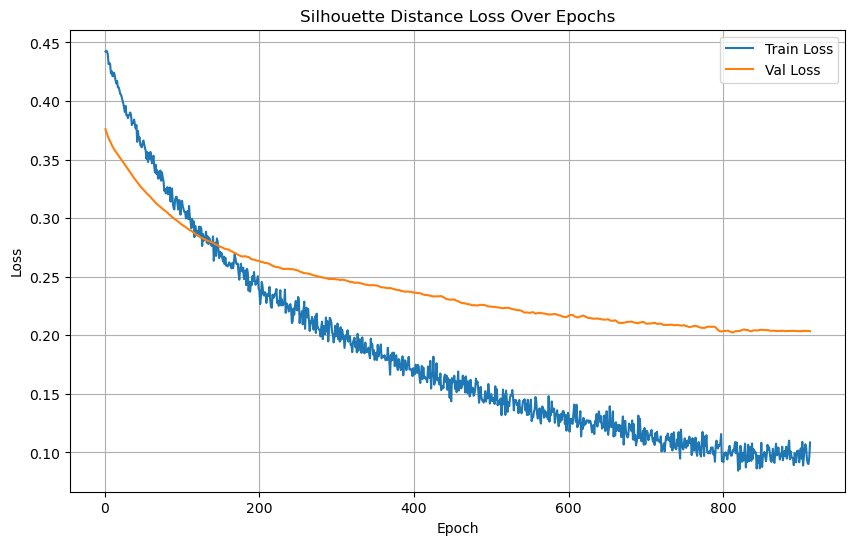

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2309], Loss: 0.0638
Test Batch [20/2309], Loss: 0.0464
Test Batch [30/2309], Loss: 0.5000
Test Batch [40/2309], Loss: 0.0211
Test Batch [50/2309], Loss: 0.5000
Test Batch [60/2309], Loss: 0.5000


Test Batch [70/2309], Loss: 0.5000
Test Batch [80/2309], Loss: 0.0327
Test Batch [90/2309], Loss: 0.5000
Test Batch [100/2309], Loss: 0.0359
Test Batch [110/2309], Loss: 0.5000
Test Batch [120/2309], Loss: 0.0494
Test Batch [130/2309], Loss: 0.5000


Test Batch [140/2309], Loss: 0.5000
Test Batch [150/2309], Loss: 0.5000
Test Batch [160/2309], Loss: 0.0255
Test Batch [170/2309], Loss: 0.0229
Test Batch [180/2309], Loss: 0.5000
Test Batch [190/2309], Loss: 0.5000
Test Batch [200/2309], Loss: 0.0651
Test Batch [210/2309], Loss: 0.5000


Test Batch [220/2309], Loss: 0.5000
Test Batch [230/2309], Loss: 0.0373
Test Batch [240/2309], Loss: 0.5000
Test Batch [250/2309], Loss: 0.0542
Test Batch [260/2309], Loss: 0.0508
Test Batch [270/2309], Loss: 0.5000


Test Batch [280/2309], Loss: 0.5000
Test Batch [290/2309], Loss: 0.5000
Test Batch [300/2309], Loss: 0.0532
Test Batch [310/2309], Loss: 0.5000
Test Batch [320/2309], Loss: 0.0507
Test Batch [330/2309], Loss: 0.5000
Test Batch [340/2309], Loss: 0.5000
Test Batch [350/2309], Loss: 0.0179


Test Batch [360/2309], Loss: 0.0988
Test Batch [370/2309], Loss: 0.0386
Test Batch [380/2309], Loss: 0.0695
Test Batch [390/2309], Loss: 0.0514
Test Batch [400/2309], Loss: 0.0352
Test Batch [410/2309], Loss: 0.5000
Test Batch [420/2309], Loss: 0.0622


Test Batch [430/2309], Loss: 0.0305
Test Batch [440/2309], Loss: 0.5000
Test Batch [450/2309], Loss: 0.0670
Test Batch [460/2309], Loss: 0.5000
Test Batch [470/2309], Loss: 0.5000


Test Batch [480/2309], Loss: 0.0572
Test Batch [490/2309], Loss: 0.5000
Test Batch [500/2309], Loss: 0.0464
Test Batch [510/2309], Loss: 0.5000
Test Batch [520/2309], Loss: 0.0675
Test Batch [530/2309], Loss: 0.0359
Test Batch [540/2309], Loss: 0.5000


Test Batch [550/2309], Loss: 0.0406
Test Batch [560/2309], Loss: 0.0540
Test Batch [570/2309], Loss: 0.5000
Test Batch [580/2309], Loss: 0.5000
Test Batch [590/2309], Loss: 0.0671
Test Batch [600/2309], Loss: 0.0400


Test Batch [610/2309], Loss: 0.5000
Test Batch [620/2309], Loss: 0.5000
Test Batch [630/2309], Loss: 0.5000
Test Batch [640/2309], Loss: 0.0291
Test Batch [650/2309], Loss: 0.5000
Test Batch [660/2309], Loss: 0.0588


Test Batch [670/2309], Loss: 0.5000
Test Batch [680/2309], Loss: 0.0415
Test Batch [690/2309], Loss: 0.0894
Test Batch [700/2309], Loss: 0.5000
Test Batch [710/2309], Loss: 0.0387
Test Batch [720/2309], Loss: 0.5000
Test Batch [730/2309], Loss: 0.0472


Test Batch [740/2309], Loss: 0.5000
Test Batch [750/2309], Loss: 0.5000
Test Batch [760/2309], Loss: 0.0488
Test Batch [770/2309], Loss: 0.0504
Test Batch [780/2309], Loss: 0.5000


Test Batch [790/2309], Loss: 0.5000
Test Batch [800/2309], Loss: 0.0124
Test Batch [810/2309], Loss: 0.0325
Test Batch [820/2309], Loss: 0.0302
Test Batch [830/2309], Loss: 0.5000


Test Batch [840/2309], Loss: 0.0605
Test Batch [850/2309], Loss: 0.1852
Test Batch [860/2309], Loss: 0.1001
Test Batch [870/2309], Loss: 0.0247
Test Batch [880/2309], Loss: 0.5000
Test Batch [890/2309], Loss: 0.0257
Test Batch [900/2309], Loss: 0.5000
Test Batch [910/2309], Loss: 0.5000


Test Batch [920/2309], Loss: 0.0759
Test Batch [930/2309], Loss: 0.0319
Test Batch [940/2309], Loss: 0.5000
Test Batch [950/2309], Loss: 0.0108
Test Batch [960/2309], Loss: 0.0180
Test Batch [970/2309], Loss: 0.0706
Test Batch [980/2309], Loss: 0.0820


Test Batch [990/2309], Loss: 0.5000
Test Batch [1000/2309], Loss: 0.0759
Test Batch [1010/2309], Loss: 0.5000
Test Batch [1020/2309], Loss: 0.0307
Test Batch [1030/2309], Loss: 0.5000
Test Batch [1040/2309], Loss: 0.5000


Test Batch [1050/2309], Loss: 0.0323
Test Batch [1060/2309], Loss: 0.0738
Test Batch [1070/2309], Loss: 0.1021
Test Batch [1080/2309], Loss: 0.0991
Test Batch [1090/2309], Loss: 0.0163
Test Batch [1100/2309], Loss: 0.5000


Test Batch [1110/2309], Loss: 0.5000
Test Batch [1120/2309], Loss: 0.0809
Test Batch [1130/2309], Loss: 0.0202
Test Batch [1140/2309], Loss: 0.0466


Test Batch [1150/2309], Loss: 0.1155
Test Batch [1160/2309], Loss: 0.0844
Test Batch [1170/2309], Loss: 0.0973
Test Batch [1180/2309], Loss: 0.5000
Test Batch [1190/2309], Loss: 0.0520


Test Batch [1200/2309], Loss: 0.0591
Test Batch [1210/2309], Loss: 0.0545
Test Batch [1220/2309], Loss: 0.0230
Test Batch [1230/2309], Loss: 0.0191


Test Batch [1240/2309], Loss: 0.1438
Test Batch [1250/2309], Loss: 0.5000
Test Batch [1260/2309], Loss: 0.1138
Test Batch [1270/2309], Loss: 0.0398


Test Batch [1280/2309], Loss: 0.0475
Test Batch [1290/2309], Loss: 0.0428
Test Batch [1300/2309], Loss: 0.0981
Test Batch [1310/2309], Loss: 0.0631


Test Batch [1320/2309], Loss: 0.1147
Test Batch [1330/2309], Loss: 0.0749
Test Batch [1340/2309], Loss: 0.0233
Test Batch [1350/2309], Loss: 0.0948


Test Batch [1360/2309], Loss: 0.1776
Test Batch [1370/2309], Loss: 0.0836
Test Batch [1380/2309], Loss: 0.1018


Test Batch [1390/2309], Loss: 0.0629
Test Batch [1400/2309], Loss: 0.0819
Test Batch [1410/2309], Loss: 0.0784
Test Batch [1420/2309], Loss: 0.0721


Test Batch [1430/2309], Loss: 0.5000
Test Batch [1440/2309], Loss: 0.0290
Test Batch [1450/2309], Loss: 0.1094


Test Batch [1460/2309], Loss: 0.0601
Test Batch [1470/2309], Loss: 0.0601
Test Batch [1480/2309], Loss: 0.0810
Test Batch [1490/2309], Loss: 0.0597
Test Batch [1500/2309], Loss: 0.0581


Test Batch [1510/2309], Loss: 0.0450
Test Batch [1520/2309], Loss: 0.5000
Test Batch [1530/2309], Loss: 0.0423
Test Batch [1540/2309], Loss: 0.0524


Test Batch [1550/2309], Loss: 0.0457
Test Batch [1560/2309], Loss: 0.0377
Test Batch [1570/2309], Loss: 0.0859


Test Batch [1580/2309], Loss: 0.0708
Test Batch [1590/2309], Loss: 0.0529
Test Batch [1600/2309], Loss: 0.0434
Test Batch [1610/2309], Loss: 0.0687


Test Batch [1620/2309], Loss: 0.1289
Test Batch [1630/2309], Loss: 0.1957
Test Batch [1640/2309], Loss: 0.1686
Test Batch [1650/2309], Loss: 0.0286


Test Batch [1660/2309], Loss: 0.1132
Test Batch [1670/2309], Loss: 0.0952
Test Batch [1680/2309], Loss: 0.0646
Test Batch [1690/2309], Loss: 0.0580


Test Batch [1700/2309], Loss: 0.0594
Test Batch [1710/2309], Loss: 0.0366
Test Batch [1720/2309], Loss: 0.0622
Test Batch [1730/2309], Loss: 0.0840
Test Batch [1740/2309], Loss: 0.5000
Test Batch [1750/2309], Loss: 0.0318
Test Batch [1760/2309], Loss: 0.0312


Test Batch [1770/2309], Loss: 0.0288
Test Batch [1780/2309], Loss: 0.0342
Test Batch [1790/2309], Loss: 0.0405
Test Batch [1800/2309], Loss: 0.0694
Test Batch [1810/2309], Loss: 0.1117
Test Batch [1820/2309], Loss: 0.0827


Test Batch [1830/2309], Loss: 0.0622
Test Batch [1840/2309], Loss: 0.5000
Test Batch [1850/2309], Loss: 0.1081
Test Batch [1860/2309], Loss: 0.0476
Test Batch [1870/2309], Loss: 0.0729


Test Batch [1880/2309], Loss: 0.0544
Test Batch [1890/2309], Loss: 0.0688
Test Batch [1900/2309], Loss: 0.1101
Test Batch [1910/2309], Loss: 0.1114


Test Batch [1920/2309], Loss: 0.0997
Test Batch [1930/2309], Loss: 0.0885
Test Batch [1940/2309], Loss: 0.0565
Test Batch [1950/2309], Loss: 0.0768
Test Batch [1960/2309], Loss: 0.1318
Test Batch [1970/2309], Loss: 0.0749


Test Batch [1980/2309], Loss: 0.0340
Test Batch [1990/2309], Loss: 0.0268
Test Batch [2000/2309], Loss: 0.0328
Test Batch [2010/2309], Loss: 0.0261
Test Batch [2020/2309], Loss: 0.0289


Test Batch [2030/2309], Loss: 0.0495
Test Batch [2040/2309], Loss: 0.0610
Test Batch [2050/2309], Loss: 0.0361
Test Batch [2060/2309], Loss: 0.1036
Test Batch [2070/2309], Loss: 0.0501
Test Batch [2080/2309], Loss: 0.1773


Test Batch [2090/2309], Loss: 0.5000
Test Batch [2100/2309], Loss: 0.0830
Test Batch [2110/2309], Loss: 0.0824
Test Batch [2120/2309], Loss: 0.1379
Test Batch [2130/2309], Loss: 0.5000
Test Batch [2140/2309], Loss: 0.5000


Test Batch [2150/2309], Loss: 0.5000
Test Batch [2160/2309], Loss: 0.5000
Test Batch [2170/2309], Loss: 0.0261
Test Batch [2180/2309], Loss: 0.0489
Test Batch [2190/2309], Loss: 0.0317


Test Batch [2200/2309], Loss: 0.0936
Test Batch [2210/2309], Loss: 0.5000
Test Batch [2220/2309], Loss: 0.5000
Test Batch [2230/2309], Loss: 0.5000
Test Batch [2240/2309], Loss: 0.5000
Test Batch [2250/2309], Loss: 0.5000
Test Batch [2260/2309], Loss: 0.5000


Test Batch [2270/2309], Loss: 0.5000
Test Batch [2280/2309], Loss: 0.0709
Test Batch [2290/2309], Loss: 0.5000
Test Batch [2300/2309], Loss: 0.5000

Test Loss: 0.1923


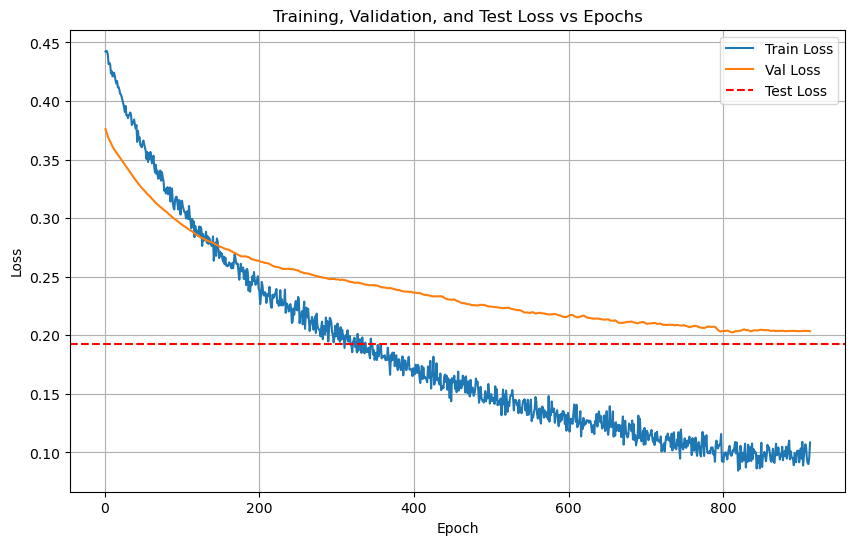

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2309 for test dataset.
  Processed batch 20/2309 for test dataset.


  Processed batch 30/2309 for test dataset.
  Processed batch 40/2309 for test dataset.
  Processed batch 50/2309 for test dataset.
  Processed batch 60/2309 for test dataset.


  Processed batch 70/2309 for test dataset.
  Processed batch 80/2309 for test dataset.
  Processed batch 90/2309 for test dataset.
  Processed batch 100/2309 for test dataset.


  Processed batch 110/2309 for test dataset.
  Processed batch 120/2309 for test dataset.
  Processed batch 130/2309 for test dataset.


  Processed batch 140/2309 for test dataset.
  Processed batch 150/2309 for test dataset.
  Processed batch 160/2309 for test dataset.


  Processed batch 170/2309 for test dataset.
  Processed batch 180/2309 for test dataset.
  Processed batch 190/2309 for test dataset.
  Processed batch 200/2309 for test dataset.


  Processed batch 210/2309 for test dataset.
  Processed batch 220/2309 for test dataset.


  Processed batch 230/2309 for test dataset.
  Processed batch 240/2309 for test dataset.
  Processed batch 250/2309 for test dataset.


  Processed batch 260/2309 for test dataset.
  Processed batch 270/2309 for test dataset.
  Processed batch 280/2309 for test dataset.


  Processed batch 290/2309 for test dataset.
  Processed batch 300/2309 for test dataset.
  Processed batch 310/2309 for test dataset.
  Processed batch 320/2309 for test dataset.


  Processed batch 330/2309 for test dataset.
  Processed batch 340/2309 for test dataset.
  Processed batch 350/2309 for test dataset.
  Processed batch 360/2309 for test dataset.


  Processed batch 370/2309 for test dataset.
  Processed batch 380/2309 for test dataset.


  Processed batch 390/2309 for test dataset.
  Processed batch 400/2309 for test dataset.
  Processed batch 410/2309 for test dataset.


  Processed batch 420/2309 for test dataset.
  Processed batch 430/2309 for test dataset.
  Processed batch 440/2309 for test dataset.


  Processed batch 450/2309 for test dataset.
  Processed batch 460/2309 for test dataset.
  Processed batch 470/2309 for test dataset.


  Processed batch 480/2309 for test dataset.
  Processed batch 490/2309 for test dataset.
  Processed batch 500/2309 for test dataset.


  Processed batch 510/2309 for test dataset.
  Processed batch 520/2309 for test dataset.
  Processed batch 530/2309 for test dataset.


  Processed batch 540/2309 for test dataset.
  Processed batch 550/2309 for test dataset.


  Processed batch 560/2309 for test dataset.
  Processed batch 570/2309 for test dataset.
  Processed batch 580/2309 for test dataset.


  Processed batch 590/2309 for test dataset.
  Processed batch 600/2309 for test dataset.
  Processed batch 610/2309 for test dataset.
  Processed batch 620/2309 for test dataset.


  Processed batch 630/2309 for test dataset.
  Processed batch 640/2309 for test dataset.
  Processed batch 650/2309 for test dataset.
  Processed batch 660/2309 for test dataset.


  Processed batch 670/2309 for test dataset.
  Processed batch 680/2309 for test dataset.
  Processed batch 690/2309 for test dataset.


  Processed batch 700/2309 for test dataset.
  Processed batch 710/2309 for test dataset.
  Processed batch 720/2309 for test dataset.
  Processed batch 730/2309 for test dataset.


  Processed batch 740/2309 for test dataset.
  Processed batch 750/2309 for test dataset.
  Processed batch 760/2309 for test dataset.


  Processed batch 770/2309 for test dataset.
  Processed batch 780/2309 for test dataset.
  Processed batch 790/2309 for test dataset.
  Processed batch 800/2309 for test dataset.


  Processed batch 810/2309 for test dataset.
  Processed batch 820/2309 for test dataset.
  Processed batch 830/2309 for test dataset.


  Processed batch 840/2309 for test dataset.
  Processed batch 850/2309 for test dataset.
  Processed batch 860/2309 for test dataset.
  Processed batch 870/2309 for test dataset.


  Processed batch 880/2309 for test dataset.
  Processed batch 890/2309 for test dataset.
  Processed batch 900/2309 for test dataset.
  Processed batch 910/2309 for test dataset.


  Processed batch 920/2309 for test dataset.
  Processed batch 930/2309 for test dataset.
  Processed batch 940/2309 for test dataset.


  Processed batch 950/2309 for test dataset.
  Processed batch 960/2309 for test dataset.
  Processed batch 970/2309 for test dataset.


  Processed batch 980/2309 for test dataset.
  Processed batch 990/2309 for test dataset.


  Processed batch 1000/2309 for test dataset.
  Processed batch 1010/2309 for test dataset.
  Processed batch 1020/2309 for test dataset.
  Processed batch 1030/2309 for test dataset.


  Processed batch 1040/2309 for test dataset.
  Processed batch 1050/2309 for test dataset.
  Processed batch 1060/2309 for test dataset.
  Processed batch 1070/2309 for test dataset.


  Processed batch 1080/2309 for test dataset.
  Processed batch 1090/2309 for test dataset.
  Processed batch 1100/2309 for test dataset.


  Processed batch 1110/2309 for test dataset.
  Processed batch 1120/2309 for test dataset.
  Processed batch 1130/2309 for test dataset.
  Processed batch 1140/2309 for test dataset.


  Processed batch 1150/2309 for test dataset.
  Processed batch 1160/2309 for test dataset.
  Processed batch 1170/2309 for test dataset.


  Processed batch 1180/2309 for test dataset.
  Processed batch 1190/2309 for test dataset.
  Processed batch 1200/2309 for test dataset.


  Processed batch 1210/2309 for test dataset.
  Processed batch 1220/2309 for test dataset.
  Processed batch 1230/2309 for test dataset.
  Processed batch 1240/2309 for test dataset.


  Processed batch 1250/2309 for test dataset.
  Processed batch 1260/2309 for test dataset.
  Processed batch 1270/2309 for test dataset.


  Processed batch 1280/2309 for test dataset.
  Processed batch 1290/2309 for test dataset.
  Processed batch 1300/2309 for test dataset.


  Processed batch 1310/2309 for test dataset.
  Processed batch 1320/2309 for test dataset.
  Processed batch 1330/2309 for test dataset.


  Processed batch 1340/2309 for test dataset.
  Processed batch 1350/2309 for test dataset.
  Processed batch 1360/2309 for test dataset.


  Processed batch 1370/2309 for test dataset.
  Processed batch 1380/2309 for test dataset.
  Processed batch 1390/2309 for test dataset.


  Processed batch 1400/2309 for test dataset.
  Processed batch 1410/2309 for test dataset.
  Processed batch 1420/2309 for test dataset.


  Processed batch 1430/2309 for test dataset.
  Processed batch 1440/2309 for test dataset.
  Processed batch 1450/2309 for test dataset.
  Processed batch 1460/2309 for test dataset.


  Processed batch 1470/2309 for test dataset.
  Processed batch 1480/2309 for test dataset.
  Processed batch 1490/2309 for test dataset.
  Processed batch 1500/2309 for test dataset.


  Processed batch 1510/2309 for test dataset.
  Processed batch 1520/2309 for test dataset.
  Processed batch 1530/2309 for test dataset.
  Processed batch 1540/2309 for test dataset.


  Processed batch 1550/2309 for test dataset.
  Processed batch 1560/2309 for test dataset.
  Processed batch 1570/2309 for test dataset.
  Processed batch 1580/2309 for test dataset.


  Processed batch 1590/2309 for test dataset.
  Processed batch 1600/2309 for test dataset.
  Processed batch 1610/2309 for test dataset.


  Processed batch 1620/2309 for test dataset.
  Processed batch 1630/2309 for test dataset.
  Processed batch 1640/2309 for test dataset.


  Processed batch 1650/2309 for test dataset.
  Processed batch 1660/2309 for test dataset.
  Processed batch 1670/2309 for test dataset.


  Processed batch 1680/2309 for test dataset.
  Processed batch 1690/2309 for test dataset.
  Processed batch 1700/2309 for test dataset.
  Processed batch 1710/2309 for test dataset.


  Processed batch 1720/2309 for test dataset.
  Processed batch 1730/2309 for test dataset.
  Processed batch 1740/2309 for test dataset.
  Processed batch 1750/2309 for test dataset.


  Processed batch 1760/2309 for test dataset.
  Processed batch 1770/2309 for test dataset.
  Processed batch 1780/2309 for test dataset.


  Processed batch 1790/2309 for test dataset.
  Processed batch 1800/2309 for test dataset.
  Processed batch 1810/2309 for test dataset.


  Processed batch 1820/2309 for test dataset.
  Processed batch 1830/2309 for test dataset.
  Processed batch 1840/2309 for test dataset.
  Processed batch 1850/2309 for test dataset.


  Processed batch 1860/2309 for test dataset.
  Processed batch 1870/2309 for test dataset.
  Processed batch 1880/2309 for test dataset.


  Processed batch 1890/2309 for test dataset.
  Processed batch 1900/2309 for test dataset.
  Processed batch 1910/2309 for test dataset.


  Processed batch 1920/2309 for test dataset.
  Processed batch 1930/2309 for test dataset.
  Processed batch 1940/2309 for test dataset.


  Processed batch 1950/2309 for test dataset.
  Processed batch 1960/2309 for test dataset.
  Processed batch 1970/2309 for test dataset.
  Processed batch 1980/2309 for test dataset.


  Processed batch 1990/2309 for test dataset.
  Processed batch 2000/2309 for test dataset.
  Processed batch 2010/2309 for test dataset.
  Processed batch 2020/2309 for test dataset.


  Processed batch 2030/2309 for test dataset.
  Processed batch 2040/2309 for test dataset.
  Processed batch 2050/2309 for test dataset.


  Processed batch 2060/2309 for test dataset.
  Processed batch 2070/2309 for test dataset.
  Processed batch 2080/2309 for test dataset.
  Processed batch 2090/2309 for test dataset.


  Processed batch 2100/2309 for test dataset.
  Processed batch 2110/2309 for test dataset.
  Processed batch 2120/2309 for test dataset.
  Processed batch 2130/2309 for test dataset.


  Processed batch 2140/2309 for test dataset.
  Processed batch 2150/2309 for test dataset.
  Processed batch 2160/2309 for test dataset.


  Processed batch 2170/2309 for test dataset.
  Processed batch 2180/2309 for test dataset.


  Processed batch 2190/2309 for test dataset.
  Processed batch 2200/2309 for test dataset.
  Processed batch 2210/2309 for test dataset.
  Processed batch 2220/2309 for test dataset.


  Processed batch 2230/2309 for test dataset.
  Processed batch 2240/2309 for test dataset.
  Processed batch 2250/2309 for test dataset.


  Processed batch 2260/2309 for test dataset.
  Processed batch 2270/2309 for test dataset.
  Processed batch 2280/2309 for test dataset.
  Processed batch 2290/2309 for test dataset.


  Processed batch 2300/2309 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.67      0.80      0.73         5
           4       0.67      0.80      0.73         5
           5       1.00      0.80      0.89         5
           6       0.80      0.80      0.80         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45


LOG: Evaluating on the test set...
Test Accuracy: 96.45%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65926
           1       0.93      0.94      0.94      7553
           2       0.85      0.79      0.82      3045
           3       0.65      0.88      0.75      2640
           4       0.81      0.93      0.86      6539
           5       0.92      0.93      0.92      9203
           6       0.91      0.86      0.88      7242
           7       1.00      0.97      0.98     42781
           8       0.98      0.99      0.98      2818

    accuracy                           0.96    147747
   macro avg       0.89      0.92      0.90    147747
weighted avg       0.97      0.96      0.97    147747

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7354  |  Val Loss: 2.6902
Validation loss improved from inf to 2.6902.
[Epoch 2/1000] Train Loss: 2.5652  |  Val Loss: 2.5461
Validation loss improved from 2.6902 to 2.5461.
[Epoch 3/1000] Train Loss: 2.4127  |  Val Loss: 2.4155
Validation loss improved from 2.5461 to 2.4155.
[Epoch 4/1000] Train Loss: 2.2758  |  Val Loss: 2.2939
Validation loss improved from 2.4155 to 2.2939.
[Epoch 5/1000] Train Loss: 2.1519  |  Val Loss: 2.1841
Validation loss improved from 2.2939 to 2.1841.
[Epoch 6/1000] Train Loss: 2.0371  |  Val Loss: 2.0807
Validation loss improved from 2.1841 to 2.0807.
[Epoch 7/1000] Train Loss: 1.9298  |  Val Loss: 1.9898
Validation loss improved from 2.0807 to 1.9898.
[Epoch 8/1000] Train Loss: 1.8403  |  Val Loss: 1.9108
Validation loss improved from 1.9898 to 1.9108.
[Epoch 9/1000] Train Loss: 1.7588  |  Val Loss: 1.8372
Validation loss improved from 1.9108 to 1.8372.
[Epoch 10/1000] Train Loss: 1.6821  |  Val Loss: 1.7713
Validation loss impr

[Epoch 12/1000] Train Loss: 1.5486  |  Val Loss: 1.6523
Validation loss improved from 1.7100 to 1.6523.
[Epoch 13/1000] Train Loss: 1.4876  |  Val Loss: 1.5977
Validation loss improved from 1.6523 to 1.5977.
[Epoch 14/1000] Train Loss: 1.4295  |  Val Loss: 1.5455
Validation loss improved from 1.5977 to 1.5455.
[Epoch 15/1000] Train Loss: 1.3750  |  Val Loss: 1.4969
Validation loss improved from 1.5455 to 1.4969.
[Epoch 16/1000] Train Loss: 1.3233  |  Val Loss: 1.4509
Validation loss improved from 1.4969 to 1.4509.
[Epoch 17/1000] Train Loss: 1.2748  |  Val Loss: 1.4063
Validation loss improved from 1.4509 to 1.4063.


[Epoch 18/1000] Train Loss: 1.2280  |  Val Loss: 1.3639
Validation loss improved from 1.4063 to 1.3639.
[Epoch 19/1000] Train Loss: 1.1839  |  Val Loss: 1.3236
Validation loss improved from 1.3639 to 1.3236.
[Epoch 20/1000] Train Loss: 1.1413  |  Val Loss: 1.2856
Validation loss improved from 1.3236 to 1.2856.
[Epoch 21/1000] Train Loss: 1.1004  |  Val Loss: 1.2498
Validation loss improved from 1.2856 to 1.2498.
[Epoch 22/1000] Train Loss: 1.0623  |  Val Loss: 1.2148
Validation loss improved from 1.2498 to 1.2148.
[Epoch 23/1000] Train Loss: 1.0246  |  Val Loss: 1.1792
Validation loss improved from 1.2148 to 1.1792.
[Epoch 24/1000] Train Loss: 0.9880  |  Val Loss: 1.1464
Validation loss improved from 1.1792 to 1.1464.
[Epoch 25/1000] Train Loss: 0.9546  |  Val Loss: 1.1153
Validation loss improved from 1.1464 to 1.1153.
[Epoch 26/1000] Train Loss: 0.9233  |  Val Loss: 1.0871
Validation loss improved from 1.1153 to 1.0871.
[Epoch 27/1000] Train Loss: 0.8931  |  Val Loss: 1.0597
Validati

[Epoch 29/1000] Train Loss: 0.8380  |  Val Loss: 1.0109
Validation loss improved from 1.0351 to 1.0109.
[Epoch 30/1000] Train Loss: 0.8121  |  Val Loss: 0.9878
Validation loss improved from 1.0109 to 0.9878.
[Epoch 31/1000] Train Loss: 0.7871  |  Val Loss: 0.9654
Validation loss improved from 0.9878 to 0.9654.
[Epoch 32/1000] Train Loss: 0.7630  |  Val Loss: 0.9454
Validation loss improved from 0.9654 to 0.9454.
[Epoch 33/1000] Train Loss: 0.7400  |  Val Loss: 0.9260
Validation loss improved from 0.9454 to 0.9260.


[Epoch 34/1000] Train Loss: 0.7183  |  Val Loss: 0.9087
Validation loss improved from 0.9260 to 0.9087.
[Epoch 35/1000] Train Loss: 0.6981  |  Val Loss: 0.8924
Validation loss improved from 0.9087 to 0.8924.
[Epoch 36/1000] Train Loss: 0.6789  |  Val Loss: 0.8785
Validation loss improved from 0.8924 to 0.8785.
[Epoch 37/1000] Train Loss: 0.6603  |  Val Loss: 0.8645
Validation loss improved from 0.8785 to 0.8645.
[Epoch 38/1000] Train Loss: 0.6429  |  Val Loss: 0.8515
Validation loss improved from 0.8645 to 0.8515.
[Epoch 39/1000] Train Loss: 0.6267  |  Val Loss: 0.8402
Validation loss improved from 0.8515 to 0.8402.
[Epoch 40/1000] Train Loss: 0.6109  |  Val Loss: 0.8290
Validation loss improved from 0.8402 to 0.8290.
[Epoch 41/1000] Train Loss: 0.5962  |  Val Loss: 0.8184
Validation loss improved from 0.8290 to 0.8184.
[Epoch 42/1000] Train Loss: 0.5819  |  Val Loss: 0.8073
Validation loss improved from 0.8184 to 0.8073.
[Epoch 43/1000] Train Loss: 0.5683  |  Val Loss: 0.7955
Validati

[Epoch 45/1000] Train Loss: 0.5418  |  Val Loss: 0.7761
Validation loss improved from 0.7852 to 0.7761.
[Epoch 46/1000] Train Loss: 0.5291  |  Val Loss: 0.7692
Validation loss improved from 0.7761 to 0.7692.
[Epoch 47/1000] Train Loss: 0.5165  |  Val Loss: 0.7603
Validation loss improved from 0.7692 to 0.7603.
[Epoch 48/1000] Train Loss: 0.5046  |  Val Loss: 0.7503
Validation loss improved from 0.7603 to 0.7503.
[Epoch 49/1000] Train Loss: 0.4925  |  Val Loss: 0.7418
Validation loss improved from 0.7503 to 0.7418.


[Epoch 50/1000] Train Loss: 0.4808  |  Val Loss: 0.7331
Validation loss improved from 0.7418 to 0.7331.
[Epoch 51/1000] Train Loss: 0.4696  |  Val Loss: 0.7234
Validation loss improved from 0.7331 to 0.7234.
[Epoch 52/1000] Train Loss: 0.4579  |  Val Loss: 0.7157
Validation loss improved from 0.7234 to 0.7157.
[Epoch 53/1000] Train Loss: 0.4470  |  Val Loss: 0.7086
Validation loss improved from 0.7157 to 0.7086.
[Epoch 54/1000] Train Loss: 0.4360  |  Val Loss: 0.7002
Validation loss improved from 0.7086 to 0.7002.
[Epoch 55/1000] Train Loss: 0.4252  |  Val Loss: 0.6933
Validation loss improved from 0.7002 to 0.6933.
[Epoch 56/1000] Train Loss: 0.4145  |  Val Loss: 0.6893
Validation loss improved from 0.6933 to 0.6893.
[Epoch 57/1000] Train Loss: 0.4042  |  Val Loss: 0.6831
Validation loss improved from 0.6893 to 0.6831.
[Epoch 58/1000] Train Loss: 0.3937  |  Val Loss: 0.6765
Validation loss improved from 0.6831 to 0.6765.
[Epoch 59/1000] Train Loss: 0.3839  |  Val Loss: 0.6701
Validati

[Epoch 62/1000] Train Loss: 0.3539  |  Val Loss: 0.6531
Validation loss improved from 0.6589 to 0.6531.
[Epoch 63/1000] Train Loss: 0.3442  |  Val Loss: 0.6448
Validation loss improved from 0.6531 to 0.6448.
[Epoch 64/1000] Train Loss: 0.3347  |  Val Loss: 0.6363
Validation loss improved from 0.6448 to 0.6363.
[Epoch 65/1000] Train Loss: 0.3250  |  Val Loss: 0.6294
Validation loss improved from 0.6363 to 0.6294.
[Epoch 66/1000] Train Loss: 0.3155  |  Val Loss: 0.6236
Validation loss improved from 0.6294 to 0.6236.


[Epoch 67/1000] Train Loss: 0.3060  |  Val Loss: 0.6154
Validation loss improved from 0.6236 to 0.6154.
[Epoch 68/1000] Train Loss: 0.2970  |  Val Loss: 0.6071
Validation loss improved from 0.6154 to 0.6071.
[Epoch 69/1000] Train Loss: 0.2879  |  Val Loss: 0.6026
Validation loss improved from 0.6071 to 0.6026.
[Epoch 70/1000] Train Loss: 0.2790  |  Val Loss: 0.5976
Validation loss improved from 0.6026 to 0.5976.
[Epoch 71/1000] Train Loss: 0.2709  |  Val Loss: 0.5943
Validation loss improved from 0.5976 to 0.5943.
[Epoch 72/1000] Train Loss: 0.2621  |  Val Loss: 0.5856
Validation loss improved from 0.5943 to 0.5856.
[Epoch 73/1000] Train Loss: 0.2536  |  Val Loss: 0.5798
Validation loss improved from 0.5856 to 0.5798.
[Epoch 74/1000] Train Loss: 0.2462  |  Val Loss: 0.5776
Validation loss improved from 0.5798 to 0.5776.
[Epoch 75/1000] Train Loss: 0.2376  |  Val Loss: 0.5706
Validation loss improved from 0.5776 to 0.5706.
[Epoch 76/1000] Train Loss: 0.2300  |  Val Loss: 0.5671
Validati

[Epoch 78/1000] Train Loss: 0.2152  |  Val Loss: 0.5553
Validation loss improved from 0.5614 to 0.5553.
[Epoch 79/1000] Train Loss: 0.2084  |  Val Loss: 0.5537
Validation loss improved from 0.5553 to 0.5537.
[Epoch 80/1000] Train Loss: 0.2017  |  Val Loss: 0.5492
Validation loss improved from 0.5537 to 0.5492.
[Epoch 81/1000] Train Loss: 0.1952  |  Val Loss: 0.5455
Validation loss improved from 0.5492 to 0.5455.
[Epoch 82/1000] Train Loss: 0.1889  |  Val Loss: 0.5389
Validation loss improved from 0.5455 to 0.5389.


[Epoch 83/1000] Train Loss: 0.1831  |  Val Loss: 0.5338
Validation loss improved from 0.5389 to 0.5338.
[Epoch 84/1000] Train Loss: 0.1771  |  Val Loss: 0.5307
Validation loss improved from 0.5338 to 0.5307.
[Epoch 85/1000] Train Loss: 0.1718  |  Val Loss: 0.5255
Validation loss improved from 0.5307 to 0.5255.
[Epoch 86/1000] Train Loss: 0.1667  |  Val Loss: 0.5226
Validation loss improved from 0.5255 to 0.5226.
[Epoch 87/1000] Train Loss: 0.1615  |  Val Loss: 0.5189
Validation loss improved from 0.5226 to 0.5189.
[Epoch 88/1000] Train Loss: 0.1564  |  Val Loss: 0.5215
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 89/1000] Train Loss: 0.1519  |  Val Loss: 0.5215
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 90/1000] Train Loss: 0.1472  |  Val Loss: 0.5185
Validation loss improved from 0.5189 to 0.5185.
[Epoch 91/1000] Train Loss: 0.1431  |  Val Loss: 0.5180
Validation loss improved from 0.5185 to 0.5180.
[Epoch 92/1000] Train Loss: 0.1388  |  Val Loss: 0.5

[Epoch 95/1000] Train Loss: 0.1279  |  Val Loss: 0.5036
Validation loss improved from 0.5102 to 0.5036.
[Epoch 96/1000] Train Loss: 0.1246  |  Val Loss: 0.5031
Validation loss improved from 0.5036 to 0.5031.
[Epoch 97/1000] Train Loss: 0.1217  |  Val Loss: 0.5071
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 0.1179  |  Val Loss: 0.5058
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 99/1000] Train Loss: 0.1149  |  Val Loss: 0.5035
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 100/1000] Train Loss: 0.1125  |  Val Loss: 0.5049
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 101/1000] Train Loss: 0.1097  |  Val Loss: 0.5012
Validation loss improved from 0.5031 to 0.5012.
[Epoch 102/1000] Train Loss: 0.1069  |  Val Loss: 0.5022
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 103/1000] Train Loss: 0.1046  |  Val Loss: 0.4991
Validation loss improved from 0.5012 to 0.4991.
[Epoch 104/1000] Train Loss: 0.1025  |  Val Loss: 0.5035
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 105/1000] Train Loss: 0.0997  |  Val Loss: 0.5054
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 106/1000] Train Loss: 0.0975  |  Val Loss: 0.5036
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 107/1000] Train Loss: 0.0957  |  Val Loss: 0.5097
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 108/1000] Train Loss: 0.0933  |  Val Loss: 0.5090
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 109/10

[Epoch 111/1000] Train Loss: 0.0880  |  Val Loss: 0.5103
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 112/1000] Train Loss: 0.0861  |  Val Loss: 0.5112
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 113/1000] Train Loss: 0.0843  |  Val Loss: 0.5088
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 114/1000] Train Loss: 0.0827  |  Val Loss: 0.5076
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 115/1000] Train Loss: 0.0814  |  Val Loss: 0.5054
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 116/1000] Train Loss: 0.0799  |  Val Loss: 0.5109
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 117/1000] Train Loss: 0.0785  |  Val Loss: 0.5106
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 118/1000] Train Loss: 0.0773  |  Val Loss: 0.5203
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 119/1000] Train Loss: 0.0758  |  Val Loss: 0.5202
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 120/1000] Train Loss: 0.0745  |  Val Loss: 0.5258
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 121/1000] Train Loss: 0.0732  |  Val Loss: 0.5281
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 122/1000] Train Loss: 0.0721  |  Val Loss: 0.5278
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 123/1000] Train Loss: 0.0709  |  Val Loss: 0.5221
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 124/1000] Train Loss: 0.0698  |  Val Loss: 0.5228
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 125/1000] Train Loss: 0.0689  |  Val Loss: 0.5192
!! Validation loss did NOT improve !! Patience:

[Epoch 128/1000] Train Loss: 0.0658  |  Val Loss: 0.5235
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 129/1000] Train Loss: 0.0647  |  Val Loss: 0.5305
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 130/1000] Train Loss: 0.0638  |  Val Loss: 0.5356
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 131/1000] Train Loss: 0.0629  |  Val Loss: 0.5395
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 132/1000] Train Loss: 0.0620  |  Val Loss: 0.5401
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 133/1000] Train Loss: 0.0613  |  Val Loss: 0.5376
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 134/1000] Train Loss: 0.0604  |  Val Loss: 0.5409
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 135/1000] Train Loss: 0.0595  |  Val Loss: 0.5391
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 136/1000] Train Loss: 0.0588  |  Val Loss: 0.5374
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 137/1000] Train Loss: 0.0580  |  Val Loss: 0.5388
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 138/1000] Train Loss: 0.0577  |  Val Loss: 0.5482
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 139/1000] Train Loss: 0.0566  |  Val Loss: 0.5481
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 140/1000] Train Loss: 0.0558  |  Val Loss: 0.5519
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 141/1000] Train Loss: 0.0552  |  Val Loss: 0.5534
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 142/1000] Train Loss: 0.0547  |  Val Loss: 0.5495
!! Validation loss did NOT improve !! Patience:

[Epoch 143/1000] Train Loss: 0.0541  |  Val Loss: 0.5580
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 144/1000] Train Loss: 0.0534  |  Val Loss: 0.5551
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 145/1000] Train Loss: 0.0525  |  Val Loss: 0.5580
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 146/1000] Train Loss: 0.0525  |  Val Loss: 0.5532
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 147/1000] Train Loss: 0.0512  |  Val Loss: 0.5638
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 148/1000] Train Loss: 0.0507  |  Val Loss: 0.5666
!! Validation loss did NOT improve !! Patience: 45/100


[Epoch 149/1000] Train Loss: 0.0503  |  Val Loss: 0.5646
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 150/1000] Train Loss: 0.0495  |  Val Loss: 0.5645
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 151/1000] Train Loss: 0.0491  |  Val Loss: 0.5616
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 152/1000] Train Loss: 0.0486  |  Val Loss: 0.5688
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 153/1000] Train Loss: 0.0480  |  Val Loss: 0.5682
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 154/1000] Train Loss: 0.0477  |  Val Loss: 0.5723
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 155/1000] Train Loss: 0.0469  |  Val Loss: 0.5702
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 156/1000] Train Loss: 0.0466  |  Val Loss: 0.5679
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 157/1000] Train Loss: 0.0463  |  Val Loss: 0.5760
!! Validation loss did NOT improve !! Patience:

[Epoch 160/1000] Train Loss: 0.0446  |  Val Loss: 0.5794
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 161/1000] Train Loss: 0.0445  |  Val Loss: 0.5840
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 162/1000] Train Loss: 0.0439  |  Val Loss: 0.5815
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 163/1000] Train Loss: 0.0433  |  Val Loss: 0.5858
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 164/1000] Train Loss: 0.0429  |  Val Loss: 0.5874
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 165/1000] Train Loss: 0.0425  |  Val Loss: 0.5894
!! Validation loss did NOT improve !! Patience: 62/100


[Epoch 166/1000] Train Loss: 0.0421  |  Val Loss: 0.5908
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 167/1000] Train Loss: 0.0417  |  Val Loss: 0.5902
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 168/1000] Train Loss: 0.0413  |  Val Loss: 0.5899
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 169/1000] Train Loss: 0.0409  |  Val Loss: 0.5905
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 170/1000] Train Loss: 0.0407  |  Val Loss: 0.5934
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 171/1000] Train Loss: 0.0403  |  Val Loss: 0.5907
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 172/1000] Train Loss: 0.0399  |  Val Loss: 0.5952
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 173/1000] Train Loss: 0.0396  |  Val Loss: 0.6003
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 174/1000] Train Loss: 0.0393  |  Val Loss: 0.5970
!! Validation loss did NOT improve !! Patience:

[Epoch 176/1000] Train Loss: 0.0386  |  Val Loss: 0.6105
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 177/1000] Train Loss: 0.0386  |  Val Loss: 0.6071
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 178/1000] Train Loss: 0.0384  |  Val Loss: 0.6192
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 179/1000] Train Loss: 0.0377  |  Val Loss: 0.6162
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 180/1000] Train Loss: 0.0372  |  Val Loss: 0.6121
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 181/1000] Train Loss: 0.0372  |  Val Loss: 0.6081
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 182/1000] Train Loss: 0.0370  |  Val Loss: 0.6060
!! Validation loss did NOT improve !! Patience: 79/100


[Epoch 183/1000] Train Loss: 0.0359  |  Val Loss: 0.6154
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 184/1000] Train Loss: 0.0370  |  Val Loss: 0.6329
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 185/1000] Train Loss: 0.0360  |  Val Loss: 0.6315
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 186/1000] Train Loss: 0.0356  |  Val Loss: 0.6222
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 187/1000] Train Loss: 0.0352  |  Val Loss: 0.6168
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 188/1000] Train Loss: 0.0349  |  Val Loss: 0.6147
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 189/1000] Train Loss: 0.0346  |  Val Loss: 0.6192
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 190/1000] Train Loss: 0.0347  |  Val Loss: 0.6174
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 191/1000] Train Loss: 0.0337  |  Val Loss: 0.6283
!! Validation loss did NOT improve !! Patience:

[Epoch 192/1000] Train Loss: 0.0342  |  Val Loss: 0.6432
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 193/1000] Train Loss: 0.0339  |  Val Loss: 0.6423
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 194/1000] Train Loss: 0.0340  |  Val Loss: 0.6310
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 195/1000] Train Loss: 0.0330  |  Val Loss: 0.6323
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 196/1000] Train Loss: 0.0327  |  Val Loss: 0.6337
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 197/1000] Train Loss: 0.0325  |  Val Loss: 0.6398
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 198/1000] Train Loss: 0.0322  |  Val Loss: 0.6407
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 199/1000] Train Loss: 0.0322  |  Val Loss: 0.6370
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 200/1000] Train Loss: 0.0318  |  Val Loss: 0.6415
!! Validation loss did NOT improve !! Patience:

[Epoch 201/1000] Train Loss: 0.0315  |  Val Loss: 0.6416
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 202/1000] Train Loss: 0.0315  |  Val Loss: 0.6501
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 203/1000] Train Loss: 0.0313  |  Val Loss: 0.6521
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 203 !!
No improvement for 100 epochs.


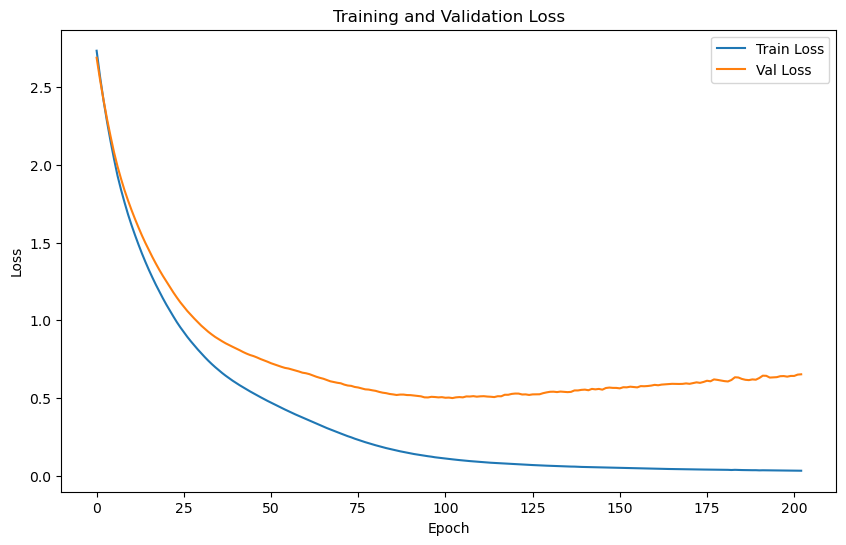

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.1208 | Test Accuracy: 96.66%


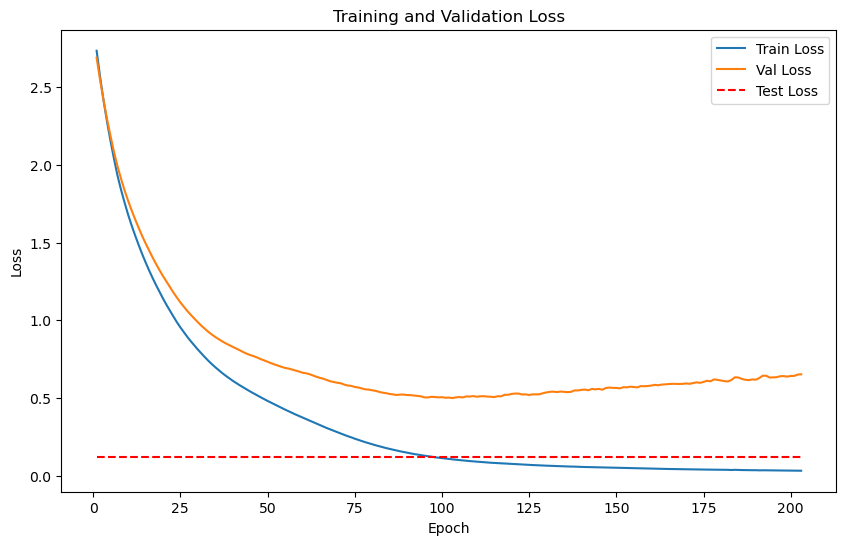

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


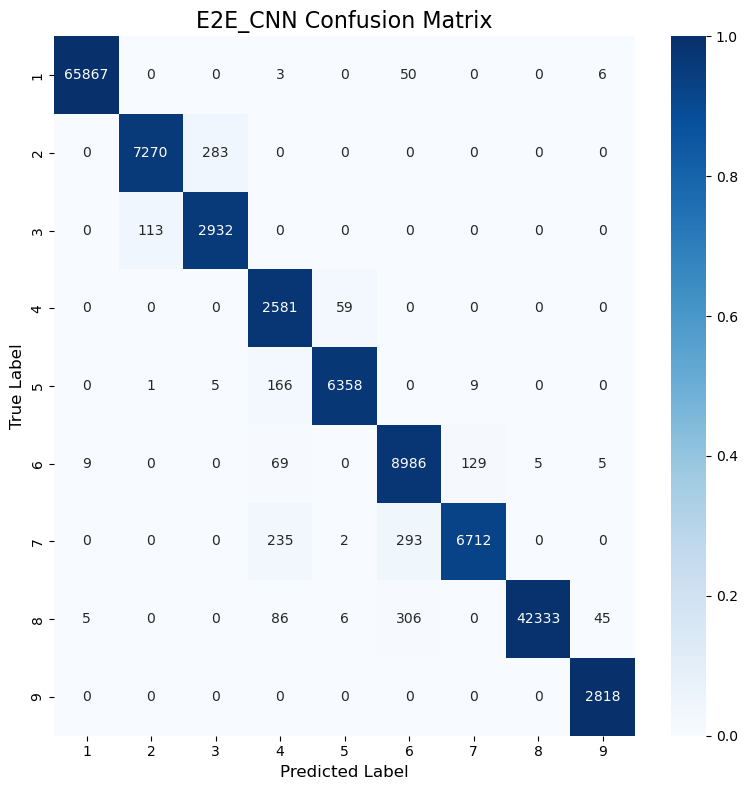

Classification Accuracy: 98.72%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


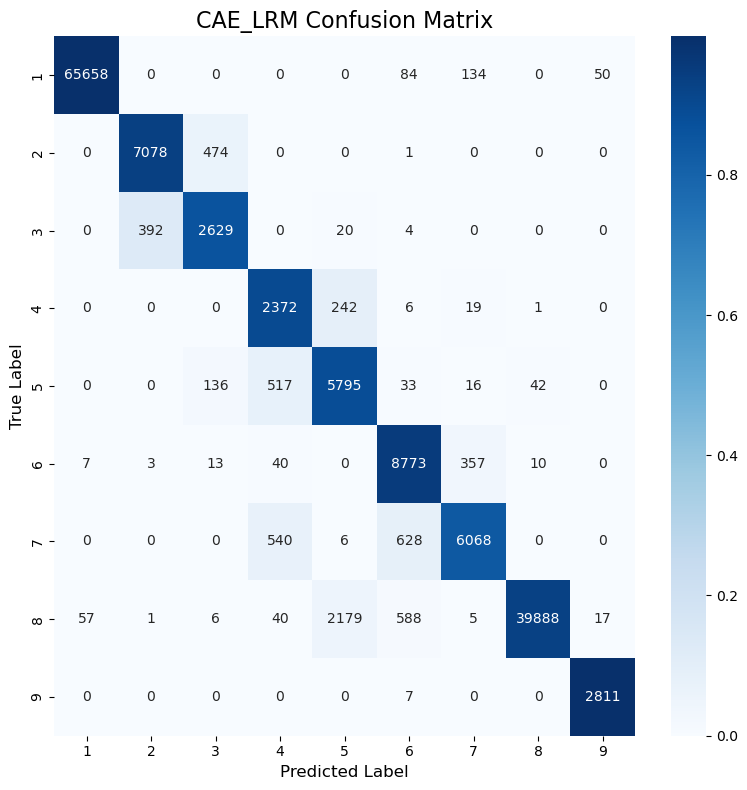

Classification Accuracy: 95.48%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


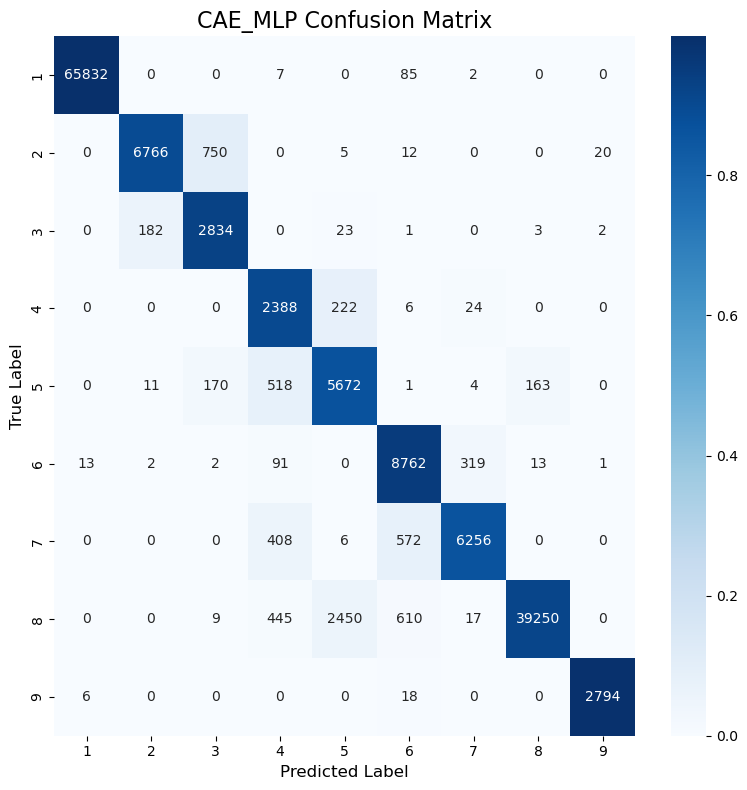

Classification Accuracy: 95.13%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


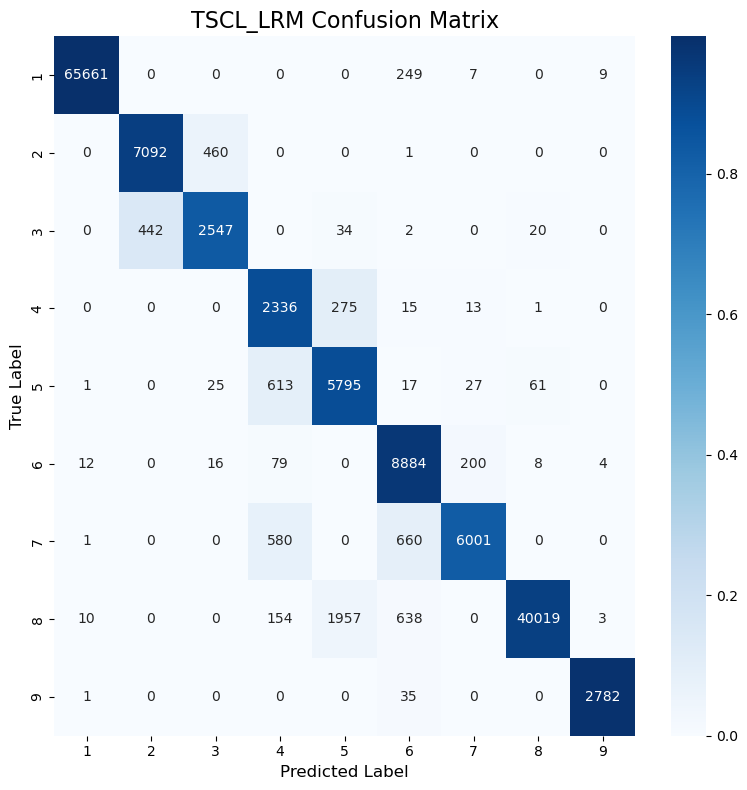

Classification Accuracy: 95.51%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


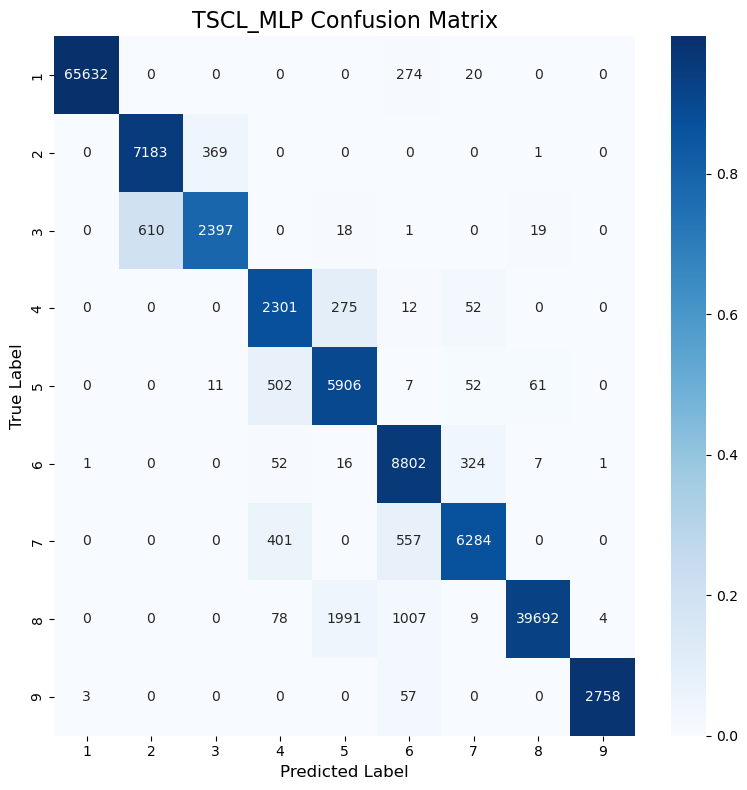

Classification Accuracy: 95.40%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


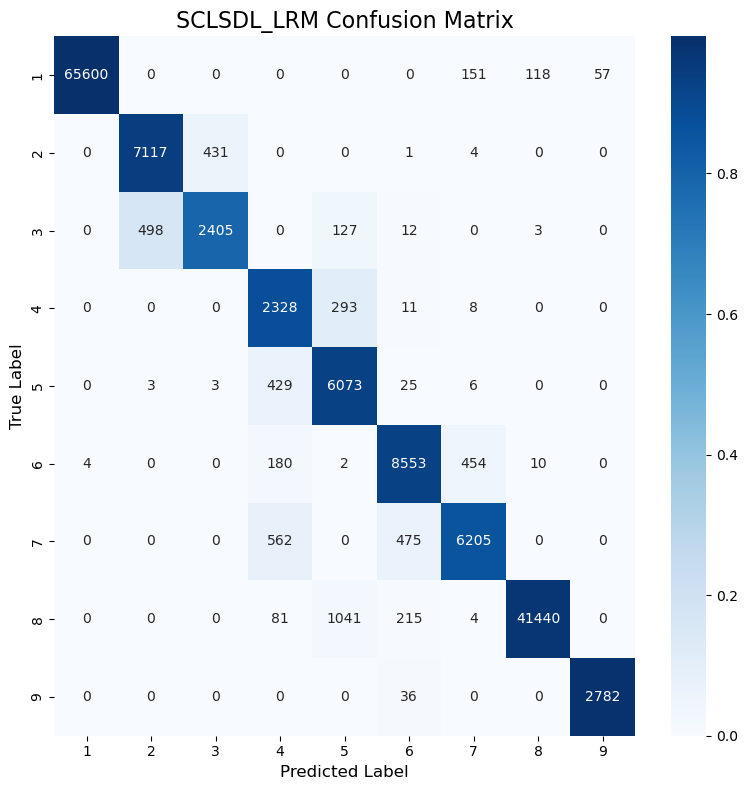

Classification Accuracy: 96.45%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


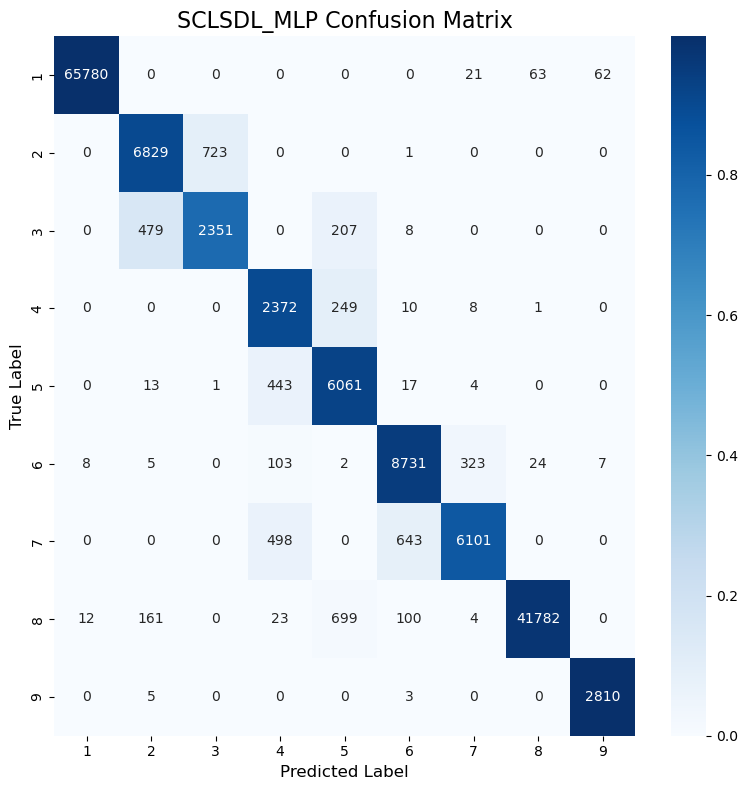

Classification Accuracy: 96.66%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          98.72
1    LRM (CAE)          95.48
2    MLP (CAE)          95.13
3     TSCL LRM          95.51
4     TSCL MLP          95.40
5  SCL_SDL LRM          96.45
6  SCL_SDL MLP          96.66

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          98.72
6  SCL_SDL MLP          96.66
5  SCL_SDL LRM          96.45
3     TSCL LRM          95.51
1    LRM (CAE)          95.48
4     TSCL MLP          95.40
2    MLP (CAE)          95.13
